###Overview

This notebook trains a Mamba model for the bird class.\
It uses only the samples taken from bird files (training and validation).\
The model is trained on all sample durations and so we prepare a dataloader that mixes batches of different durations.\
The training class does the training while evaluating the results on the validation samples (of different lengths).\
Notes:
- The training uses an early stopping mechanism where we stop if the validation results have not improved for over "early_stopping" parameter in the configuration.
- The best model parameters are saved, along with the training history. It is possible to load and continue training for a model by configuring 'continued' to True and incrementig 'run' in the training configuration.
- A warm up training with a high learning rate is also implemented.
- Training has an 'evaluation_length' parameter for determining the part of the seuence for which we evaluate performance. I used the last 3 seconds of each sample.
- Since we have different scales between different inputs and different samples, and we want to give them all the same weight in the loss function, we use the 'scale' of the samples to normalize the predictions and lables before going into the loss function. The scale is the 'local Std' calculated for each parameter in preprocessing.
- The model parameters and the time are encoded into a string for the file saving path for identification.

### Imports and loading

In [ ]:
# imports

import io
import os
import sys
from datetime import datetime
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
# from scipy.fft import fft
import pandas as pd
import seaborn as sns
import random

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,AdamW
from torch.optim.lr_scheduler import LinearLR, MultiStepLR

!pip install einops
# from __future__ import annotations
from dataclasses import dataclass
from einops import rearrange, repeat, einsum

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

from google.colab import drive
drive.mount('/content/drive/')
# helper files
sys.path.append('/content/drive/MyDrive/Final Project UAV/')
from UAV_project_preprocessing_and_visualization_helper_functions_full import *
from mamba_model import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 361.2 kB/s eta 0:00:00
Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


In [ ]:
subfolders = os.listdir("track_data/")
subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

### Model

In [ ]:
def prepare_mixed_dataloader(all_data, batch_size, shuffle = True):
  #shuffled once inside each duration group and then batches are shuffled among durations
  all_batches = []
  for dur, (samples, samples_filenames, dt, scales) in all_data.items():
    dur_vec = [dur]*len(samples)
    if len(samples) > 0:
      data = list(zip(samples, dt, scales, dur_vec))
      dl = DataLoader(data, batch_size = batch_size, shuffle = shuffle)
      for batch in dl:
        all_batches.append(batch)
  if shuffle:
    random.shuffle(all_batches)
  return all_batches

In [ ]:
# save_path = './Samples/mamba_samples_testing0_' + samples_config['subfolder'] + '_all_samples'
# with open(save_path , 'rb') as f:
#   # train_samples, test_samples, train_samples_filenames, test_samples_filenames, train_dt, test_dt, train_scales, test_scales = pickle.load(f)
#   (all_train_data, all_vel_data, all_test_data) = pickle.load(f)

In [ ]:
# train_batches = prepare_mixed_dataloader(all_train_data, 2)
# sample, dt, scale = train_batches[0]

# print(sample.shape)
# print(dt.shape)
# print(scale.shape)

torch.Size([2, 750, 8])
torch.Size([2, 750])
torch.Size([2, 8])


### Training class

In [ ]:
class Training(object):

  def __init__(self, model, config):
    self.config = config
    self.sample_durations = config['sample_durations']
    self.evaluation_durations = config['eval_sample_durations']
    self.device = config['device']
    self.model = model.to(self.config['device'])
    self.model_path = config['model_path']
    lr = config['optimizer_parameter']['lr']
    config['optimizer_parameter']['lr'] = 0.1
    self.optimizer = config['optimizer_type'](model.parameters(), **config['optimizer_parameter'])
    self.scheduler = MultiStepLR(self.optimizer, milestones=[5], gamma=lr/0.1)
    # self.scheduler = LinearLR(self.optimizer, start_factor=0.05/lr, end_factor=1, total_iters=20)
    self.criterion = config['criterion'].to(self.device)
    self.epoch_offset = 0
    self.training_time = 0
    self.evaluation_length = int(config['evaluation_time']/config['delta'])

  def train(self, train_data, eval_data):
    self.dl_train = train_data
    self.dl_eval = eval_data
    self.eval_history = {d:[] for d in self.evaluation_durations}
    self.eval_loss_history = []
    self.train_loss_history = []
    self.best_results = {d:None for d in self.evaluation_durations}

    if self.config['continued']:
      self.load_model() #loads model state from a previous run

    epochs_without_improvement = 0
    best_loss = None
    train_start = time()

    for epoch in range(self.epoch_offset, self.config['n_epochs'] + self.epoch_offset):
      # train
      self.train_epoch()
      #evaluate
      self.evaluate_epoch(self.dl_eval)
      self.scheduler.step()
      self.eval_loss_history.append(self.epoch_eval_loss/len(self.dl_eval))
      for d in self.evaluation_durations:
        if len(self.eval_results[d]) > 0: # this in case some class doesn't have test samples that are long enough for this d
          self.eval_history[d].append(sum(self.eval_results[d])/len(self.eval_results[d]))
        else:
          self.eval_history[d].append(0)

      if self.config['verbose']:
        print(f'epoch {epoch}: train loss = {self.train_loss_history[-1]}, eval loss = {self.eval_loss_history[-1]}')
      #check for early stopping
      if not best_loss or self.eval_history[10][-1] < best_loss:
        best_loss = self.eval_history[10][-1]
        best_train_loss = self.train_loss_history[-1]
        best_eval_loss = self.eval_loss_history[-1]
        self.best_results = {d:self.eval_history[d][-1] for d in self.evaluation_durations}

        epochs_without_improvement = 0
        #print ("Achieved lower validation loss, save model at epoch number {} ".format(epoch + 1) )
        best_model = copy.deepcopy(self.model.state_dict())
      else:
        epochs_without_improvement += 1

      if epochs_without_improvement == self.config['early_stopping']:
        if self.config['verbose']:
            print('\nEarly stoping after {} epochs. eval loss did not imporve for more than {} epochs'.format(epoch, self.config['early_stopping']))
        break

    self.training_time = self.training_time + time() - train_start

    # load best model and best performance and save
    self.model.load_state_dict(best_model)

    losslogger = {'train_loss': self.train_loss_history, 'eval_loss': self.eval_loss_history, 'eval_history': self.eval_history}
    state = {'epoch': epoch - epochs_without_improvement + 1, 'state_dict': best_model,
                'optimizer': self.optimizer.state_dict(), 'losslogger': losslogger, 'training_time': self.training_time}
    torch.save(state, self.model_path)

    if self.config['verbose']:
        print('\nFinished Training:')
        print('Best metrics are:')
        print(f'Best loss = {best_loss}')
        print(f'Best train loss = {best_train_loss}')
        print(f'Best eval loss = {best_eval_loss}')
        # print('Evaluation LogLoss = '.format(best_loss))
        for d, best in self.best_results.items():
            print(f'Best {d}sec eval = {best}')

        # print(f'Best 5sec eval = {best_5sec}')
        # print(f'Best 10sec eval= {best_10sec}')
        # print(f'Best 30sec eval= {best_30sec}')
        # print(f'Best 60sec eval= {best_60sec}')

  def train_epoch(self):
    self.epoch_train_loss   = 0
    self.model.train() # train mode
    for batch in tqdm(self.dl_train, disable=(not self.config['verbose'])):
      self.train_batch(batch)
    self.train_loss_history.append(self.epoch_train_loss/len(self.dl_train))


  def train_batch(self, batch):
    data, dt, scale, dur = batch
    # Send tensors to GPU
    samples = data[:,:-1,:]
    labels = data[:,1:,:]
    samples = samples.to(self.device)
    labels = labels.to(self.device)

    dt = dt[:, :-1].to(self.device)
    scale = scale.to(self.device)
    predictions = self.model(samples, dt)#.type(torch.float64)#.type(torch.DoubleTensor)
    scaled_labels = einsum(labels, 1/scale, 'b l d, b d -> b l d')
    scaled_predictions = einsum(predictions, 1/scale, 'b l d, b d -> b l d')
    loss = self.criterion(scaled_predictions, scaled_labels)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.epoch_train_loss += loss.item()

  def evaluate_epoch(self, dl_eval):
    self.eval_results = {d:[] for d in self.evaluation_durations}
    self.epoch_eval_loss = 0

    self.model.eval() #evaluation mode
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=(not self.config['verbose'])):
        self.eval_batch(batch)

  def eval_batch(self, batch):
    data, dt, scale, dur = batch
    # Send tensors to GPU
    samples = data[:,:-1,:]
    labels = data[:,1:,:]
    samples = samples.to(self.device)
    labels = labels.to(self.device)
    dt = dt[:, :-1].to(self.device)
    scale = scale.to(self.device)

    predictions = self.model(samples, dt)#.type(torch.float64)#.type(torch.DoubleTensor)

    scaled_labels = einsum(labels, 1/scale, 'b l d, b d -> b l d')
    scaled_predictions = einsum(predictions, 1/scale, 'b l d, b d -> b l d')
    criterion = nn.MSELoss(reduction='none').to(self.device)
    eval_loss = criterion(scaled_predictions, scaled_labels)
    self.eval_results[int(dur[0])].append((eval_loss[:, -self.evaluation_length:, :].mean()).cpu())
    self.epoch_eval_loss += eval_loss.mean().item()

  def load_model(self):
    prev_model = self.model_path[:-1] + str(self.config['run']-1)
    if os.path.exists(prev_model) and not os.path.exists(self.model_path):
      state = torch.load(prev_model)
      self.model.load_state_dict(state['state_dict'])
      self.optimizer.load_state_dict(state['optimizer'])
      self.epoch_offset = state['epoch']
      self.train_loss_history = state['losslogger']['train_loss']
      self.eval_loss_history = state['losslogger']['eval_loss']
      self.eval_history = state['losslogger']['eval_history']
      self.training_time = state['training_time']
    else:
      raise ValueError('No previous model found')

In [ ]:
def plot_training_summary(training_model):
  epochs = np.arange(len(training_model.train_loss_history)) + 1
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  ax1.plot(epochs, training_model.train_loss_history, 'r', label = 'train loss')
  ax1.plot(epochs, training_model.eval_loss_history, 'orange', label = 'eval loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.legend()
  palette = plt.get_cmap('tab20')
  colors = [palette(i) for i in range(len(training_model.evaluation_durations))]
  for d, color in zip(training_model.evaluation_durations, colors):
    plt.yscale("log")
    ax2.plot(epochs, training_model.eval_history[d], color = color, label = d)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Error')
  ax2.legend()

In [ ]:
def conf2str(mamba_config, training_config):
  conf_str = 'dm' + str(mamba_config['d_model']) \
  +'nl' + str(mamba_config['n_layer']) \
  +'ds' + str(mamba_config['d_state']) \
  +'dc' + str(mamba_config['d_conv']) \
  +'rs' + str(mamba_config['model_random_state']) \
  +'bs' + str(training_config['batch_size']) \
  +'op' + training_config['optimizer_name'] \
  +'lr' + str(training_config['optimizer_parameter']['lr'])\
  +'r' + str(training_config['run'])

  return conf_str

## Experiments
The blocks below execute training.\
We need to:
1. Set the samples configuration
2. Set the Mamba model configuration parameters
3. Create a Mamba model according to the parameters
4. Set the training configuration parameters
5. Init a training instance
6. Prepare dataloaders for the training and validation sets
7. Train
8. Record all the results with the configurations to a pandas dataframe. Save it.
9. Plot the training summary

In [ ]:
samples_config = {
    'subfolder' : 'bird',
    'delta' : 0.04,
    'sample_durations' : [5, 10, 30, 60],
    'eval_sample_durations' : [5, 10, 15, 20, 25, 30],
    'sample_duration' : 10,
    'skip_duration' : 2,
    'min_samples' : 10
}

In [ ]:
# save_path = './Samples/mamba_samples_' + samples_config['subfolder'] + '_all_samples'
save_path = './Samples/mamba_samples_' + samples_config['subfolder'] + '_skip' + str(samples_config['skip_duration']) + '_split0.2'+ '_all_samples'
with open(save_path , 'rb') as f:
  (all_train_data, all_val_data, all_test_data) = pickle.load(f)

(test_samples, test_filenames, test_dt, test_scales) = all_test_data[5]

In [ ]:
record_columns = ['datetime', 'Best Result @5', 'Best Result @10', 'Best Result @20', 'Learning Rate','Batch Size','Layers','d_state','Model Path', 'Test Files', 'Mamba Config', 'Training Config', 'Train Loss History', 'Evaluation Loss History', 'Eval History', 'Best Results']
exp_record = pd.DataFrame(columns = record_columns)

100%|██████████| 14/14 [00:01<00:00, 10.05it/s]


epoch 0: train loss = 298195.3572443182, eval loss = 227804.97433035713


100%|██████████| 14/14 [00:01<00:00,  9.53it/s]


epoch 1: train loss = 261412.27272727274, eval loss = 196908.66517857142


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


epoch 2: train loss = 231447.04900568182, eval loss = 172761.07198660713


100%|██████████| 14/14 [00:01<00:00,  9.86it/s]


epoch 3: train loss = 206776.76704545456, eval loss = 148513.7935267857


100%|██████████| 14/14 [00:01<00:00, 10.01it/s]


epoch 4: train loss = 183808.53657670456, eval loss = 128533.79073660714


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 5: train loss = 171932.50461647726, eval loss = 126369.06361607143


100%|██████████| 14/14 [00:01<00:00,  7.17it/s]


epoch 6: train loss = 169681.7137784091, eval loss = 124544.83482142857


100%|██████████| 14/14 [00:01<00:00,  8.06it/s]


epoch 7: train loss = 167632.82066761365, eval loss = 122761.21763392857


100%|██████████| 14/14 [00:01<00:00, 10.06it/s]


epoch 8: train loss = 165622.59019886365, eval loss = 120966.32533482143


100%|██████████| 14/14 [00:01<00:00,  9.76it/s]


epoch 9: train loss = 163634.34517045456, eval loss = 119227.73716517857


100%|██████████| 14/14 [00:01<00:00,  9.77it/s]


epoch 10: train loss = 161665.13671875, eval loss = 117489.46484375


100%|██████████| 14/14 [00:01<00:00,  9.85it/s]


epoch 11: train loss = 159715.35085227274, eval loss = 115732.34988839286


100%|██████████| 14/14 [00:01<00:00,  9.84it/s]


epoch 12: train loss = 157778.21626420456, eval loss = 113987.38002232143


100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


epoch 13: train loss = 155857.79332386365, eval loss = 112243.39899553571


100%|██████████| 14/14 [00:01<00:00,  8.56it/s]


epoch 14: train loss = 153950.30823863635, eval loss = 110507.25334821429


100%|██████████| 14/14 [00:02<00:00,  6.79it/s]


epoch 15: train loss = 152057.79545454544, eval loss = 108778.63727678571


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


epoch 16: train loss = 150180.265625, eval loss = 107069.92354910714


100%|██████████| 14/14 [00:01<00:00,  9.94it/s]


epoch 17: train loss = 148319.24041193182, eval loss = 105352.60658482143


100%|██████████| 14/14 [00:01<00:00,  9.95it/s]


epoch 18: train loss = 146482.81285511365, eval loss = 103660.92633928571


100%|██████████| 14/14 [00:01<00:00,  9.62it/s]


epoch 19: train loss = 144668.58132102274, eval loss = 101979.22879464286


100%|██████████| 14/14 [00:01<00:00,  9.89it/s]


epoch 20: train loss = 142873.9520596591, eval loss = 100326.32087053571


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


epoch 21: train loss = 141100.84197443182, eval loss = 98684.75446428571


100%|██████████| 14/14 [00:01<00:00,  9.71it/s]


epoch 22: train loss = 139346.99254261365, eval loss = 97057.45647321429


100%|██████████| 14/14 [00:02<00:00,  6.79it/s]


epoch 23: train loss = 137611.3075284091, eval loss = 95453.12555803571


100%|██████████| 14/14 [00:01<00:00,  8.33it/s]


epoch 24: train loss = 135894.5245028409, eval loss = 93877.23828125


100%|██████████| 14/14 [00:01<00:00,  9.94it/s]


epoch 25: train loss = 134199.0440340909, eval loss = 92333.46484375


100%|██████████| 14/14 [00:01<00:00,  9.75it/s]


epoch 26: train loss = 132522.3270596591, eval loss = 90797.8046875


100%|██████████| 14/14 [00:01<00:00,  9.93it/s]


epoch 27: train loss = 130864.71590909091, eval loss = 89280.59821428571


100%|██████████| 14/14 [00:01<00:00,  9.70it/s]


epoch 28: train loss = 129228.33238636363, eval loss = 87778.98716517857


100%|██████████| 14/14 [00:01<00:00,  9.92it/s]


epoch 29: train loss = 127611.62713068182, eval loss = 86295.16071428571


100%|██████████| 14/14 [00:01<00:00,  9.96it/s]


epoch 30: train loss = 126013.61647727272, eval loss = 84833.47712053571


100%|██████████| 14/14 [00:01<00:00,  8.05it/s]


epoch 31: train loss = 124434.13636363637, eval loss = 83371.763671875


100%|██████████| 14/14 [00:01<00:00,  7.16it/s]


epoch 32: train loss = 122878.02450284091, eval loss = 81954.72042410714


100%|██████████| 14/14 [00:01<00:00,  9.59it/s]


epoch 33: train loss = 121344.50852272728, eval loss = 80545.76785714286


100%|██████████| 14/14 [00:01<00:00,  9.95it/s]


epoch 34: train loss = 119825.14417613637, eval loss = 79143.23297991071


100%|██████████| 14/14 [00:01<00:00,  9.68it/s]


epoch 35: train loss = 118322.76988636363, eval loss = 77712.95424107143


100%|██████████| 14/14 [00:01<00:00,  9.98it/s]


epoch 36: train loss = 116834.28373579546, eval loss = 76371.71177455357


100%|██████████| 14/14 [00:01<00:00,  9.76it/s]


epoch 37: train loss = 115369.19247159091, eval loss = 75047.67661830357


100%|██████████| 14/14 [00:01<00:00, 10.29it/s]


epoch 38: train loss = 113919.90767045454, eval loss = 73713.59068080357


100%|██████████| 14/14 [00:01<00:00, 10.06it/s]


epoch 39: train loss = 112489.19975142046, eval loss = 72415.09123883929


100%|██████████| 14/14 [00:02<00:00,  6.46it/s]


epoch 40: train loss = 111069.59659090909, eval loss = 71141.701171875


100%|██████████| 14/14 [00:01<00:00,  9.16it/s]


epoch 41: train loss = 109683.60280539772, eval loss = 69895.859375


100%|██████████| 14/14 [00:01<00:00,  9.91it/s]


epoch 42: train loss = 108306.79758522728, eval loss = 68664.06082589286


100%|██████████| 14/14 [00:01<00:00,  9.96it/s]


epoch 43: train loss = 106952.568359375, eval loss = 67404.69363839286


100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


epoch 44: train loss = 105611.18963068182, eval loss = 66215.60491071429


100%|██████████| 14/14 [00:01<00:00,  9.70it/s]


epoch 45: train loss = 104288.69921875, eval loss = 65063.818359375


100%|██████████| 14/14 [00:01<00:00,  9.79it/s]


epoch 46: train loss = 102982.02432528409, eval loss = 63870.759486607145


100%|██████████| 14/14 [00:01<00:00,  9.74it/s]


epoch 47: train loss = 101697.38299005682, eval loss = 62694.57142857143


100%|██████████| 14/14 [00:01<00:00,  7.38it/s]


epoch 48: train loss = 100428.779296875, eval loss = 61571.88922991072


100%|██████████| 14/14 [00:01<00:00,  7.49it/s]


epoch 49: train loss = 99169.13600852272, eval loss = 60480.458984375


100%|██████████| 14/14 [00:01<00:00,  9.79it/s]


epoch 50: train loss = 97935.29421164772, eval loss = 59408.888950892855


100%|██████████| 14/14 [00:01<00:00,  9.71it/s]


epoch 51: train loss = 96713.02556818182, eval loss = 58268.576171875


100%|██████████| 14/14 [00:01<00:00,  9.92it/s]


epoch 52: train loss = 95508.31587357954, eval loss = 57199.857421875


100%|██████████| 14/14 [00:01<00:00, 10.07it/s]


epoch 53: train loss = 94315.18128551137, eval loss = 56131.546595982145


100%|██████████| 14/14 [00:01<00:00,  9.98it/s]


epoch 54: train loss = 93147.28693181818, eval loss = 55151.16685267857


100%|██████████| 14/14 [00:01<00:00,  9.95it/s]


epoch 55: train loss = 91997.361328125, eval loss = 54131.052455357145


100%|██████████| 14/14 [00:01<00:00,  9.83it/s]


epoch 56: train loss = 90855.56889204546, eval loss = 53076.12946428572


100%|██████████| 14/14 [00:01<00:00,  7.03it/s]


epoch 57: train loss = 89723.09303977272, eval loss = 52079.420200892855


100%|██████████| 14/14 [00:01<00:00,  8.32it/s]


epoch 58: train loss = 88610.15838068182, eval loss = 51082.646484375


100%|██████████| 14/14 [00:01<00:00,  9.68it/s]


epoch 59: train loss = 87518.37677556818, eval loss = 50155.98186383928


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


epoch 60: train loss = 86446.37233664772, eval loss = 49216.40150669643


100%|██████████| 14/14 [00:01<00:00,  9.91it/s]


epoch 61: train loss = 85389.03746448863, eval loss = 48242.57268415178


100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


epoch 62: train loss = 84338.734375, eval loss = 47346.19614955357


100%|██████████| 14/14 [00:01<00:00, 10.21it/s]


epoch 63: train loss = 83299.32990056818, eval loss = 46346.87541852678


100%|██████████| 14/14 [00:01<00:00,  9.93it/s]


epoch 64: train loss = 82283.07652698863, eval loss = 45569.58482142857


100%|██████████| 14/14 [00:01<00:00,  9.00it/s]


epoch 65: train loss = 81279.57723721591, eval loss = 44604.16936383928


100%|██████████| 14/14 [00:02<00:00,  6.57it/s]


epoch 66: train loss = 80288.37890625, eval loss = 43675.7294921875


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 67: train loss = 79369.32350852272, eval loss = 42821.57142857143


100%|██████████| 14/14 [00:01<00:00,  9.91it/s]


epoch 68: train loss = 78439.74822443182, eval loss = 42128.940708705355


100%|██████████| 14/14 [00:01<00:00,  9.89it/s]


epoch 69: train loss = 77450.82510653409, eval loss = 41171.16350446428


100%|██████████| 14/14 [00:01<00:00,  9.84it/s]


epoch 70: train loss = 76511.38938210228, eval loss = 40347.99623325893


100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


epoch 71: train loss = 75586.17649147728, eval loss = 39586.032505580355


100%|██████████| 14/14 [00:01<00:00,  9.78it/s]


epoch 72: train loss = 74677.67649147728, eval loss = 38749.88323102678


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


epoch 73: train loss = 73782.51775568182, eval loss = 37951.85100446428


100%|██████████| 14/14 [00:01<00:00,  7.96it/s]


epoch 74: train loss = 72900.82768110796, eval loss = 37176.152622767855


100%|██████████| 14/14 [00:01<00:00,  7.92it/s]


epoch 75: train loss = 72032.69113991478, eval loss = 36425.253627232145


100%|██████████| 14/14 [00:01<00:00, 10.02it/s]


epoch 76: train loss = 71178.83868963068, eval loss = 35671.90973772322


100%|██████████| 14/14 [00:01<00:00, 10.00it/s]


epoch 77: train loss = 70339.40491832387, eval loss = 34930.0966796875


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


epoch 78: train loss = 69512.01775568182, eval loss = 34195.05385044643


100%|██████████| 14/14 [00:01<00:00,  9.95it/s]


epoch 79: train loss = 68696.68368252841, eval loss = 33466.68359375


100%|██████████| 14/14 [00:01<00:00, 10.05it/s]


epoch 80: train loss = 67894.34286221591, eval loss = 32757.637137276786


100%|██████████| 14/14 [00:01<00:00, 10.10it/s]


epoch 81: train loss = 67105.07750355113, eval loss = 32067.2392578125


100%|██████████| 14/14 [00:01<00:00,  9.92it/s]


epoch 82: train loss = 66330.36301491478, eval loss = 31406.915178571428


100%|██████████| 14/14 [00:01<00:00,  7.08it/s]


epoch 83: train loss = 65569.07652698863, eval loss = 30757.156808035714


100%|██████████| 14/14 [00:01<00:00,  8.38it/s]


epoch 84: train loss = 64817.39266690341, eval loss = 30111.53250558036


100%|██████████| 14/14 [00:01<00:00,  9.75it/s]


epoch 85: train loss = 64076.19522372159, eval loss = 29467.444893973214


100%|██████████| 14/14 [00:01<00:00,  9.74it/s]


epoch 86: train loss = 63344.766157670456, eval loss = 28802.099469866072


100%|██████████| 14/14 [00:01<00:00,  9.91it/s]


epoch 87: train loss = 62625.412642045456, eval loss = 28154.057059151786


100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


epoch 88: train loss = 61920.810546875, eval loss = 27534.132672991072


100%|██████████| 14/14 [00:01<00:00,  9.67it/s]


epoch 89: train loss = 61226.458984375, eval loss = 26950.74386160714


100%|██████████| 14/14 [00:01<00:00,  9.86it/s]


epoch 90: train loss = 60545.652521306816, eval loss = 26390.483537946428


100%|██████████| 14/14 [00:01<00:00,  8.17it/s]


epoch 91: train loss = 59878.15305397727, eval loss = 25801.506766183036


100%|██████████| 14/14 [00:01<00:00,  7.13it/s]


epoch 92: train loss = 59222.32652698864, eval loss = 25258.33203125


100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


epoch 93: train loss = 58572.097478693184, eval loss = 24700.185407366072


100%|██████████| 14/14 [00:01<00:00, 10.09it/s]


epoch 94: train loss = 57932.57590553977, eval loss = 24155.042619977678


100%|██████████| 14/14 [00:01<00:00,  9.54it/s]


epoch 95: train loss = 57303.29811789773, eval loss = 23601.288992745536


100%|██████████| 14/14 [00:01<00:00, 10.04it/s]


epoch 96: train loss = 56685.854669744316, eval loss = 23054.181012834822


100%|██████████| 14/14 [00:01<00:00,  9.85it/s]


epoch 97: train loss = 56080.37952769886, eval loss = 22534.167898995536


100%|██████████| 14/14 [00:01<00:00,  9.74it/s]


epoch 98: train loss = 55483.33194247159, eval loss = 22040.92068917411


100%|██████████| 14/14 [00:01<00:00,  9.87it/s]


epoch 99: train loss = 54901.08620383523, eval loss = 21564.96065848214


100%|██████████| 14/14 [00:02<00:00,  6.87it/s]


epoch 100: train loss = 54327.399946732956, eval loss = 21077.73897879464


100%|██████████| 14/14 [00:01<00:00,  8.33it/s]


epoch 101: train loss = 53765.75417258523, eval loss = 20603.733328683036


100%|██████████| 14/14 [00:01<00:00,  9.99it/s]


epoch 102: train loss = 53211.42098721591, eval loss = 20156.64481026786


100%|██████████| 14/14 [00:01<00:00, 10.12it/s]


epoch 103: train loss = 52665.54359019886, eval loss = 19688.126604352678


100%|██████████| 14/14 [00:01<00:00,  9.77it/s]


epoch 104: train loss = 52130.07608309659, eval loss = 19195.62520926339


100%|██████████| 14/14 [00:01<00:00,  9.65it/s]


epoch 105: train loss = 51602.79758522727, eval loss = 18753.89501953125


100%|██████████| 14/14 [00:01<00:00,  9.90it/s]


epoch 106: train loss = 51088.118963068184, eval loss = 18305.504464285714


100%|██████████| 14/14 [00:01<00:00,  9.87it/s]


epoch 107: train loss = 50586.6689453125, eval loss = 17870.91092354911


100%|██████████| 14/14 [00:01<00:00,  8.31it/s]


epoch 108: train loss = 50098.14577414773, eval loss = 17465.03076171875


100%|██████████| 14/14 [00:02<00:00,  6.94it/s]


epoch 109: train loss = 49624.224609375, eval loss = 17060.869768415178


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


epoch 110: train loss = 49142.57919034091, eval loss = 16677.00753348214


100%|██████████| 14/14 [00:01<00:00,  9.82it/s]


epoch 111: train loss = 48659.46395596591, eval loss = 16223.4443359375


100%|██████████| 14/14 [00:01<00:00,  9.95it/s]


epoch 112: train loss = 48370.60182883523, eval loss = 15961.782645089286


100%|██████████| 14/14 [00:01<00:00,  9.98it/s]


epoch 113: train loss = 47883.78102805398, eval loss = 15406.14634486607


100%|██████████| 14/14 [00:01<00:00,  9.91it/s]


epoch 114: train loss = 47397.31223366477, eval loss = 15203.516915457589


100%|██████████| 14/14 [00:01<00:00,  9.78it/s]


epoch 115: train loss = 46934.34628018466, eval loss = 14911.181082589286


100%|██████████| 14/14 [00:01<00:00,  8.22it/s]


epoch 116: train loss = 46470.91956676136, eval loss = 14419.999476841518


100%|██████████| 14/14 [00:02<00:00,  6.56it/s]


epoch 117: train loss = 46044.9072265625, eval loss = 14056.528878348214


100%|██████████| 14/14 [00:01<00:00,  9.71it/s]


epoch 118: train loss = 45631.11319247159, eval loss = 13752.378104073661


100%|██████████| 14/14 [00:01<00:00, 10.10it/s]


epoch 119: train loss = 45224.677290482956, eval loss = 13396.16273716518


100%|██████████| 14/14 [00:01<00:00,  9.94it/s]


epoch 120: train loss = 44829.58469460227, eval loss = 13020.59849330357


100%|██████████| 14/14 [00:01<00:00, 10.07it/s]


epoch 121: train loss = 44430.10129616477, eval loss = 12736.825648716518


100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


epoch 122: train loss = 44062.843927556816, eval loss = 12466.442452566964


100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


epoch 123: train loss = 43522.170942826706, eval loss = 12097.030238560268


100%|██████████| 14/14 [00:01<00:00,  9.94it/s]


epoch 124: train loss = 42818.67360617898, eval loss = 11894.3662109375


100%|██████████| 14/14 [00:01<00:00,  8.02it/s]


epoch 125: train loss = 42404.83775745739, eval loss = 11973.49574497768


100%|██████████| 14/14 [00:01<00:00,  7.21it/s]


epoch 126: train loss = 41972.54372336648, eval loss = 11311.078369140625


100%|██████████| 14/14 [00:01<00:00,  9.77it/s]


epoch 127: train loss = 41452.30970348011, eval loss = 11041.071742466518


100%|██████████| 14/14 [00:01<00:00,  9.76it/s]


epoch 128: train loss = 41116.526544744316, eval loss = 10654.317905970982


100%|██████████| 14/14 [00:01<00:00, 10.00it/s]


epoch 129: train loss = 40727.26864346591, eval loss = 10712.44614955357


100%|██████████| 14/14 [00:01<00:00,  9.59it/s]


epoch 130: train loss = 40267.17054332386, eval loss = 10374.511335100446


100%|██████████| 14/14 [00:01<00:00,  9.71it/s]


epoch 131: train loss = 39838.286177201706, eval loss = 10276.35804966518


100%|██████████| 14/14 [00:01<00:00, 10.07it/s]


epoch 132: train loss = 39422.420099431816, eval loss = 10075.089634486607


100%|██████████| 14/14 [00:01<00:00, 10.14it/s]


epoch 133: train loss = 39067.136541193184, eval loss = 9800.374895368304


100%|██████████| 14/14 [00:01<00:00,  7.07it/s]


epoch 134: train loss = 38726.6630859375, eval loss = 9519.047154017857


100%|██████████| 14/14 [00:01<00:00,  7.96it/s]


epoch 135: train loss = 38326.961381392044, eval loss = 9173.101283482143


100%|██████████| 14/14 [00:01<00:00,  9.87it/s]


epoch 136: train loss = 37969.024103338066, eval loss = 9105.013602120536


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


epoch 137: train loss = 37582.13534268466, eval loss = 8988.762137276786


100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


epoch 138: train loss = 37242.68044211648, eval loss = 8630.898978097099


100%|██████████| 14/14 [00:01<00:00,  9.53it/s]


epoch 139: train loss = 36916.383611505684, eval loss = 8490.247785295758


100%|██████████| 14/14 [00:01<00:00,  9.83it/s]


epoch 140: train loss = 36554.76194069602, eval loss = 8256.021606445312


100%|██████████| 14/14 [00:01<00:00,  9.89it/s]


epoch 141: train loss = 36230.32874644886, eval loss = 8021.651227678572


100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


epoch 142: train loss = 35905.877974076706, eval loss = 7795.260288783482


100%|██████████| 14/14 [00:02<00:00,  7.00it/s]


epoch 143: train loss = 35583.30606356534, eval loss = 7656.231026785715


100%|██████████| 14/14 [00:01<00:00,  8.52it/s]


epoch 144: train loss = 35262.152521306816, eval loss = 7397.56072126116


100%|██████████| 14/14 [00:01<00:00,  9.73it/s]


epoch 145: train loss = 34962.281560724434, eval loss = 7317.830723353794


100%|██████████| 14/14 [00:01<00:00,  9.70it/s]


epoch 146: train loss = 34645.54208096591, eval loss = 7042.915004185268


100%|██████████| 14/14 [00:01<00:00,  9.65it/s]


epoch 147: train loss = 34364.973100142044, eval loss = 6914.707170758928


100%|██████████| 14/14 [00:01<00:00,  9.89it/s]


epoch 148: train loss = 34051.734818892044, eval loss = 6720.974557059152


100%|██████████| 14/14 [00:01<00:00,  9.55it/s]


epoch 149: train loss = 33771.21555397727, eval loss = 6693.150059291294


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


epoch 150: train loss = 33468.643998579544, eval loss = 6584.133143833706


100%|██████████| 14/14 [00:02<00:00,  6.50it/s]


epoch 151: train loss = 33188.39719460227, eval loss = 6513.584402901785


100%|██████████| 14/14 [00:01<00:00,  8.95it/s]


epoch 152: train loss = 32910.42422762784, eval loss = 6421.324428013393


100%|██████████| 14/14 [00:01<00:00,  9.14it/s]


epoch 153: train loss = 32639.051313920456, eval loss = 6238.599818638393


100%|██████████| 14/14 [00:01<00:00,  9.54it/s]


epoch 154: train loss = 32368.420676491478, eval loss = 5989.679966517857


100%|██████████| 14/14 [00:01<00:00,  9.23it/s]


epoch 155: train loss = 32102.116832386364, eval loss = 6055.191911969866


100%|██████████| 14/14 [00:01<00:00,  9.24it/s]


epoch 156: train loss = 31806.670365767044, eval loss = 5717.394548688616


100%|██████████| 14/14 [00:01<00:00,  8.06it/s]


epoch 157: train loss = 31567.81365411932, eval loss = 5528.060215541294


100%|██████████| 14/14 [00:01<00:00,  7.04it/s]


epoch 158: train loss = 31292.648859197445, eval loss = 5825.719430106027


100%|██████████| 14/14 [00:01<00:00,  9.25it/s]


epoch 159: train loss = 30978.722301136364, eval loss = 4934.337890625


100%|██████████| 14/14 [00:01<00:00,  9.54it/s]


epoch 160: train loss = 30707.353382457386, eval loss = 5315.460431780134


100%|██████████| 14/14 [00:01<00:00,  9.34it/s]


epoch 161: train loss = 30392.05977006392, eval loss = 4800.215881347656


100%|██████████| 14/14 [00:01<00:00,  9.65it/s]


epoch 162: train loss = 30124.96570933949, eval loss = 4919.887887137277


100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


epoch 163: train loss = 29844.40507368608, eval loss = 4678.621189662388


100%|██████████| 14/14 [00:01<00:00,  8.96it/s]


epoch 164: train loss = 29566.829367897728, eval loss = 4619.583269391741


100%|██████████| 14/14 [00:02<00:00,  6.62it/s]


epoch 165: train loss = 29290.012628728695, eval loss = 4577.826625279018


100%|██████████| 14/14 [00:01<00:00,  9.95it/s]


epoch 166: train loss = 29013.01134144176, eval loss = 4634.054408482143


100%|██████████| 14/14 [00:01<00:00,  9.72it/s]


epoch 167: train loss = 28742.405184659092, eval loss = 4511.627092633928


100%|██████████| 14/14 [00:01<00:00,  9.87it/s]


epoch 168: train loss = 28503.21515447443, eval loss = 4597.614850725447


100%|██████████| 14/14 [00:01<00:00, 10.02it/s]


epoch 169: train loss = 28209.107266512783, eval loss = 4589.914768763951


100%|██████████| 14/14 [00:01<00:00, 10.11it/s]


epoch 170: train loss = 27933.26045365767, eval loss = 4576.8094482421875


100%|██████████| 14/14 [00:01<00:00, 10.17it/s]


epoch 171: train loss = 27672.985418146305, eval loss = 4442.894923618862


100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


epoch 172: train loss = 27406.637162642044, eval loss = 4315.60205078125


100%|██████████| 14/14 [00:01<00:00,  8.30it/s]


epoch 173: train loss = 27186.046897194603, eval loss = 4212.355974469866


100%|██████████| 14/14 [00:02<00:00,  6.81it/s]


epoch 174: train loss = 26971.932106711647, eval loss = 4394.582196916853


100%|██████████| 14/14 [00:01<00:00,  9.78it/s]


epoch 175: train loss = 26677.422296697445, eval loss = 4567.6851806640625


100%|██████████| 14/14 [00:01<00:00,  9.84it/s]


epoch 176: train loss = 26420.180020419033, eval loss = 4460.5855712890625


100%|██████████| 14/14 [00:01<00:00,  9.87it/s]


epoch 177: train loss = 26176.000998757103, eval loss = 4274.863194056919


100%|██████████| 14/14 [00:01<00:00,  9.83it/s]


epoch 178: train loss = 25929.358065518467, eval loss = 4166.41095842634


100%|██████████| 14/14 [00:01<00:00, 10.03it/s]


epoch 179: train loss = 25686.956898082386, eval loss = 4055.5698765345983


100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


epoch 180: train loss = 25458.100608132103, eval loss = 4183.665126255581


100%|██████████| 14/14 [00:01<00:00,  9.80it/s]


epoch 181: train loss = 25239.187255859375, eval loss = 4260.968488420759


100%|██████████| 14/14 [00:01<00:00,  7.34it/s]


epoch 182: train loss = 25015.59257368608, eval loss = 4164.860316685268


100%|██████████| 14/14 [00:01<00:00,  7.89it/s]


epoch 183: train loss = 24740.890625, eval loss = 3498.235377720424


100%|██████████| 14/14 [00:01<00:00,  9.89it/s]


epoch 184: train loss = 24545.35438121449, eval loss = 3601.7348109654017


100%|██████████| 14/14 [00:01<00:00,  9.86it/s]


epoch 185: train loss = 24326.761940696022, eval loss = 3608.711896623884


100%|██████████| 14/14 [00:01<00:00,  9.66it/s]


epoch 186: train loss = 24068.628506747158, eval loss = 3391.0357840401784


100%|██████████| 14/14 [00:01<00:00,  9.11it/s]


epoch 187: train loss = 23890.56141246449, eval loss = 3703.7024972098216


100%|██████████| 14/14 [00:01<00:00,  9.28it/s]


epoch 188: train loss = 23651.696932705967, eval loss = 3490.333565848214


100%|██████████| 14/14 [00:01<00:00,  9.12it/s]


epoch 189: train loss = 23423.59783380682, eval loss = 3597.7894112723216


100%|██████████| 14/14 [00:02<00:00,  6.13it/s]


epoch 190: train loss = 23174.11376953125, eval loss = 3176.202135358538


100%|██████████| 14/14 [00:01<00:00,  9.12it/s]


epoch 191: train loss = 22959.99158824574, eval loss = 2978.57821219308


100%|██████████| 14/14 [00:01<00:00,  9.29it/s]


epoch 192: train loss = 22821.480002663353, eval loss = 3393.977948869978


100%|██████████| 14/14 [00:01<00:00,  9.58it/s]


epoch 193: train loss = 22573.770241477272, eval loss = 2919.6952165876114


100%|██████████| 14/14 [00:01<00:00,  9.58it/s]


epoch 194: train loss = 22380.938343394886, eval loss = 3436.518580845424


100%|██████████| 14/14 [00:01<00:00,  9.32it/s]


epoch 195: train loss = 22142.5732421875, eval loss = 3012.66836983817


100%|██████████| 14/14 [00:02<00:00,  6.81it/s]


epoch 196: train loss = 21915.245072798294, eval loss = 2943.0885794503347


100%|██████████| 14/14 [00:01<00:00,  8.15it/s]


epoch 197: train loss = 21693.9423939098, eval loss = 2861.314130510603


100%|██████████| 14/14 [00:01<00:00,  9.42it/s]


epoch 198: train loss = 21519.773415305397, eval loss = 2580.604714529855


100%|██████████| 14/14 [00:01<00:00,  9.54it/s]


epoch 199: train loss = 21397.512440074574, eval loss = 2827.7690778459823


100%|██████████| 14/14 [00:01<00:00,  9.83it/s]


epoch 200: train loss = 21150.874378551136, eval loss = 2798.2798374720983


100%|██████████| 14/14 [00:01<00:00,  9.85it/s]


epoch 201: train loss = 20931.907448508522, eval loss = 2779.3470458984375


100%|██████████| 14/14 [00:01<00:00, 10.05it/s]


epoch 202: train loss = 20737.53495649858, eval loss = 2584.872549874442


100%|██████████| 14/14 [00:01<00:00, 10.12it/s]


epoch 203: train loss = 20581.112271395596, eval loss = 2511.37295968192


100%|██████████| 14/14 [00:02<00:00,  6.89it/s]


epoch 204: train loss = 20399.46180308949, eval loss = 2739.418770926339


100%|██████████| 14/14 [00:01<00:00,  7.91it/s]


epoch 205: train loss = 20186.052201704544, eval loss = 2479.2483869280136


100%|██████████| 14/14 [00:01<00:00,  9.88it/s]


epoch 206: train loss = 20002.05094770952, eval loss = 2478.962873186384


100%|██████████| 14/14 [00:01<00:00,  9.90it/s]


epoch 207: train loss = 19832.729858398438, eval loss = 2413.604221888951


100%|██████████| 14/14 [00:01<00:00,  9.96it/s]


epoch 208: train loss = 19663.57694868608, eval loss = 2395.6173880440847


100%|██████████| 14/14 [00:01<00:00,  9.88it/s]


epoch 209: train loss = 19490.12869540128, eval loss = 2461.82901436942


100%|██████████| 14/14 [00:01<00:00,  9.42it/s]


epoch 210: train loss = 19303.282248757103, eval loss = 2399.859854561942


100%|██████████| 14/14 [00:01<00:00,  9.73it/s]


epoch 211: train loss = 19137.433538263493, eval loss = 2304.3819318498886


100%|██████████| 14/14 [00:01<00:00,  8.19it/s]


epoch 212: train loss = 18973.686823064632, eval loss = 2299.3782174246653


100%|██████████| 14/14 [00:02<00:00,  6.91it/s]


epoch 213: train loss = 18821.46700772372, eval loss = 2310.748046875


100%|██████████| 14/14 [00:01<00:00,  9.93it/s]


epoch 214: train loss = 18657.44969593395, eval loss = 2430.053065708705


100%|██████████| 14/14 [00:01<00:00,  9.71it/s]


epoch 215: train loss = 18492.602383700283, eval loss = 2366.189043317522


100%|██████████| 14/14 [00:01<00:00,  9.58it/s]


epoch 216: train loss = 18355.356256658382, eval loss = 2413.699375697545


100%|██████████| 14/14 [00:01<00:00,  9.89it/s]


epoch 217: train loss = 18224.408125443893, eval loss = 2239.815455845424


100%|██████████| 14/14 [00:01<00:00,  9.03it/s]


epoch 218: train loss = 18036.877962979404, eval loss = 2207.6041085379466


100%|██████████| 14/14 [00:01<00:00, 10.06it/s]


epoch 219: train loss = 17915.344704367897, eval loss = 2273.848318917411


100%|██████████| 14/14 [00:01<00:00,  7.35it/s]


epoch 220: train loss = 17763.00440562855, eval loss = 2540.420436314174


100%|██████████| 14/14 [00:01<00:00,  7.77it/s]


epoch 221: train loss = 17639.36248224432, eval loss = 2361.570068359375


100%|██████████| 14/14 [00:01<00:00,  9.46it/s]


epoch 222: train loss = 17497.214277787643, eval loss = 2390.743172781808


100%|██████████| 14/14 [00:01<00:00,  9.00it/s]


epoch 223: train loss = 17316.279563210228, eval loss = 2215.440359933036


100%|██████████| 14/14 [00:01<00:00,  9.12it/s]


epoch 224: train loss = 17185.026833274147, eval loss = 2259.641357421875


100%|██████████| 14/14 [00:01<00:00,  9.11it/s]


epoch 225: train loss = 17027.439641779118, eval loss = 2209.952715192522


100%|██████████| 14/14 [00:01<00:00,  7.93it/s]


epoch 226: train loss = 16886.42530406605, eval loss = 2151.405587332589


100%|██████████| 14/14 [00:01<00:00,  7.11it/s]


epoch 227: train loss = 16759.620361328125, eval loss = 2096.2480032784597


100%|██████████| 14/14 [00:01<00:00,  9.32it/s]


epoch 228: train loss = 16624.311590021305, eval loss = 2122.1971435546875


100%|██████████| 14/14 [00:01<00:00,  9.30it/s]


epoch 229: train loss = 16496.30546431108, eval loss = 2094.6403459821427


100%|██████████| 14/14 [00:01<00:00,  9.32it/s]


epoch 230: train loss = 16370.684093128551, eval loss = 2223.1100463867188


100%|██████████| 14/14 [00:01<00:00,  9.55it/s]


epoch 231: train loss = 16249.961447975853, eval loss = 2127.7464425223216


100%|██████████| 14/14 [00:01<00:00,  9.60it/s]


epoch 232: train loss = 16132.766057794744, eval loss = 2259.0899396623886


100%|██████████| 14/14 [00:01<00:00,  7.01it/s]


epoch 233: train loss = 16017.427395907316, eval loss = 2160.495875767299


100%|██████████| 14/14 [00:01<00:00,  8.09it/s]


epoch 234: train loss = 15908.828352494673, eval loss = 2288.555733816964


100%|██████████| 14/14 [00:01<00:00,  9.66it/s]


epoch 235: train loss = 15790.744029651989, eval loss = 2083.9707380022323


100%|██████████| 14/14 [00:01<00:00,  9.68it/s]


epoch 236: train loss = 15682.152698863636, eval loss = 2173.4510672433034


100%|██████████| 14/14 [00:01<00:00,  9.52it/s]


epoch 237: train loss = 15551.053078391335, eval loss = 2103.663321358817


100%|██████████| 14/14 [00:01<00:00,  9.59it/s]


epoch 238: train loss = 15458.34716796875, eval loss = 2155.4698747907364


100%|██████████| 14/14 [00:01<00:00,  8.50it/s]


epoch 239: train loss = 15359.870838512074, eval loss = 2043.8034493582588


100%|██████████| 14/14 [00:02<00:00,  5.79it/s]


epoch 240: train loss = 15226.182267622515, eval loss = 2138.0182059151784


100%|██████████| 14/14 [00:01<00:00,  8.61it/s]


epoch 241: train loss = 15105.15606134588, eval loss = 1995.1362130301338


100%|██████████| 14/14 [00:01<00:00,  8.64it/s]


epoch 242: train loss = 14989.934681285511, eval loss = 2061.6979631696427


100%|██████████| 14/14 [00:01<00:00,  8.56it/s]


epoch 243: train loss = 14892.769592285156, eval loss = 2002.2992640904017


100%|██████████| 14/14 [00:01<00:00,  8.44it/s]


epoch 244: train loss = 14794.3354436701, eval loss = 1987.0033394949776


100%|██████████| 14/14 [00:02<00:00,  5.82it/s]


epoch 245: train loss = 14711.921358975496, eval loss = 1903.2902570452009


100%|██████████| 14/14 [00:01<00:00,  9.54it/s]


epoch 246: train loss = 14607.17772882635, eval loss = 1889.5685076032366


100%|██████████| 14/14 [00:01<00:00,  9.66it/s]


epoch 247: train loss = 14506.73105690696, eval loss = 1883.5855974469866


100%|██████████| 14/14 [00:01<00:00,  9.67it/s]


epoch 248: train loss = 14409.15616122159, eval loss = 1883.8484976632255


100%|██████████| 14/14 [00:01<00:00,  9.52it/s]


epoch 249: train loss = 14316.099437366833, eval loss = 1848.3126613071986


100%|██████████| 14/14 [00:01<00:00,  9.69it/s]


epoch 250: train loss = 14225.060974121094, eval loss = 1844.1207231794085


100%|██████████| 14/14 [00:01<00:00,  7.31it/s]


epoch 251: train loss = 14141.432866876776, eval loss = 1856.0956464494977


100%|██████████| 14/14 [00:01<00:00,  7.42it/s]


epoch 252: train loss = 14064.625954367897, eval loss = 1895.0647234235491


100%|██████████| 14/14 [00:01<00:00,  8.54it/s]


epoch 253: train loss = 13997.476812189276, eval loss = 1933.9924534388952


100%|██████████| 14/14 [00:01<00:00,  8.48it/s]


epoch 254: train loss = 13965.172507546165, eval loss = 2263.1197771344864


100%|██████████| 14/14 [00:01<00:00,  9.11it/s]


epoch 255: train loss = 13843.469288219105, eval loss = 1831.7505754743304


100%|██████████| 14/14 [00:01<00:00,  7.99it/s]


epoch 256: train loss = 13747.177168412642, eval loss = 1909.9505179268974


100%|██████████| 14/14 [00:02<00:00,  6.25it/s]


epoch 257: train loss = 13660.599487304688, eval loss = 2101.3248378208705


100%|██████████| 14/14 [00:01<00:00,  9.17it/s]


epoch 258: train loss = 13584.384643554688, eval loss = 2019.4185747419085


100%|██████████| 14/14 [00:01<00:00,  9.48it/s]


epoch 259: train loss = 13498.14786044034, eval loss = 1924.1751796177455


100%|██████████| 14/14 [00:01<00:00,  9.12it/s]


epoch 260: train loss = 13407.265386408026, eval loss = 1800.6394522530693


100%|██████████| 14/14 [00:01<00:00,  9.44it/s]


epoch 261: train loss = 13330.595880681818, eval loss = 1827.2579214913505


100%|██████████| 14/14 [00:01<00:00,  8.96it/s]


epoch 262: train loss = 13262.990356445312, eval loss = 1775.433794294085


100%|██████████| 14/14 [00:01<00:00,  7.74it/s]


epoch 263: train loss = 13217.195406827059, eval loss = 1757.9314749581474


100%|██████████| 14/14 [00:02<00:00,  6.98it/s]


epoch 264: train loss = 13122.838850541548, eval loss = 1679.7777317592077


100%|██████████| 14/14 [00:01<00:00,  9.52it/s]


epoch 265: train loss = 13062.106317693537, eval loss = 1685.3776550292969


100%|██████████| 14/14 [00:01<00:00,  9.30it/s]


epoch 266: train loss = 13000.966483376244, eval loss = 1710.8184465680804


100%|██████████| 14/14 [00:01<00:00,  9.52it/s]


epoch 267: train loss = 12934.762592662464, eval loss = 1725.0856454031807


100%|██████████| 14/14 [00:01<00:00,  9.16it/s]


epoch 268: train loss = 12871.485934170809, eval loss = 1792.514164515904


100%|██████████| 14/14 [00:01<00:00,  9.71it/s]


epoch 269: train loss = 12827.126539750532, eval loss = 1684.750723702567


100%|██████████| 14/14 [00:01<00:00,  7.89it/s]


epoch 270: train loss = 12753.126598011364, eval loss = 1718.4725254603795


100%|██████████| 14/14 [00:01<00:00,  7.20it/s]


epoch 271: train loss = 12680.979736328125, eval loss = 1769.070840018136


100%|██████████| 14/14 [00:01<00:00,  9.50it/s]


epoch 272: train loss = 12614.234441583807, eval loss = 1771.5436357770648


100%|██████████| 14/14 [00:01<00:00,  9.70it/s]


epoch 273: train loss = 12554.383464466442, eval loss = 1715.3382350376673


100%|██████████| 14/14 [00:01<00:00,  9.52it/s]


epoch 274: train loss = 12504.460446444426, eval loss = 1701.8326198032923


100%|██████████| 14/14 [00:01<00:00,  9.37it/s]


epoch 275: train loss = 12477.816475608131, eval loss = 1729.7830636160713


100%|██████████| 14/14 [00:01<00:00,  9.58it/s]


epoch 276: train loss = 12425.41405695135, eval loss = 2035.5819702148438


100%|██████████| 14/14 [00:01<00:00,  7.99it/s]


epoch 277: train loss = 12346.710660067472, eval loss = 1867.7978733607702


100%|██████████| 14/14 [00:02<00:00,  6.84it/s]


epoch 278: train loss = 12302.305220170454, eval loss = 1725.720738002232


100%|██████████| 14/14 [00:01<00:00,  9.08it/s]


epoch 279: train loss = 12271.321130925959, eval loss = 1689.1034153529577


100%|██████████| 14/14 [00:01<00:00,  9.72it/s]


epoch 280: train loss = 12207.148257168856, eval loss = 2002.3705836704798


100%|██████████| 14/14 [00:01<00:00,  9.36it/s]


epoch 281: train loss = 12143.024144952948, eval loss = 1897.1693246023995


100%|██████████| 14/14 [00:01<00:00,  9.37it/s]


epoch 282: train loss = 12110.305375532671, eval loss = 1834.2249232700892


100%|██████████| 14/14 [00:01<00:00,  9.47it/s]


epoch 283: train loss = 12099.568781072443, eval loss = 2131.640407017299


100%|██████████| 14/14 [00:01<00:00,  8.58it/s]


epoch 284: train loss = 12020.840140602806, eval loss = 1906.550327845982


100%|██████████| 14/14 [00:02<00:00,  6.22it/s]


epoch 285: train loss = 11975.133167613636, eval loss = 1764.770738874163


100%|██████████| 14/14 [00:01<00:00,  9.65it/s]


epoch 286: train loss = 11919.331673362038, eval loss = 1962.228759765625


100%|██████████| 14/14 [00:01<00:00,  9.50it/s]


epoch 287: train loss = 11892.792322332209, eval loss = 2103.2998482840403


100%|██████████| 14/14 [00:01<00:00,  9.57it/s]


epoch 288: train loss = 11827.206662264738, eval loss = 1947.6357901436943


100%|██████████| 14/14 [00:01<00:00,  9.48it/s]


epoch 289: train loss = 11779.098266601562, eval loss = 1884.787122453962


100%|██████████| 14/14 [00:01<00:00,  9.62it/s]


epoch 290: train loss = 11744.12323552912, eval loss = 1840.3214634486608


100%|██████████| 14/14 [00:01<00:00,  9.58it/s]


epoch 291: train loss = 11723.538934881037, eval loss = 1916.1220441545759


100%|██████████| 14/14 [00:02<00:00,  6.66it/s]


epoch 292: train loss = 11673.193226207386, eval loss = 2070.933153424944


100%|██████████| 14/14 [00:01<00:00,  8.73it/s]


epoch 293: train loss = 11632.90400279652, eval loss = 1929.5858328683037


100%|██████████| 14/14 [00:01<00:00,  9.24it/s]


epoch 294: train loss = 11603.872308904474, eval loss = 1885.9972621372767

Early stoping after 294 epochs. eval loss did not imporve for more than 30 epochs

Finished Training:
Best metrics are:
Best loss = 1436.7818603515625
Best train loss = 13122.838850541548
Best eval loss = 1679.7777317592077
Best 5sec eval = 1630.2894287109375
Best 10sec eval = 1436.7818603515625
Best 15sec eval = 1798.119384765625
Best 20sec eval = 1515.34375
Best 25sec eval = 1344.5301513671875
Best 30sec eval = 1073.658447265625


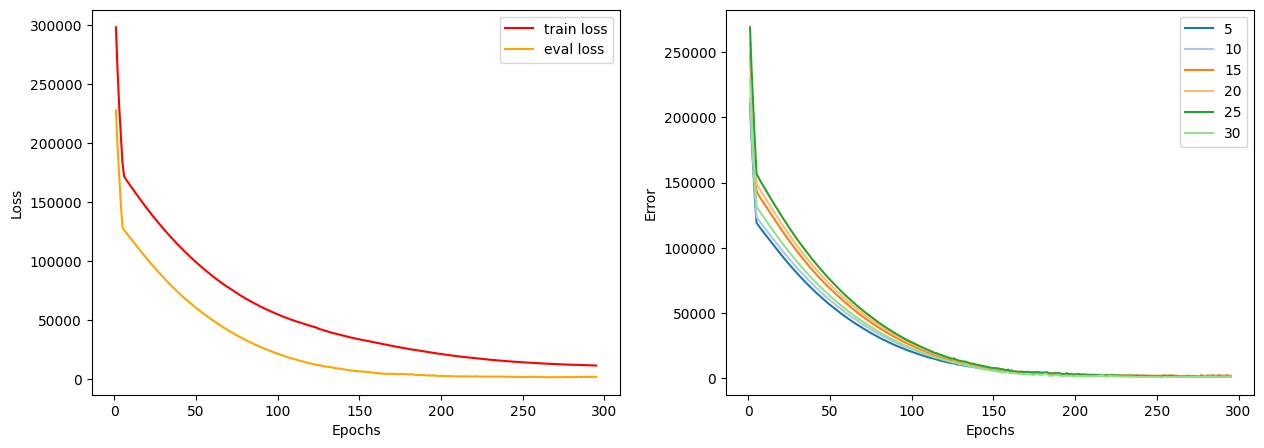

In [ ]:
learning_rates = [0.01]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 2, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 32, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 600, 'early_stopping' : 30, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
  #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
  #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
  #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"04/04/2024, 07:58:22",2009,894,1236,0.05,32,2,16,./Models/mamba_model_bird_dm8nl2ds16dc4rs42bs3...,"[VIS_bird_20231116-20636_20231116-082324.json,...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[291574.09801136365, 255982.78941761365, 22666...","[229681.61830357142, 198624.72433035713, 17256...","{5: [tensor(206164.3125), tensor(178804.3281),...","{5: tensor(2009.7250), 10: tensor(894.1389), 1..."
1,"04/04/2024, 08:32:41",1630,1436,1515,0.01,32,2,16,./Models/mamba_model_bird_dm8nl2ds16dc4rs42bs3...,"[VIS_bird_20231116-20636_20231116-082324.json,...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[298195.3572443182, 261412.27272727274, 231447...","[227804.97433035713, 196908.66517857142, 17276...","{5: [tensor(210664.8750), tensor(182565.8594),...","{5: tensor(1630.2894), 10: tensor(1436.7819), ..."


In [ ]:
results_path = './Mamba Training Results/mamba_training_results_split0.2_' + samples_config['subfolder']  + date_time_

with open(results_path , 'wb') as f:
  pickle.dump(exp_record, f)

100%|██████████| 16/16 [00:01<00:00, 15.69it/s]


epoch 0: train loss = 343001.5699013158, eval loss = 269150.3154296875


100%|██████████| 16/16 [00:00<00:00, 18.56it/s]


epoch 1: train loss = 324189.13404605264, eval loss = 261525.548828125


100%|██████████| 16/16 [00:00<00:00, 18.58it/s]


epoch 2: train loss = 306021.7919407895, eval loss = 256139.5791015625


100%|██████████| 16/16 [00:01<00:00, 15.92it/s]


epoch 3: train loss = 289006.0394736842, eval loss = 246090.29296875


100%|██████████| 16/16 [00:00<00:00, 19.14it/s]


epoch 4: train loss = 273774.8643092105, eval loss = 238481.0107421875


100%|██████████| 16/16 [00:01<00:00, 14.16it/s]


epoch 5: train loss = 259849.5978618421, eval loss = 228288.875


100%|██████████| 16/16 [00:00<00:00, 19.01it/s]


epoch 6: train loss = 247064.2261513158, eval loss = 219675.1396484375


100%|██████████| 16/16 [00:00<00:00, 19.22it/s]


epoch 7: train loss = 234588.94983552632, eval loss = 214498.681640625


100%|██████████| 16/16 [00:00<00:00, 18.80it/s]


epoch 8: train loss = 222673.80674342104, eval loss = 208695.251953125


100%|██████████| 16/16 [00:00<00:00, 19.04it/s]


epoch 9: train loss = 211327.6640625, eval loss = 202021.7412109375


100%|██████████| 16/16 [00:01<00:00, 13.57it/s]


epoch 10: train loss = 200671.14679276315, eval loss = 195099.7705078125


100%|██████████| 16/16 [00:01<00:00, 14.71it/s]


epoch 11: train loss = 190310.51398026315, eval loss = 187501.6298828125


100%|██████████| 16/16 [00:00<00:00, 19.31it/s]


epoch 12: train loss = 180576.74917763157, eval loss = 182902.734375


100%|██████████| 16/16 [00:00<00:00, 19.36it/s]


epoch 13: train loss = 171298.03207236843, eval loss = 176443.259765625


100%|██████████| 16/16 [00:00<00:00, 18.76it/s]


epoch 14: train loss = 162225.52796052632, eval loss = 171551.0888671875


100%|██████████| 16/16 [00:01<00:00, 12.16it/s]


epoch 15: train loss = 153781.7265625, eval loss = 165381.8623046875


100%|██████████| 16/16 [00:00<00:00, 18.89it/s]


epoch 16: train loss = 145688.15625, eval loss = 160334.50732421875


100%|██████████| 16/16 [00:00<00:00, 18.52it/s]


epoch 17: train loss = 137965.1167763158, eval loss = 154992.57373046875


100%|██████████| 16/16 [00:00<00:00, 19.32it/s]


epoch 18: train loss = 130659.75740131579, eval loss = 149815.78662109375


100%|██████████| 16/16 [00:00<00:00, 19.30it/s]


epoch 19: train loss = 123706.35279605263, eval loss = 145364.2841796875


100%|██████████| 16/16 [00:01<00:00, 12.15it/s]


epoch 20: train loss = 117030.40625, eval loss = 140383.3759765625


100%|██████████| 16/16 [00:00<00:00, 19.13it/s]


epoch 21: train loss = 110719.88486842105, eval loss = 134812.45849609375


100%|██████████| 16/16 [00:00<00:00, 18.59it/s]


epoch 22: train loss = 104773.20847039473, eval loss = 130646.64208984375


100%|██████████| 16/16 [00:00<00:00, 18.93it/s]


epoch 23: train loss = 99133.90419407895, eval loss = 124625.7197265625


100%|██████████| 16/16 [00:00<00:00, 19.00it/s]


epoch 24: train loss = 93770.03022203948, eval loss = 119888.63671875


100%|██████████| 16/16 [00:01<00:00, 13.10it/s]


epoch 25: train loss = 88680.05736019737, eval loss = 115878.44140625


100%|██████████| 16/16 [00:00<00:00, 18.19it/s]


epoch 26: train loss = 83881.79749177632, eval loss = 111902.2265625


100%|██████████| 16/16 [00:00<00:00, 19.49it/s]


epoch 27: train loss = 79365.03659539473, eval loss = 108395.6337890625


100%|██████████| 16/16 [00:00<00:00, 19.17it/s]


epoch 28: train loss = 75063.5939555921, eval loss = 104432.330078125


100%|██████████| 16/16 [00:00<00:00, 19.21it/s]


epoch 29: train loss = 70998.91899671052, eval loss = 101372.1025390625


100%|██████████| 16/16 [00:01<00:00, 12.11it/s]


epoch 30: train loss = 67193.32606907895, eval loss = 98201.5654296875


100%|██████████| 16/16 [00:00<00:00, 18.82it/s]


epoch 31: train loss = 63597.33758223684, eval loss = 96141.21826171875


100%|██████████| 16/16 [00:00<00:00, 18.92it/s]


epoch 32: train loss = 60170.94418174342, eval loss = 92592.65234375


100%|██████████| 16/16 [00:00<00:00, 19.36it/s]


epoch 33: train loss = 56956.88106496711, eval loss = 89609.84106445312


100%|██████████| 16/16 [00:00<00:00, 19.85it/s]


epoch 34: train loss = 53988.03587582237, eval loss = 86941.48999023438


100%|██████████| 16/16 [00:01<00:00, 13.30it/s]


epoch 35: train loss = 51180.57154605263, eval loss = 84384.09912109375


100%|██████████| 16/16 [00:00<00:00, 18.68it/s]


epoch 36: train loss = 48483.87027138158, eval loss = 82021.62280273438


100%|██████████| 16/16 [00:00<00:00, 19.18it/s]


epoch 37: train loss = 46038.32473273026, eval loss = 79807.10473632812


100%|██████████| 16/16 [00:00<00:00, 18.94it/s]


epoch 38: train loss = 43678.20024671053, eval loss = 77269.8857421875


100%|██████████| 16/16 [00:00<00:00, 19.51it/s]


epoch 39: train loss = 41495.62376644737, eval loss = 75336.92944335938


100%|██████████| 16/16 [00:01<00:00, 13.30it/s]


epoch 40: train loss = 39451.24177631579, eval loss = 73384.96655273438


100%|██████████| 16/16 [00:00<00:00, 19.23it/s]


epoch 41: train loss = 37529.24609375, eval loss = 71477.18090820312


100%|██████████| 16/16 [00:00<00:00, 19.42it/s]


epoch 42: train loss = 35670.85228207237, eval loss = 69419.88012695312


100%|██████████| 16/16 [00:00<00:00, 18.70it/s]


epoch 43: train loss = 33943.34493215461, eval loss = 67068.3486328125


100%|██████████| 16/16 [00:00<00:00, 19.05it/s]


epoch 44: train loss = 32369.605674342107, eval loss = 65317.7392578125


100%|██████████| 16/16 [00:01<00:00, 12.62it/s]


epoch 45: train loss = 30911.263877467107, eval loss = 63615.908935546875


100%|██████████| 16/16 [00:00<00:00, 19.03it/s]


epoch 46: train loss = 29531.67300575658, eval loss = 62034.202392578125


100%|██████████| 16/16 [00:00<00:00, 19.21it/s]


epoch 47: train loss = 28290.266293174343, eval loss = 60689.377685546875


100%|██████████| 16/16 [00:00<00:00, 18.70it/s]


epoch 48: train loss = 27141.31070106908, eval loss = 59402.46044921875


100%|██████████| 16/16 [00:00<00:00, 18.94it/s]


epoch 49: train loss = 26053.809775904607, eval loss = 58131.81396484375


100%|██████████| 16/16 [00:01<00:00, 12.84it/s]


epoch 50: train loss = 25016.964381167763, eval loss = 57372.90856933594


100%|██████████| 16/16 [00:00<00:00, 19.36it/s]


epoch 51: train loss = 24023.003032483553, eval loss = 56627.55920410156


100%|██████████| 16/16 [00:00<00:00, 19.21it/s]


epoch 52: train loss = 23140.810032894737, eval loss = 55521.41906738281


100%|██████████| 16/16 [00:00<00:00, 19.13it/s]


epoch 53: train loss = 22330.517372532893, eval loss = 55386.94616699219


100%|██████████| 16/16 [00:00<00:00, 18.96it/s]


epoch 54: train loss = 21572.639545641447, eval loss = 54148.28161621094


100%|██████████| 16/16 [00:01<00:00, 13.01it/s]


epoch 55: train loss = 20845.381887335527, eval loss = 53608.525146484375


100%|██████████| 16/16 [00:00<00:00, 19.45it/s]


epoch 56: train loss = 20124.46232524671, eval loss = 52056.24987792969


100%|██████████| 16/16 [00:00<00:00, 18.79it/s]


epoch 57: train loss = 19469.547645970393, eval loss = 52091.43835449219


100%|██████████| 16/16 [00:00<00:00, 19.26it/s]


epoch 58: train loss = 18837.117727179277, eval loss = 50333.499267578125


100%|██████████| 16/16 [00:00<00:00, 19.44it/s]


epoch 59: train loss = 18290.925344366777, eval loss = 50094.897705078125


100%|██████████| 16/16 [00:01<00:00, 13.03it/s]


epoch 60: train loss = 17853.60107421875, eval loss = 49271.654052734375


100%|██████████| 16/16 [00:00<00:00, 19.08it/s]


epoch 61: train loss = 17299.737587376643, eval loss = 50341.65295410156


100%|██████████| 16/16 [00:00<00:00, 18.86it/s]


epoch 62: train loss = 17071.453510485197, eval loss = 48251.98425292969


100%|██████████| 16/16 [00:00<00:00, 19.09it/s]


epoch 63: train loss = 16350.55070415296, eval loss = 48206.759521484375


100%|██████████| 16/16 [00:00<00:00, 18.57it/s]


epoch 64: train loss = 15690.782457853618, eval loss = 49956.2939453125


100%|██████████| 16/16 [00:01<00:00, 12.84it/s]


epoch 65: train loss = 15139.466745476973, eval loss = 51148.899169921875


100%|██████████| 16/16 [00:00<00:00, 19.27it/s]


epoch 66: train loss = 14682.05720600329, eval loss = 52662.93444824219


100%|██████████| 16/16 [00:00<00:00, 19.26it/s]


epoch 67: train loss = 14040.830874794408, eval loss = 50201.22705078125


100%|██████████| 16/16 [00:00<00:00, 18.97it/s]


epoch 68: train loss = 13477.258763363487, eval loss = 48935.54541015625


100%|██████████| 16/16 [00:00<00:00, 19.33it/s]


epoch 69: train loss = 13035.764005962172, eval loss = 49138.730712890625


100%|██████████| 16/16 [00:01<00:00, 13.22it/s]


epoch 70: train loss = 12483.743472450658, eval loss = 46881.70422363281


100%|██████████| 16/16 [00:00<00:00, 19.19it/s]


epoch 71: train loss = 11974.927631578947, eval loss = 45868.65637207031


100%|██████████| 16/16 [00:00<00:00, 18.88it/s]


epoch 72: train loss = 11594.496427837172, eval loss = 43944.32873535156


100%|██████████| 16/16 [00:00<00:00, 19.35it/s]


epoch 73: train loss = 11205.22468647204, eval loss = 43890.51647949219


100%|██████████| 16/16 [00:00<00:00, 18.81it/s]


epoch 74: train loss = 10698.855263157895, eval loss = 43106.89587402344


100%|██████████| 16/16 [00:01<00:00, 13.30it/s]


epoch 75: train loss = 10319.372237356085, eval loss = 42524.078369140625


100%|██████████| 16/16 [00:00<00:00, 18.47it/s]


epoch 76: train loss = 9980.961747018915, eval loss = 41663.09313964844


100%|██████████| 16/16 [00:00<00:00, 19.10it/s]


epoch 77: train loss = 9635.771214535362, eval loss = 41742.3720703125


100%|██████████| 16/16 [00:00<00:00, 19.18it/s]


epoch 78: train loss = 9300.058850740132, eval loss = 40802.48962402344


100%|██████████| 16/16 [00:00<00:00, 19.05it/s]


epoch 79: train loss = 8990.775673314145, eval loss = 40176.27185058594


100%|██████████| 16/16 [00:01<00:00, 13.01it/s]


epoch 80: train loss = 8719.483308490953, eval loss = 40320.66418457031


100%|██████████| 16/16 [00:00<00:00, 19.14it/s]


epoch 81: train loss = 8434.16999897204, eval loss = 39904.788146972656


100%|██████████| 16/16 [00:00<00:00, 18.76it/s]


epoch 82: train loss = 8166.446019222862, eval loss = 39713.09338378906


100%|██████████| 16/16 [00:00<00:00, 19.07it/s]


epoch 83: train loss = 7953.32373046875, eval loss = 39327.526123046875


100%|██████████| 16/16 [00:00<00:00, 18.91it/s]


epoch 84: train loss = 7809.60054738898, eval loss = 39289.11407470703


100%|██████████| 16/16 [00:01<00:00, 13.12it/s]


epoch 85: train loss = 7609.328112150493, eval loss = 40040.67272949219


100%|██████████| 16/16 [00:00<00:00, 19.34it/s]


epoch 86: train loss = 7273.830553556743, eval loss = 39496.498107910156


100%|██████████| 16/16 [00:00<00:00, 18.50it/s]


epoch 87: train loss = 7182.8757966694075, eval loss = 40792.498291015625


100%|██████████| 16/16 [00:00<00:00, 19.07it/s]


epoch 88: train loss = 6866.223915501645, eval loss = 40792.388671875


100%|██████████| 16/16 [00:00<00:00, 18.95it/s]


epoch 89: train loss = 6526.483976665296, eval loss = 39222.745361328125


100%|██████████| 16/16 [00:01<00:00, 13.22it/s]


epoch 90: train loss = 6323.109773334704, eval loss = 39042.023681640625


100%|██████████| 16/16 [00:00<00:00, 18.89it/s]


epoch 91: train loss = 6087.3717041015625, eval loss = 38798.408447265625


100%|██████████| 16/16 [00:00<00:00, 18.82it/s]


epoch 92: train loss = 5933.899439761513, eval loss = 38413.86456298828


100%|██████████| 16/16 [00:00<00:00, 18.80it/s]


epoch 93: train loss = 5872.946340460527, eval loss = 38218.96496582031


100%|██████████| 16/16 [00:00<00:00, 18.46it/s]


epoch 94: train loss = 5686.58744089227, eval loss = 38345.846923828125


100%|██████████| 16/16 [00:01<00:00, 12.22it/s]


epoch 95: train loss = 5532.2606201171875, eval loss = 38652.22741699219


100%|██████████| 16/16 [00:00<00:00, 18.37it/s]


epoch 96: train loss = 5264.890111019737, eval loss = 37997.15051269531


100%|██████████| 16/16 [00:00<00:00, 19.21it/s]


epoch 97: train loss = 5056.92476613898, eval loss = 37765.343017578125


100%|██████████| 16/16 [00:00<00:00, 19.17it/s]


epoch 98: train loss = 4896.488737407483, eval loss = 36944.122131347656


100%|██████████| 16/16 [00:00<00:00, 18.06it/s]


epoch 99: train loss = 4774.1752094469575, eval loss = 36617.74932861328


100%|██████████| 16/16 [00:01<00:00, 12.37it/s]


epoch 100: train loss = 4615.1504934210525, eval loss = 35983.44519042969


100%|██████████| 16/16 [00:00<00:00, 18.74it/s]


epoch 101: train loss = 4484.978059467517, eval loss = 36102.02819824219


100%|██████████| 16/16 [00:00<00:00, 19.05it/s]


epoch 102: train loss = 4339.4847604851975, eval loss = 35930.77331542969


100%|██████████| 16/16 [00:00<00:00, 19.35it/s]


epoch 103: train loss = 4227.483655427632, eval loss = 36104.97106933594


100%|██████████| 16/16 [00:00<00:00, 19.30it/s]


epoch 104: train loss = 4113.275641190378, eval loss = 36370.931884765625


100%|██████████| 16/16 [00:01<00:00, 12.54it/s]


epoch 105: train loss = 4006.9966719777963, eval loss = 36520.1240234375


100%|██████████| 16/16 [00:00<00:00, 19.05it/s]


epoch 106: train loss = 3878.4120836759867, eval loss = 36287.83361816406


100%|██████████| 16/16 [00:00<00:00, 19.23it/s]


epoch 107: train loss = 3807.318584241365, eval loss = 36250.443603515625


100%|██████████| 16/16 [00:00<00:00, 19.02it/s]


epoch 108: train loss = 3711.8975637335525, eval loss = 35781.455505371094


100%|██████████| 16/16 [00:00<00:00, 18.32it/s]


epoch 109: train loss = 3557.4447728207238, eval loss = 36053.757568359375


100%|██████████| 16/16 [00:01<00:00, 13.21it/s]


epoch 110: train loss = 3471.4973819130346, eval loss = 34652.091064453125


100%|██████████| 16/16 [00:00<00:00, 18.94it/s]


epoch 111: train loss = 3387.617059004934, eval loss = 35668.92126464844


100%|██████████| 16/16 [00:00<00:00, 19.48it/s]


epoch 112: train loss = 3260.0695190429688, eval loss = 35535.389892578125


100%|██████████| 16/16 [00:00<00:00, 18.46it/s]


epoch 113: train loss = 3158.612747995477, eval loss = 36303.58660888672


100%|██████████| 16/16 [00:00<00:00, 19.04it/s]


epoch 114: train loss = 3070.9291606702304, eval loss = 35580.41473388672


100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


epoch 115: train loss = 2992.4640535053454, eval loss = 36342.038635253906


100%|██████████| 16/16 [00:00<00:00, 19.25it/s]


epoch 116: train loss = 2933.2329711914062, eval loss = 35449.16516113281


100%|██████████| 16/16 [00:00<00:00, 19.23it/s]


epoch 117: train loss = 2885.927181846217, eval loss = 36020.292419433594


100%|██████████| 16/16 [00:00<00:00, 19.07it/s]


epoch 118: train loss = 2798.583126670436, eval loss = 35632.974365234375

Early stoping after 118 epochs. eval loss did not imporve for more than 8 epochs

Finished Training:
Best metrics are:
Best loss = 39856.33984375
Best train loss = 3471.4973819130346
Best eval loss = 34652.091064453125
Best 5sec eval = 41891.68359375
Best 10sec eval = 39856.33984375
Best 15sec eval = 28388.46875
Best 20sec eval = 46313.76953125
Best 25sec eval = 39694.26953125
Best 30sec eval = 95177.21875


100%|██████████| 16/16 [00:00<00:00, 18.79it/s]


epoch 0: train loss = 328463.2236842105, eval loss = 305716.564453125


100%|██████████| 16/16 [00:01<00:00, 12.88it/s]


epoch 1: train loss = 322033.2602796053, eval loss = 302454.0517578125


100%|██████████| 16/16 [00:00<00:00, 18.52it/s]


epoch 2: train loss = 316977.4679276316, eval loss = 299985.271484375


100%|██████████| 16/16 [00:00<00:00, 19.05it/s]


epoch 3: train loss = 313305.1023848684, eval loss = 297827.830078125


100%|██████████| 16/16 [00:00<00:00, 18.62it/s]


epoch 4: train loss = 310186.3404605263, eval loss = 295559.17578125


100%|██████████| 16/16 [00:00<00:00, 19.00it/s]


epoch 5: train loss = 307009.5242598684, eval loss = 293012.13671875


100%|██████████| 16/16 [00:01<00:00, 12.70it/s]


epoch 6: train loss = 303381.03248355264, eval loss = 290690.7275390625


100%|██████████| 16/16 [00:00<00:00, 18.88it/s]


epoch 7: train loss = 299745.3330592105, eval loss = 288917.6669921875


100%|██████████| 16/16 [00:00<00:00, 18.80it/s]


epoch 8: train loss = 296065.15501644736, eval loss = 288239.041015625


100%|██████████| 16/16 [00:00<00:00, 19.33it/s]


epoch 9: train loss = 292381.32154605264, eval loss = 286945.7744140625


100%|██████████| 16/16 [00:00<00:00, 18.87it/s]


epoch 10: train loss = 288767.4453125, eval loss = 285120.591796875


100%|██████████| 16/16 [00:01<00:00, 13.20it/s]


epoch 11: train loss = 285246.5649671053, eval loss = 284402.53125


100%|██████████| 16/16 [00:00<00:00, 19.29it/s]


epoch 12: train loss = 281727.4115953947, eval loss = 283181.7431640625


100%|██████████| 16/16 [00:00<00:00, 18.79it/s]


epoch 13: train loss = 278295.0365953947, eval loss = 281575.6259765625


100%|██████████| 16/16 [00:00<00:00, 19.03it/s]


epoch 14: train loss = 275043.0382401316, eval loss = 280309.80859375


100%|██████████| 16/16 [00:00<00:00, 19.10it/s]


epoch 15: train loss = 271964.5106907895, eval loss = 278603.8818359375


100%|██████████| 16/16 [00:01<00:00, 13.22it/s]


epoch 16: train loss = 268976.2413651316, eval loss = 277186.3115234375


100%|██████████| 16/16 [00:00<00:00, 19.46it/s]


epoch 17: train loss = 266067.7960526316, eval loss = 275897.11328125


100%|██████████| 16/16 [00:00<00:00, 18.98it/s]


epoch 18: train loss = 263209.5102796053, eval loss = 275072.6708984375


100%|██████████| 16/16 [00:00<00:00, 18.99it/s]


epoch 19: train loss = 260414.41488486843, eval loss = 272511.951171875


100%|██████████| 16/16 [00:00<00:00, 19.26it/s]


epoch 20: train loss = 257663.78248355264, eval loss = 271117.3955078125


100%|██████████| 16/16 [00:01<00:00, 13.45it/s]


epoch 21: train loss = 254985.10402960525, eval loss = 267632.22265625


100%|██████████| 16/16 [00:00<00:00, 18.99it/s]


epoch 22: train loss = 252314.77796052632, eval loss = 265761.4951171875


100%|██████████| 16/16 [00:00<00:00, 19.10it/s]


epoch 23: train loss = 249705.52837171053, eval loss = 264616.6171875


100%|██████████| 16/16 [00:00<00:00, 19.37it/s]


epoch 24: train loss = 247117.56332236843, eval loss = 262107.7822265625


100%|██████████| 16/16 [00:00<00:00, 19.64it/s]


epoch 25: train loss = 244575.41735197368, eval loss = 259698.2294921875


100%|██████████| 16/16 [00:01<00:00, 13.27it/s]


epoch 26: train loss = 242056.20024671053, eval loss = 258235.4169921875


100%|██████████| 16/16 [00:00<00:00, 18.69it/s]


epoch 27: train loss = 239597.05797697368, eval loss = 255436.3251953125


100%|██████████| 16/16 [00:00<00:00, 19.10it/s]


epoch 28: train loss = 237115.17393092104, eval loss = 253890.904296875


100%|██████████| 16/16 [00:00<00:00, 18.35it/s]


epoch 29: train loss = 234698.171875, eval loss = 252360.552734375


100%|██████████| 16/16 [00:00<00:00, 18.44it/s]


epoch 30: train loss = 232297.35402960525, eval loss = 249470.0


100%|██████████| 16/16 [00:01<00:00, 13.26it/s]


epoch 31: train loss = 229890.12952302632, eval loss = 247982.2578125


100%|██████████| 16/16 [00:00<00:00, 18.89it/s]


epoch 32: train loss = 227533.24157072368, eval loss = 246298.7587890625


100%|██████████| 16/16 [00:00<00:00, 19.17it/s]


epoch 33: train loss = 225209.38918585525, eval loss = 244096.83203125


100%|██████████| 16/16 [00:00<00:00, 19.14it/s]


epoch 34: train loss = 222920.61636513157, eval loss = 242309.962890625


100%|██████████| 16/16 [00:00<00:00, 18.97it/s]


epoch 35: train loss = 220756.21936677632, eval loss = 239775.892578125


100%|██████████| 16/16 [00:01<00:00, 13.17it/s]


epoch 36: train loss = 218350.70826480264, eval loss = 238466.7353515625


100%|██████████| 16/16 [00:00<00:00, 19.14it/s]


epoch 37: train loss = 216108.24054276315, eval loss = 236592.287109375


100%|██████████| 16/16 [00:00<00:00, 19.20it/s]


epoch 38: train loss = 213941.37623355264, eval loss = 234407.208984375


100%|██████████| 16/16 [00:00<00:00, 19.20it/s]


epoch 39: train loss = 211693.31743421053, eval loss = 232715.416015625


100%|██████████| 16/16 [00:00<00:00, 19.29it/s]


epoch 40: train loss = 209511.85793585525, eval loss = 231107.0


100%|██████████| 16/16 [00:01<00:00, 12.96it/s]


epoch 41: train loss = 207379.40830592104, eval loss = 229179.693359375


100%|██████████| 16/16 [00:00<00:00, 18.55it/s]


epoch 42: train loss = 205270.73170230264, eval loss = 227227.1005859375


100%|██████████| 16/16 [00:00<00:00, 18.86it/s]


epoch 43: train loss = 203102.7183388158, eval loss = 225716.900390625


100%|██████████| 16/16 [00:00<00:00, 19.11it/s]


epoch 44: train loss = 201027.5433799342, eval loss = 224163.796875


100%|██████████| 16/16 [00:00<00:00, 19.37it/s]


epoch 45: train loss = 198954.7261513158, eval loss = 222229.673828125


100%|██████████| 16/16 [00:01<00:00, 13.32it/s]


epoch 46: train loss = 196930.17249177632, eval loss = 220254.4306640625


100%|██████████| 16/16 [00:00<00:00, 18.56it/s]


epoch 47: train loss = 194829.08922697368, eval loss = 218740.83203125


100%|██████████| 16/16 [00:00<00:00, 18.73it/s]


epoch 48: train loss = 192850.8595805921, eval loss = 217247.6435546875


100%|██████████| 16/16 [00:00<00:00, 18.45it/s]


epoch 49: train loss = 190841.2576069079, eval loss = 215240.232421875


100%|██████████| 16/16 [00:00<00:00, 18.86it/s]


epoch 50: train loss = 188875.1134868421, eval loss = 213377.66015625


100%|██████████| 16/16 [00:01<00:00, 13.70it/s]


epoch 51: train loss = 186876.6955180921, eval loss = 212202.2666015625


100%|██████████| 16/16 [00:00<00:00, 19.51it/s]


epoch 52: train loss = 184915.41940789475, eval loss = 210431.2001953125


100%|██████████| 16/16 [00:00<00:00, 19.13it/s]


epoch 53: train loss = 183015.90337171053, eval loss = 208764.8818359375


100%|██████████| 16/16 [00:00<00:00, 18.88it/s]


epoch 54: train loss = 181076.93667763157, eval loss = 207630.2802734375


100%|██████████| 16/16 [00:00<00:00, 18.50it/s]


epoch 55: train loss = 179192.60773026315, eval loss = 205807.5966796875


100%|██████████| 16/16 [00:01<00:00, 14.13it/s]


epoch 56: train loss = 177255.41467927632, eval loss = 204566.48828125


100%|██████████| 16/16 [00:00<00:00, 18.92it/s]


epoch 57: train loss = 175392.10546875, eval loss = 202946.0400390625


100%|██████████| 16/16 [00:00<00:00, 19.16it/s]


epoch 58: train loss = 173566.11122532896, eval loss = 201651.431640625


100%|██████████| 16/16 [00:00<00:00, 18.97it/s]


epoch 59: train loss = 171711.6675575658, eval loss = 200109.482421875


100%|██████████| 16/16 [00:00<00:00, 19.15it/s]


epoch 60: train loss = 169902.93688322368, eval loss = 198932.5029296875


100%|██████████| 16/16 [00:01<00:00, 15.30it/s]


epoch 61: train loss = 168097.16097861843, eval loss = 197265.8486328125


100%|██████████| 16/16 [00:00<00:00, 18.62it/s]


epoch 62: train loss = 166312.59107730264, eval loss = 196432.15625


100%|██████████| 16/16 [00:00<00:00, 18.85it/s]


epoch 63: train loss = 164554.08347039475, eval loss = 194431.2626953125


100%|██████████| 16/16 [00:00<00:00, 16.48it/s]


epoch 64: train loss = 162790.82421875, eval loss = 194139.4521484375


100%|██████████| 16/16 [00:00<00:00, 18.75it/s]


epoch 65: train loss = 161058.36204769736, eval loss = 191772.7724609375


100%|██████████| 16/16 [00:00<00:00, 16.18it/s]


epoch 66: train loss = 159345.81476151315, eval loss = 190885.4619140625


100%|██████████| 16/16 [00:00<00:00, 18.78it/s]


epoch 67: train loss = 157630.17742598685, eval loss = 190135.6279296875


100%|██████████| 16/16 [00:00<00:00, 19.09it/s]


epoch 68: train loss = 155944.52816611843, eval loss = 188177.2197265625


100%|██████████| 16/16 [00:00<00:00, 16.33it/s]


epoch 69: train loss = 154274.3205180921, eval loss = 187866.517578125


100%|██████████| 16/16 [00:00<00:00, 18.87it/s]


epoch 70: train loss = 152610.5197368421, eval loss = 185709.8017578125


100%|██████████| 16/16 [00:00<00:00, 16.02it/s]


epoch 71: train loss = 150972.3244243421, eval loss = 185525.0634765625


100%|██████████| 16/16 [00:00<00:00, 18.88it/s]


epoch 72: train loss = 149343.14699835525, eval loss = 183526.404296875


100%|██████████| 16/16 [00:00<00:00, 19.03it/s]


epoch 73: train loss = 147721.3277138158, eval loss = 183446.08984375


100%|██████████| 16/16 [00:01<00:00, 14.97it/s]


epoch 74: train loss = 146124.88569078947, eval loss = 181258.763671875


100%|██████████| 16/16 [00:00<00:00, 19.25it/s]


epoch 75: train loss = 144540.30016447368, eval loss = 180910.3525390625


100%|██████████| 16/16 [00:00<00:00, 17.87it/s]


epoch 76: train loss = 142962.77590460525, eval loss = 179683.66796875


100%|██████████| 16/16 [00:00<00:00, 18.38it/s]


epoch 77: train loss = 141409.08388157896, eval loss = 178979.3984375


100%|██████████| 16/16 [00:00<00:00, 19.60it/s]


epoch 78: train loss = 139866.13538240132, eval loss = 177483.3095703125


100%|██████████| 16/16 [00:01<00:00, 13.01it/s]


epoch 79: train loss = 138337.42865953947, eval loss = 177418.4697265625


100%|██████████| 16/16 [00:00<00:00, 19.39it/s]


epoch 80: train loss = 136819.36420641447, eval loss = 175180.4091796875


100%|██████████| 16/16 [00:00<00:00, 18.81it/s]


epoch 81: train loss = 135329.02590460525, eval loss = 175168.11328125


100%|██████████| 16/16 [00:00<00:00, 18.82it/s]


epoch 82: train loss = 133838.21946957236, eval loss = 173963.63671875


100%|██████████| 16/16 [00:00<00:00, 18.44it/s]


epoch 83: train loss = 132347.1111225329, eval loss = 173271.0849609375


100%|██████████| 16/16 [00:01<00:00, 12.46it/s]


epoch 84: train loss = 130905.92804276316, eval loss = 171724.4384765625


100%|██████████| 16/16 [00:00<00:00, 18.71it/s]


epoch 85: train loss = 129451.50791529605, eval loss = 171846.8193359375


100%|██████████| 16/16 [00:00<00:00, 19.23it/s]


epoch 86: train loss = 128005.20045230263, eval loss = 169428.796875


100%|██████████| 16/16 [00:00<00:00, 19.35it/s]


epoch 87: train loss = 126614.599609375, eval loss = 169682.841796875


100%|██████████| 16/16 [00:00<00:00, 18.85it/s]


epoch 88: train loss = 125192.57288240132, eval loss = 168879.0322265625


100%|██████████| 16/16 [00:01<00:00, 12.47it/s]


epoch 89: train loss = 123779.72759046052, eval loss = 167867.32373046875


100%|██████████| 16/16 [00:00<00:00, 18.42it/s]


epoch 90: train loss = 122421.26480263157, eval loss = 167153.2802734375


100%|██████████| 16/16 [00:00<00:00, 18.24it/s]


epoch 91: train loss = 121040.27621299343, eval loss = 166596.7119140625


100%|██████████| 16/16 [00:00<00:00, 18.84it/s]


epoch 92: train loss = 119667.23375822368, eval loss = 165119.345703125


100%|██████████| 16/16 [00:00<00:00, 19.02it/s]


epoch 93: train loss = 118342.39525082237, eval loss = 165148.4091796875


100%|██████████| 16/16 [00:01<00:00, 12.04it/s]


epoch 94: train loss = 117004.97142269737, eval loss = 162653.8046875


100%|██████████| 16/16 [00:00<00:00, 18.38it/s]


epoch 95: train loss = 115682.45261101973, eval loss = 162736.4951171875


100%|██████████| 16/16 [00:00<00:00, 18.64it/s]


epoch 96: train loss = 114376.42002467105, eval loss = 163175.8154296875


100%|██████████| 16/16 [00:00<00:00, 18.47it/s]


epoch 97: train loss = 113079.13209292763, eval loss = 159946.37109375


100%|██████████| 16/16 [00:00<00:00, 19.00it/s]


epoch 98: train loss = 111811.09272203948, eval loss = 159706.3037109375


100%|██████████| 16/16 [00:01<00:00, 12.27it/s]


epoch 99: train loss = 110533.52014802632, eval loss = 160503.8408203125


100%|██████████| 16/16 [00:00<00:00, 18.93it/s]


epoch 100: train loss = 109263.62397203948, eval loss = 159915.7939453125


100%|██████████| 16/16 [00:00<00:00, 18.98it/s]


epoch 101: train loss = 108032.34837582237, eval loss = 157228.31103515625


100%|██████████| 16/16 [00:00<00:00, 19.19it/s]


epoch 102: train loss = 106793.2091899671, eval loss = 157152.685546875


100%|██████████| 16/16 [00:00<00:00, 18.77it/s]


epoch 103: train loss = 105561.734375, eval loss = 156844.2666015625


100%|██████████| 16/16 [00:01<00:00, 12.43it/s]


epoch 104: train loss = 104363.04019325657, eval loss = 154232.91552734375


100%|██████████| 16/16 [00:00<00:00, 19.42it/s]


epoch 105: train loss = 103162.55520148027, eval loss = 154442.34228515625


100%|██████████| 16/16 [00:00<00:00, 19.25it/s]


epoch 106: train loss = 101968.29574424343, eval loss = 154103.31201171875


100%|██████████| 16/16 [00:00<00:00, 18.67it/s]


epoch 107: train loss = 100799.31877055921, eval loss = 151997.73095703125


100%|██████████| 16/16 [00:00<00:00, 19.13it/s]


epoch 108: train loss = 99635.00740131579, eval loss = 152259.14013671875


100%|██████████| 16/16 [00:01<00:00, 12.18it/s]


epoch 109: train loss = 98475.71587171052, eval loss = 150854.00244140625


100%|██████████| 16/16 [00:00<00:00, 18.88it/s]


epoch 110: train loss = 97339.44562088816, eval loss = 150136.64892578125


100%|██████████| 16/16 [00:00<00:00, 18.83it/s]


epoch 111: train loss = 96205.09858141448, eval loss = 148684.4169921875


100%|██████████| 16/16 [00:00<00:00, 18.66it/s]


epoch 112: train loss = 95079.85454358552, eval loss = 148829.837890625


100%|██████████| 16/16 [00:00<00:00, 18.87it/s]


epoch 113: train loss = 93978.5666118421, eval loss = 146763.41259765625


100%|██████████| 16/16 [00:01<00:00, 12.53it/s]


epoch 114: train loss = 92879.15244654605, eval loss = 146915.91455078125


100%|██████████| 16/16 [00:00<00:00, 19.05it/s]


epoch 115: train loss = 91783.59015213816, eval loss = 145491.119140625


100%|██████████| 16/16 [00:00<00:00, 19.46it/s]


epoch 116: train loss = 90717.65625, eval loss = 145126.93115234375


100%|██████████| 16/16 [00:00<00:00, 19.07it/s]


epoch 117: train loss = 89648.6545024671, eval loss = 143647.986328125


100%|██████████| 16/16 [00:00<00:00, 18.64it/s]


epoch 118: train loss = 88586.70230263157, eval loss = 143503.640625


100%|██████████| 16/16 [00:01<00:00, 12.34it/s]


epoch 119: train loss = 87549.99712171052, eval loss = 141782.6005859375


100%|██████████| 16/16 [00:00<00:00, 18.89it/s]


epoch 120: train loss = 86518.45708264802, eval loss = 141753.2314453125


100%|██████████| 16/16 [00:00<00:00, 18.96it/s]


epoch 121: train loss = 85486.12849506579, eval loss = 140492.833984375


100%|██████████| 16/16 [00:00<00:00, 18.57it/s]


epoch 122: train loss = 84479.31440172698, eval loss = 140210.67724609375


100%|██████████| 16/16 [00:00<00:00, 18.50it/s]


epoch 123: train loss = 83484.2443462171, eval loss = 139030.26513671875


100%|██████████| 16/16 [00:01<00:00, 12.11it/s]


epoch 124: train loss = 82480.5154194079, eval loss = 138865.5390625


100%|██████████| 16/16 [00:00<00:00, 18.44it/s]


epoch 125: train loss = 81497.67202919407, eval loss = 137630.18603515625


100%|██████████| 16/16 [00:00<00:00, 19.06it/s]


epoch 126: train loss = 80544.47825863487, eval loss = 137738.07275390625


100%|██████████| 16/16 [00:00<00:00, 19.03it/s]


epoch 127: train loss = 79567.33383018093, eval loss = 136427.14599609375


100%|██████████| 16/16 [00:00<00:00, 18.25it/s]


epoch 128: train loss = 78612.00406044407, eval loss = 135618.1748046875


100%|██████████| 16/16 [00:01<00:00, 12.49it/s]


epoch 129: train loss = 77689.88877467105, eval loss = 135242.8515625


100%|██████████| 16/16 [00:00<00:00, 18.97it/s]


epoch 130: train loss = 76740.57678865132, eval loss = 134164.71435546875


100%|██████████| 16/16 [00:00<00:00, 18.90it/s]


epoch 131: train loss = 75821.88214432566, eval loss = 132422.484375


100%|██████████| 16/16 [00:00<00:00, 18.86it/s]


epoch 132: train loss = 74911.89149876645, eval loss = 132342.228515625


100%|██████████| 16/16 [00:00<00:00, 18.74it/s]


epoch 133: train loss = 73994.17033305921, eval loss = 130616.7861328125


100%|██████████| 16/16 [00:01<00:00, 11.70it/s]


epoch 134: train loss = 73127.81630345395, eval loss = 130030.60205078125


100%|██████████| 16/16 [00:00<00:00, 18.36it/s]


epoch 135: train loss = 72220.31178042763, eval loss = 129009.06884765625


100%|██████████| 16/16 [00:00<00:00, 18.70it/s]


epoch 136: train loss = 71334.85896381579, eval loss = 127529.8212890625


100%|██████████| 16/16 [00:00<00:00, 19.00it/s]


epoch 137: train loss = 70507.38928865132, eval loss = 127290.37451171875


100%|██████████| 16/16 [00:00<00:00, 18.87it/s]


epoch 138: train loss = 69622.4851459704, eval loss = 125920.7412109375


100%|██████████| 16/16 [00:01<00:00, 12.20it/s]


epoch 139: train loss = 68782.79091282895, eval loss = 124942.06103515625


100%|██████████| 16/16 [00:00<00:00, 19.01it/s]


epoch 140: train loss = 67948.85716488487, eval loss = 124518.6181640625


100%|██████████| 16/16 [00:00<00:00, 18.83it/s]


epoch 141: train loss = 67102.83783922698, eval loss = 122865.45458984375


100%|██████████| 16/16 [00:00<00:00, 18.83it/s]


epoch 142: train loss = 66317.43513569079, eval loss = 122371.28466796875


100%|██████████| 16/16 [00:00<00:00, 18.56it/s]


epoch 143: train loss = 65477.17963610197, eval loss = 120838.02685546875


100%|██████████| 16/16 [00:01<00:00, 12.28it/s]


epoch 144: train loss = 64678.62952302631, eval loss = 119742.8447265625


100%|██████████| 16/16 [00:00<00:00, 18.03it/s]


epoch 145: train loss = 63897.77575041119, eval loss = 119109.98828125


100%|██████████| 16/16 [00:00<00:00, 18.47it/s]


epoch 146: train loss = 63093.24624794408, eval loss = 117385.92529296875


100%|██████████| 16/16 [00:00<00:00, 19.06it/s]


epoch 147: train loss = 62350.39329769737, eval loss = 116972.5400390625


100%|██████████| 16/16 [00:00<00:00, 18.25it/s]


epoch 148: train loss = 61556.78829152961, eval loss = 115453.0712890625


100%|██████████| 16/16 [00:01<00:00, 13.18it/s]


epoch 149: train loss = 60807.13872327303, eval loss = 114719.177734375


100%|██████████| 16/16 [00:00<00:00, 18.62it/s]


epoch 150: train loss = 60061.85844983553, eval loss = 113959.59423828125


100%|██████████| 16/16 [00:00<00:00, 17.12it/s]


epoch 151: train loss = 59305.94634046053, eval loss = 112772.123046875


100%|██████████| 16/16 [00:00<00:00, 19.33it/s]


epoch 152: train loss = 58601.94721422697, eval loss = 112220.54443359375


100%|██████████| 16/16 [00:00<00:00, 19.08it/s]


epoch 153: train loss = 57852.73864103619, eval loss = 110952.42919921875


100%|██████████| 16/16 [00:01<00:00, 14.36it/s]


epoch 154: train loss = 57154.68714021381, eval loss = 110939.51513671875


100%|██████████| 16/16 [00:00<00:00, 18.39it/s]


epoch 155: train loss = 56437.61410361842, eval loss = 109876.78173828125


100%|██████████| 16/16 [00:00<00:00, 16.84it/s]


epoch 156: train loss = 55736.40861430921, eval loss = 109399.74365234375


100%|██████████| 16/16 [00:00<00:00, 18.80it/s]


epoch 157: train loss = 55057.78392269737, eval loss = 108424.14501953125


100%|██████████| 16/16 [00:00<00:00, 18.58it/s]


epoch 158: train loss = 54357.18595805921, eval loss = 107426.13623046875


100%|██████████| 16/16 [00:01<00:00, 14.40it/s]


epoch 159: train loss = 53706.07149465461, eval loss = 106812.6474609375


100%|██████████| 16/16 [00:00<00:00, 18.80it/s]


epoch 160: train loss = 53017.82930715461, eval loss = 106026.6494140625


100%|██████████| 16/16 [00:00<00:00, 18.15it/s]


epoch 161: train loss = 52375.84778474506, eval loss = 105790.51123046875


100%|██████████| 16/16 [00:00<00:00, 18.21it/s]


epoch 162: train loss = 51715.87646484375, eval loss = 105219.9052734375


100%|██████████| 16/16 [00:00<00:00, 18.77it/s]


epoch 163: train loss = 51078.83370168586, eval loss = 103981.1396484375


100%|██████████| 16/16 [00:01<00:00, 14.14it/s]


epoch 164: train loss = 50445.08953536184, eval loss = 103540.216796875


100%|██████████| 16/16 [00:00<00:00, 18.20it/s]


epoch 165: train loss = 49808.75228721217, eval loss = 103115.234375


100%|██████████| 16/16 [00:00<00:00, 18.57it/s]


epoch 166: train loss = 49201.17308285362, eval loss = 102802.57275390625


100%|██████████| 16/16 [00:00<00:00, 18.64it/s]


epoch 167: train loss = 48573.66419099506, eval loss = 102439.041015625


100%|██████████| 16/16 [00:00<00:00, 19.00it/s]


epoch 168: train loss = 47989.61253597862, eval loss = 101497.3798828125


100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


epoch 169: train loss = 47370.71764494244, eval loss = 100233.3125


100%|██████████| 16/16 [00:00<00:00, 19.03it/s]


epoch 170: train loss = 46805.44497841283, eval loss = 100592.7275390625


100%|██████████| 16/16 [00:00<00:00, 18.65it/s]


epoch 171: train loss = 46198.61813836349, eval loss = 99423.1396484375


100%|██████████| 16/16 [00:00<00:00, 19.13it/s]


epoch 172: train loss = 45648.31540398849, eval loss = 99560.5341796875


100%|██████████| 16/16 [00:00<00:00, 19.06it/s]


epoch 173: train loss = 45055.72527754934, eval loss = 98903.6630859375


100%|██████████| 16/16 [00:01<00:00, 12.33it/s]


epoch 174: train loss = 44525.93022717928, eval loss = 98486.69482421875


100%|██████████| 16/16 [00:00<00:00, 18.84it/s]


epoch 175: train loss = 43942.48167660362, eval loss = 96471.306640625


100%|██████████| 16/16 [00:00<00:00, 18.03it/s]


epoch 176: train loss = 43434.41069592928, eval loss = 96651.9765625


100%|██████████| 16/16 [00:00<00:00, 18.67it/s]


epoch 177: train loss = 42853.57804790296, eval loss = 94264.828125


100%|██████████| 16/16 [00:00<00:00, 18.26it/s]


epoch 178: train loss = 42363.88898026316, eval loss = 93444.32666015625


100%|██████████| 16/16 [00:01<00:00, 12.62it/s]


epoch 179: train loss = 41794.68639494244, eval loss = 92755.03857421875


100%|██████████| 16/16 [00:00<00:00, 18.86it/s]


epoch 180: train loss = 41319.74912623355, eval loss = 92637.31982421875


100%|██████████| 16/16 [00:00<00:00, 18.86it/s]


epoch 181: train loss = 40767.62808388158, eval loss = 91336.38916015625


100%|██████████| 16/16 [00:00<00:00, 18.80it/s]


epoch 182: train loss = 40298.64579050164, eval loss = 91301.66748046875


100%|██████████| 16/16 [00:00<00:00, 18.57it/s]


epoch 183: train loss = 39771.42069284539, eval loss = 90198.87548828125


100%|██████████| 16/16 [00:01<00:00, 13.07it/s]


epoch 184: train loss = 39301.19012129934, eval loss = 90153.7822265625


100%|██████████| 16/16 [00:00<00:00, 18.97it/s]


epoch 185: train loss = 38805.11752158717, eval loss = 89345.4326171875


100%|██████████| 16/16 [00:00<00:00, 19.08it/s]


epoch 186: train loss = 38340.93022717928, eval loss = 89045.767578125


100%|██████████| 16/16 [00:00<00:00, 19.04it/s]


epoch 187: train loss = 37871.24028577303, eval loss = 88189.61669921875


100%|██████████| 16/16 [00:00<00:00, 18.96it/s]


epoch 188: train loss = 37414.7162057977, eval loss = 87690.6953125


100%|██████████| 16/16 [00:01<00:00, 13.20it/s]


epoch 189: train loss = 36969.30479029605, eval loss = 86120.376953125


100%|██████████| 16/16 [00:00<00:00, 18.60it/s]


epoch 190: train loss = 36541.10662520559, eval loss = 85731.5556640625


100%|██████████| 16/16 [00:00<00:00, 18.90it/s]


epoch 191: train loss = 36132.67847964638, eval loss = 84132.6962890625


100%|██████████| 16/16 [00:00<00:00, 18.52it/s]


epoch 192: train loss = 35724.99311266447, eval loss = 84268.30541992188


100%|██████████| 16/16 [00:00<00:00, 18.67it/s]


epoch 193: train loss = 35230.4253957648, eval loss = 82036.767578125


100%|██████████| 16/16 [00:01<00:00, 13.72it/s]


epoch 194: train loss = 34730.49187911184, eval loss = 81740.69409179688


100%|██████████| 16/16 [00:00<00:00, 18.68it/s]


epoch 195: train loss = 34296.6009714227, eval loss = 81358.81518554688


100%|██████████| 16/16 [00:00<00:00, 16.11it/s]


epoch 196: train loss = 33873.90064761513, eval loss = 80790.62158203125


100%|██████████| 16/16 [00:00<00:00, 19.34it/s]


epoch 197: train loss = 33456.86968030428, eval loss = 79957.4326171875


100%|██████████| 16/16 [00:00<00:00, 18.59it/s]


epoch 198: train loss = 33054.67136101974, eval loss = 79519.7958984375


100%|██████████| 16/16 [00:01<00:00, 14.19it/s]


epoch 199: train loss = 32659.25642475329, eval loss = 78977.1845703125


100%|██████████| 16/16 [00:00<00:00, 17.94it/s]


epoch 200: train loss = 32270.119680304277, eval loss = 78407.16918945312


100%|██████████| 16/16 [00:00<00:00, 16.22it/s]


epoch 201: train loss = 31883.32290810033, eval loss = 77961.69873046875


100%|██████████| 16/16 [00:00<00:00, 18.72it/s]


epoch 202: train loss = 31512.794639185857, eval loss = 72924.28979492188


100%|██████████| 16/16 [00:00<00:00, 18.89it/s]


epoch 203: train loss = 31166.409282483553, eval loss = 73447.35717773438


100%|██████████| 16/16 [00:01<00:00, 15.71it/s]


epoch 204: train loss = 30808.873432360197, eval loss = 74272.38500976562


100%|██████████| 16/16 [00:00<00:00, 18.20it/s]


epoch 205: train loss = 30411.674213610197, eval loss = 74481.09545898438


100%|██████████| 16/16 [00:01<00:00, 14.91it/s]


epoch 206: train loss = 30038.59202816612, eval loss = 73921.24462890625


100%|██████████| 16/16 [00:00<00:00, 18.74it/s]


epoch 207: train loss = 29678.745297080593, eval loss = 74091.42456054688


100%|██████████| 16/16 [00:00<00:00, 18.56it/s]


epoch 208: train loss = 29328.586631373357, eval loss = 73468.89477539062


100%|██████████| 16/16 [00:00<00:00, 16.89it/s]


epoch 209: train loss = 28985.236867804277, eval loss = 73523.42358398438


100%|██████████| 16/16 [00:00<00:00, 18.77it/s]


epoch 210: train loss = 28647.606265419407, eval loss = 73149.69189453125

Early stoping after 210 epochs. eval loss did not imporve for more than 8 epochs

Finished Training:
Best metrics are:
Best loss = 66070.625
Best train loss = 31512.794639185857
Best eval loss = 72924.28979492188
Best 5sec eval = 76431.3203125
Best 10sec eval = 66070.625
Best 15sec eval = 111890.34375
Best 20sec eval = 108845.8046875
Best 25sec eval = 90722.6875
Best 30sec eval = 135617.1875


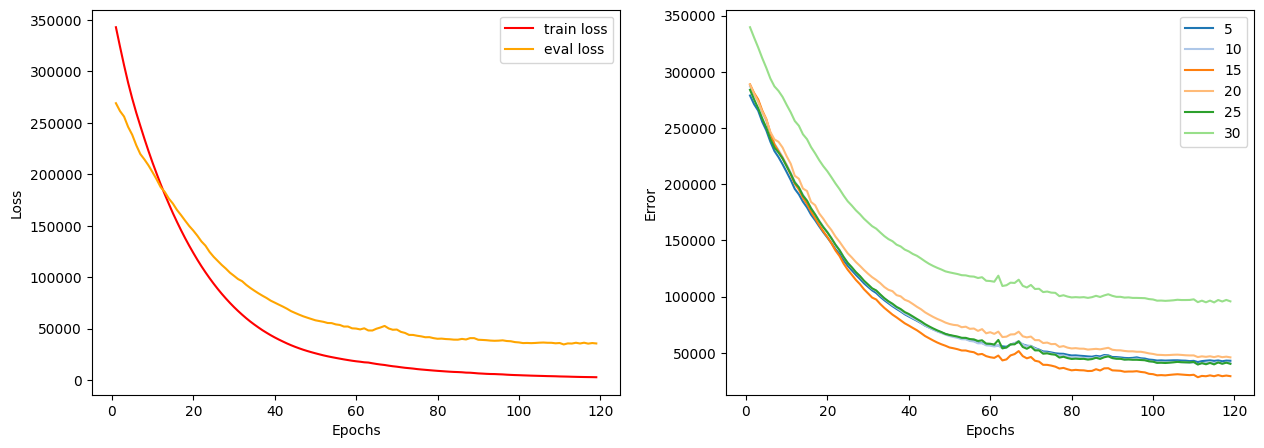

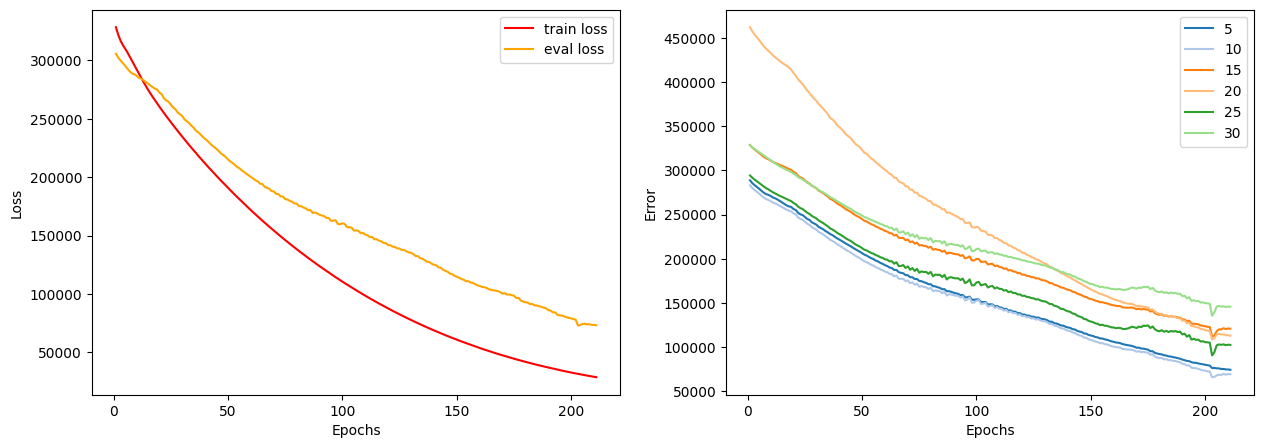

In [ ]:
learning_rates = [0.05, 0.01]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 32, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 600, 'early_stopping' : 8, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
  #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
  #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
  #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"04/03/2024, 11:37:41",55918,43529,69242,0.05,16,1,16,./Models/mamba_model_bird_dm8nl1ds16dc4rs42bs1...,"[VIS_bird_20231114-735_20231114-082323.json, V...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 16, 'optimizer_type': <class 't...","[317960.33013392857, 285044.38370535715, 25800...","[266824.0677083333, 257843.74947916667, 241394...","{5: [tensor(269809.), tensor(261707.6406), ten...","{5: tensor(55918.7227), 10: tensor(43529.9805)..."
1,"04/03/2024, 11:44:09",217264,247499,323949,0.01,16,1,16,./Models/mamba_model_bird_dm8nl1ds16dc4rs42bs1...,"[VIS_bird_20231114-735_20231114-082323.json, V...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 16, 'optimizer_type': <class 't...","[332883.984375, 324517.31294642854, 317363.151...","[298994.18697916664, 294124.03177083336, 29082...","{5: [tensor(286372.0312), tensor(281763.6250),...","{5: tensor(217264.4375), 10: tensor(247499.765..."
2,"04/03/2024, 12:03:24",41891,39856,46313,0.05,32,1,16,./Models/mamba_model_bird_dm8nl1ds16dc4rs42bs3...,"[VIS_bird_20231114-735_20231114-082323.json, V...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[343001.5699013158, 324189.13404605264, 306021...","[269150.3154296875, 261525.548828125, 256139.5...","{5: [tensor(278944.2188), tensor(271229.3438),...","{5: tensor(41891.6836), 10: tensor(39856.3398)..."
3,"04/03/2024, 12:13:44",76431,66070,108845,0.01,32,1,16,./Models/mamba_model_bird_dm8nl1ds16dc4rs42bs3...,"[VIS_bird_20231114-735_20231114-082323.json, V...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[328463.2236842105, 322033.2602796053, 316977....","[305716.564453125, 302454.0517578125, 299985.2...","{5: [tensor(288799.6562), tensor(285644.1562),...","{5: tensor(76431.3203), 10: tensor(66070.6250)..."
4,"04/03/2024, 12:45:36",44846,29051,64291,0.01,32,1,16,./Models/mamba_model_bird_dm8nl1ds16dc4rs42bs3...,"[VIS_bird_20231114-735_20231114-082323.json, V...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[338901.9761513158, 331577.9103618421, 327403....","[303778.67578125, 300989.6884765625, 298627.41...","{5: [tensor(287667.0938), tensor(285094.4062),...","{5: tensor(44846.4570), 10: tensor(29051.6309)..."


In [ ]:
# date_time_ = str(date_time).replace("/","_")
results_path = './Mamba Training Results/mamba_training_results_split0.16_' + samples_config['subfolder']  + date_time_

with open(results_path , 'wb') as f:
  pickle.dump(exp_record, f)

100%|██████████| 9/9 [00:00<00:00, 21.07it/s]


epoch 0: train loss = 317342.2566964286, eval loss = 240963.17534722222


100%|██████████| 9/9 [00:00<00:00, 11.49it/s]


epoch 1: train loss = 259430.45267857143, eval loss = 207805.48350694444


100%|██████████| 9/9 [00:00<00:00, 20.06it/s]


epoch 2: train loss = 214876.6926339286, eval loss = 184558.53385416666


100%|██████████| 9/9 [00:00<00:00, 19.55it/s]


epoch 3: train loss = 177805.49598214286, eval loss = 163457.12326388888


100%|██████████| 9/9 [00:00<00:00, 20.28it/s]


epoch 4: train loss = 146610.30602678572, eval loss = 144424.88802083334


100%|██████████| 9/9 [00:00<00:00, 20.47it/s]


epoch 5: train loss = 126248.728125, eval loss = 134780.17708333334


100%|██████████| 9/9 [00:00<00:00, 14.90it/s]


epoch 6: train loss = 114292.50669642857, eval loss = 127095.73003472222


100%|██████████| 9/9 [00:00<00:00, 18.99it/s]


epoch 7: train loss = 103324.77555803572, eval loss = 119164.16753472222


100%|██████████| 9/9 [00:00<00:00, 19.48it/s]


epoch 8: train loss = 93258.64776785714, eval loss = 110469.07421875


100%|██████████| 9/9 [00:00<00:00, 18.99it/s]


epoch 9: train loss = 84136.21657366071, eval loss = 103939.26475694444


100%|██████████| 9/9 [00:00<00:00, 19.65it/s]


epoch 10: train loss = 75835.49614955357, eval loss = 96275.99435763889


100%|██████████| 9/9 [00:00<00:00, 12.93it/s]


epoch 11: train loss = 68347.15591517858, eval loss = 90309.73524305556


100%|██████████| 9/9 [00:00<00:00, 20.60it/s]


epoch 12: train loss = 61680.32600446429, eval loss = 84423.53472222222


100%|██████████| 9/9 [00:00<00:00, 19.73it/s]


epoch 13: train loss = 55601.36238839286, eval loss = 78537.17447916667


100%|██████████| 9/9 [00:00<00:00, 19.47it/s]


epoch 14: train loss = 50219.09017857143, eval loss = 74247.86328125


100%|██████████| 9/9 [00:00<00:00, 19.69it/s]


epoch 15: train loss = 45431.0248046875, eval loss = 69629.56467013889


100%|██████████| 9/9 [00:00<00:00, 15.59it/s]


epoch 16: train loss = 41192.90471540178, eval loss = 65698.76345486111


100%|██████████| 9/9 [00:00<00:00, 20.16it/s]


epoch 17: train loss = 37454.76141183035, eval loss = 61836.69162326389


100%|██████████| 9/9 [00:00<00:00, 20.92it/s]


epoch 18: train loss = 34175.07935267857, eval loss = 58529.45138888889


100%|██████████| 9/9 [00:00<00:00, 19.24it/s]


epoch 19: train loss = 31303.140457589285, eval loss = 55739.834635416664


100%|██████████| 9/9 [00:00<00:00, 20.10it/s]


epoch 20: train loss = 28782.623883928572, eval loss = 52898.80034722222


100%|██████████| 9/9 [00:00<00:00, 13.60it/s]


epoch 21: train loss = 26569.806173270088, eval loss = 50855.79144965278


100%|██████████| 9/9 [00:00<00:00, 20.68it/s]


epoch 22: train loss = 24665.91336495536, eval loss = 48700.00824652778


100%|██████████| 9/9 [00:00<00:00, 20.22it/s]


epoch 23: train loss = 23032.576625279016, eval loss = 46746.833984375


100%|██████████| 9/9 [00:00<00:00, 20.59it/s]


epoch 24: train loss = 21622.126426478793, eval loss = 45542.622395833336


100%|██████████| 9/9 [00:00<00:00, 21.68it/s]


epoch 25: train loss = 20379.977601841518, eval loss = 44202.616102430555


100%|██████████| 9/9 [00:00<00:00, 14.69it/s]


epoch 26: train loss = 19254.433363560267, eval loss = 42985.995008680555


100%|██████████| 9/9 [00:00<00:00, 20.34it/s]


epoch 27: train loss = 18260.61141531808, eval loss = 42450.296223958336


100%|██████████| 9/9 [00:00<00:00, 18.72it/s]


epoch 28: train loss = 17324.950320870536, eval loss = 43070.20952690972


100%|██████████| 9/9 [00:00<00:00, 20.50it/s]


epoch 29: train loss = 16586.0880859375, eval loss = 43805.566514756945


100%|██████████| 9/9 [00:00<00:00, 19.93it/s]


epoch 30: train loss = 15564.06947544643, eval loss = 44897.50314670139


100%|██████████| 9/9 [00:00<00:00, 20.82it/s]


epoch 31: train loss = 14593.121683175223, eval loss = 45715.981336805555


100%|██████████| 9/9 [00:00<00:00, 20.33it/s]


epoch 32: train loss = 13703.273559570312, eval loss = 47126.651041666664


100%|██████████| 9/9 [00:00<00:00, 12.77it/s]


epoch 33: train loss = 12960.057760184152, eval loss = 45308.643663194445


100%|██████████| 9/9 [00:00<00:00, 20.09it/s]


epoch 34: train loss = 12075.426412527902, eval loss = 46596.376844618055


100%|██████████| 9/9 [00:00<00:00, 20.83it/s]


epoch 35: train loss = 11368.823005022321, eval loss = 45080.949327256945

Early stoping after 35 epochs. eval loss did not imporve for more than 8 epochs

Finished Training:
Best metrics are:
Best loss = 72170.5625
Best train loss = 18260.61141531808
Best eval loss = 42450.296223958336
Best 5sec eval = 56580.578125
Best 10sec eval = 72170.5625
Best 15sec eval = 27943.78125
Best 20sec eval = 227648.8125
Best 25sec eval = 29515.00390625
Best 30sec eval = 33760.21875


100%|██████████| 9/9 [00:00<00:00, 21.52it/s]


epoch 0: train loss = 305804.475, eval loss = 274804.40625


100%|██████████| 9/9 [00:00<00:00, 20.40it/s]


epoch 1: train loss = 251528.26875, eval loss = 242474.06597222222


100%|██████████| 9/9 [00:00<00:00, 13.98it/s]


epoch 2: train loss = 208261.45200892858, eval loss = 213626.88368055556


100%|██████████| 9/9 [00:00<00:00, 20.01it/s]


epoch 3: train loss = 172275.95446428572, eval loss = 187494.92881944444


100%|██████████| 9/9 [00:00<00:00, 19.60it/s]


epoch 4: train loss = 141822.95401785715, eval loss = 167939.13975694444


100%|██████████| 9/9 [00:00<00:00, 20.33it/s]


epoch 5: train loss = 126133.58013392857, eval loss = 164988.52777777778


100%|██████████| 9/9 [00:00<00:00, 20.15it/s]


epoch 6: train loss = 123516.11261160714, eval loss = 163020.77170138888


100%|██████████| 9/9 [00:00<00:00, 14.79it/s]


epoch 7: train loss = 120935.134375, eval loss = 161180.11371527778


100%|██████████| 9/9 [00:00<00:00, 20.25it/s]


epoch 8: train loss = 118353.02723214286, eval loss = 159068.35677083334


100%|██████████| 9/9 [00:00<00:00, 19.96it/s]


epoch 9: train loss = 115788.58180803571, eval loss = 156619.515625


100%|██████████| 9/9 [00:00<00:00, 20.65it/s]


epoch 10: train loss = 113258.28560267857, eval loss = 154332.6484375


100%|██████████| 9/9 [00:00<00:00, 19.47it/s]


epoch 11: train loss = 110759.68158482143, eval loss = 152127.04861111112


100%|██████████| 9/9 [00:00<00:00, 13.60it/s]


epoch 12: train loss = 108294.04988839285, eval loss = 149959.2578125


100%|██████████| 9/9 [00:00<00:00, 20.74it/s]


epoch 13: train loss = 105863.58794642857, eval loss = 147806.4296875


100%|██████████| 9/9 [00:00<00:00, 21.02it/s]


epoch 14: train loss = 103469.10558035714, eval loss = 145689.97222222222


100%|██████████| 9/9 [00:00<00:00, 19.83it/s]


epoch 15: train loss = 101112.33616071429, eval loss = 143619.17621527778


100%|██████████| 9/9 [00:00<00:00, 20.08it/s]


epoch 16: train loss = 98795.01808035714, eval loss = 141591.35677083334


100%|██████████| 9/9 [00:00<00:00, 14.64it/s]


epoch 17: train loss = 96517.10915178571, eval loss = 139611.26215277778


100%|██████████| 9/9 [00:00<00:00, 20.77it/s]


epoch 18: train loss = 94276.33102678572, eval loss = 137633.58506944444


100%|██████████| 9/9 [00:00<00:00, 20.00it/s]


epoch 19: train loss = 92072.76551339286, eval loss = 135659.80989583334


100%|██████████| 9/9 [00:00<00:00, 20.49it/s]


epoch 20: train loss = 89908.796875, eval loss = 133687.05295138888


100%|██████████| 9/9 [00:00<00:00, 20.81it/s]


epoch 21: train loss = 87786.39765625, eval loss = 131726.21267361112


100%|██████████| 9/9 [00:00<00:00, 17.97it/s]


epoch 22: train loss = 85705.99319196428, eval loss = 129802.42534722222


100%|██████████| 9/9 [00:00<00:00, 20.96it/s]


epoch 23: train loss = 83666.93258928572, eval loss = 127915.15451388889


100%|██████████| 9/9 [00:00<00:00, 13.03it/s]


epoch 24: train loss = 81668.41160714286, eval loss = 126086.74826388889


100%|██████████| 9/9 [00:00<00:00, 19.58it/s]


epoch 25: train loss = 79710.51138392858, eval loss = 124315.24826388889


100%|██████████| 9/9 [00:00<00:00, 19.79it/s]


epoch 26: train loss = 77793.44453125, eval loss = 122582.07638888889


100%|██████████| 9/9 [00:00<00:00, 20.49it/s]


epoch 27: train loss = 75915.83258928571, eval loss = 120843.97135416667


100%|██████████| 9/9 [00:00<00:00, 20.26it/s]


epoch 28: train loss = 74077.04877232143, eval loss = 119128.18142361111


100%|██████████| 9/9 [00:00<00:00, 15.03it/s]


epoch 29: train loss = 72279.89073660714, eval loss = 117348.18402777778


100%|██████████| 9/9 [00:00<00:00, 19.89it/s]


epoch 30: train loss = 70514.44313616071, eval loss = 115570.15972222222


100%|██████████| 9/9 [00:00<00:00, 20.13it/s]


epoch 31: train loss = 68791.41746651786, eval loss = 114143.8046875


100%|██████████| 9/9 [00:00<00:00, 21.28it/s]


epoch 32: train loss = 67108.0640625, eval loss = 112359.35416666667


100%|██████████| 9/9 [00:00<00:00, 21.13it/s]


epoch 33: train loss = 65455.926171875, eval loss = 110648.49305555556


100%|██████████| 9/9 [00:00<00:00, 14.07it/s]


epoch 34: train loss = 63844.48152901786, eval loss = 109075.15017361111


100%|██████████| 9/9 [00:00<00:00, 20.12it/s]


epoch 35: train loss = 62268.880412946426, eval loss = 107517.12065972222


100%|██████████| 9/9 [00:00<00:00, 12.96it/s]


epoch 36: train loss = 60728.470982142855, eval loss = 106003.39192708333


100%|██████████| 9/9 [00:00<00:00, 20.31it/s]


epoch 37: train loss = 59223.74447544643, eval loss = 104513.52300347222


100%|██████████| 9/9 [00:00<00:00, 21.35it/s]


epoch 38: train loss = 57753.76356026786, eval loss = 103062.44835069444


100%|██████████| 9/9 [00:00<00:00, 21.13it/s]


epoch 39: train loss = 56318.451953125, eval loss = 101643.40451388889


100%|██████████| 9/9 [00:00<00:00, 21.59it/s]


epoch 40: train loss = 54916.98069196429, eval loss = 100254.00607638889


100%|██████████| 9/9 [00:00<00:00, 14.25it/s]


epoch 41: train loss = 53549.329799107145, eval loss = 98899.73046875


100%|██████████| 9/9 [00:00<00:00, 20.95it/s]


epoch 42: train loss = 52214.295703125, eval loss = 97558.78602430556


100%|██████████| 9/9 [00:00<00:00, 21.21it/s]


epoch 43: train loss = 50912.086551339286, eval loss = 96246.27777777778


100%|██████████| 9/9 [00:00<00:00, 19.97it/s]


epoch 44: train loss = 49641.45122767857, eval loss = 94933.80902777778


100%|██████████| 9/9 [00:00<00:00, 20.50it/s]


epoch 45: train loss = 48402.838337053574, eval loss = 93643.94965277778


100%|██████████| 9/9 [00:00<00:00, 16.06it/s]


epoch 46: train loss = 47194.65184151786, eval loss = 92325.69487847222


100%|██████████| 9/9 [00:00<00:00, 20.16it/s]


epoch 47: train loss = 46017.58627232143, eval loss = 90988.47395833333


100%|██████████| 9/9 [00:00<00:00, 15.15it/s]


epoch 48: train loss = 44871.247600446426, eval loss = 89720.23958333333


100%|██████████| 9/9 [00:00<00:00, 19.85it/s]


epoch 49: train loss = 43754.84748883929, eval loss = 88657.42708333333


100%|██████████| 9/9 [00:00<00:00, 20.26it/s]


epoch 50: train loss = 42677.321484375, eval loss = 87528.06597222222


100%|██████████| 9/9 [00:00<00:00, 20.21it/s]


epoch 51: train loss = 41613.8982421875, eval loss = 86300.29296875


100%|██████████| 9/9 [00:00<00:00, 20.76it/s]


epoch 52: train loss = 40577.60747767857, eval loss = 85161.19010416667


100%|██████████| 9/9 [00:00<00:00, 12.58it/s]


epoch 53: train loss = 39572.048549107145, eval loss = 84188.28515625


100%|██████████| 9/9 [00:00<00:00, 19.62it/s]


epoch 54: train loss = 38598.908984375, eval loss = 82972.265625


100%|██████████| 9/9 [00:00<00:00, 19.88it/s]


epoch 55: train loss = 37649.25650111607, eval loss = 81711.30772569444


100%|██████████| 9/9 [00:00<00:00, 20.31it/s]


epoch 56: train loss = 36728.56422991071, eval loss = 81053.51171875


100%|██████████| 9/9 [00:00<00:00, 19.48it/s]


epoch 57: train loss = 35831.46110491071, eval loss = 79908.74565972222


100%|██████████| 9/9 [00:00<00:00, 13.89it/s]


epoch 58: train loss = 34960.6765625, eval loss = 78780.34027777778


100%|██████████| 9/9 [00:00<00:00, 21.01it/s]


epoch 59: train loss = 34113.53406808036, eval loss = 77800.50824652778


100%|██████████| 9/9 [00:00<00:00, 20.85it/s]


epoch 60: train loss = 33293.48560267857, eval loss = 76882.02647569444


100%|██████████| 9/9 [00:00<00:00, 20.47it/s]


epoch 61: train loss = 32497.446372767856, eval loss = 75948.38802083333


100%|██████████| 9/9 [00:00<00:00, 20.98it/s]


epoch 62: train loss = 31725.934068080358, eval loss = 75088.81076388889


100%|██████████| 9/9 [00:00<00:00, 15.50it/s]


epoch 63: train loss = 30976.849246651786, eval loss = 74240.41449652778


100%|██████████| 9/9 [00:00<00:00, 20.77it/s]


epoch 64: train loss = 30250.387834821428, eval loss = 73463.39149305556


100%|██████████| 9/9 [00:00<00:00, 20.45it/s]


epoch 65: train loss = 29545.534012276785, eval loss = 72731.2109375


100%|██████████| 9/9 [00:00<00:00, 20.39it/s]


epoch 66: train loss = 28862.88178013393, eval loss = 72102.64366319444


100%|██████████| 9/9 [00:00<00:00, 20.25it/s]


epoch 67: train loss = 28201.711439732142, eval loss = 71526.06336805556


100%|██████████| 9/9 [00:00<00:00, 14.47it/s]


epoch 68: train loss = 27561.580385044643, eval loss = 71038.31423611111


100%|██████████| 9/9 [00:00<00:00, 20.23it/s]


epoch 69: train loss = 26941.785979352677, eval loss = 70617.79383680556


100%|██████████| 9/9 [00:00<00:00, 20.84it/s]


epoch 70: train loss = 26342.141615513392, eval loss = 70321.27864583333


100%|██████████| 9/9 [00:00<00:00, 20.42it/s]


epoch 71: train loss = 25762.052134486607, eval loss = 70055.14930555556


100%|██████████| 9/9 [00:00<00:00, 21.15it/s]


epoch 72: train loss = 25200.880078125, eval loss = 69925.04253472222


100%|██████████| 9/9 [00:00<00:00, 14.73it/s]


epoch 73: train loss = 24658.60986328125, eval loss = 69583.87760416667


100%|██████████| 9/9 [00:00<00:00, 20.23it/s]


epoch 74: train loss = 24133.370758928573, eval loss = 69723.40798611111


100%|██████████| 9/9 [00:00<00:00, 20.66it/s]


epoch 75: train loss = 23626.19428013393, eval loss = 69229.14105902778


100%|██████████| 9/9 [00:00<00:00, 20.84it/s]


epoch 76: train loss = 23135.436690848215, eval loss = 70053.15147569444


100%|██████████| 9/9 [00:00<00:00, 19.83it/s]


epoch 77: train loss = 22662.318708147322, eval loss = 68588.35416666667


100%|██████████| 9/9 [00:00<00:00, 14.29it/s]


epoch 78: train loss = 22203.237723214286, eval loss = 71041.65321180556


100%|██████████| 9/9 [00:00<00:00, 20.44it/s]


epoch 79: train loss = 21763.500571986606, eval loss = 66133.57552083333


100%|██████████| 9/9 [00:00<00:00, 19.80it/s]


epoch 80: train loss = 21336.244154575892, eval loss = 69836.68381076389


100%|██████████| 9/9 [00:00<00:00, 20.31it/s]


epoch 81: train loss = 20925.51781529018, eval loss = 68774.86414930556


100%|██████████| 9/9 [00:00<00:00, 20.73it/s]


epoch 82: train loss = 20521.08076171875, eval loss = 70106.51627604167


100%|██████████| 9/9 [00:00<00:00, 13.70it/s]


epoch 83: train loss = 20131.897823660714, eval loss = 66457.19466145833


100%|██████████| 9/9 [00:00<00:00, 19.47it/s]


epoch 84: train loss = 19747.9541015625, eval loss = 67744.69053819444


100%|██████████| 9/9 [00:00<00:00, 20.42it/s]


epoch 85: train loss = 19372.66547154018, eval loss = 66539.84765625


100%|██████████| 9/9 [00:00<00:00, 19.26it/s]


epoch 86: train loss = 18995.958119419643, eval loss = 63527.41037326389


100%|██████████| 9/9 [00:00<00:00, 20.14it/s]


epoch 87: train loss = 18618.758642578126, eval loss = 60399.23220486111


100%|██████████| 9/9 [00:00<00:00, 15.26it/s]


epoch 88: train loss = 18231.71976841518, eval loss = 58132.52907986111


100%|██████████| 9/9 [00:00<00:00, 20.12it/s]


epoch 89: train loss = 17840.085518973214, eval loss = 57269.931640625


100%|██████████| 9/9 [00:00<00:00, 20.20it/s]


epoch 90: train loss = 17453.777176339285, eval loss = 57426.19574652778


100%|██████████| 9/9 [00:00<00:00, 21.25it/s]


epoch 91: train loss = 17095.81240234375, eval loss = 57868.3515625


100%|██████████| 9/9 [00:00<00:00, 20.58it/s]


epoch 92: train loss = 16735.23653738839, eval loss = 58860.08441840278


100%|██████████| 9/9 [00:00<00:00, 14.19it/s]


epoch 93: train loss = 16381.426067243303, eval loss = 59053.551649305555


100%|██████████| 9/9 [00:00<00:00, 21.10it/s]


epoch 94: train loss = 16036.34792829241, eval loss = 59161.876085069445


100%|██████████| 9/9 [00:00<00:00, 20.79it/s]


epoch 95: train loss = 15698.75802873884, eval loss = 59659.62261284722


100%|██████████| 9/9 [00:00<00:00, 20.49it/s]


epoch 96: train loss = 15371.315576171875, eval loss = 60370.096571180555


100%|██████████| 9/9 [00:00<00:00, 20.55it/s]


epoch 97: train loss = 15049.134479631697, eval loss = 61292.299479166664


100%|██████████| 9/9 [00:00<00:00, 19.12it/s]


epoch 98: train loss = 14733.531340680804, eval loss = 62058.75629340278


100%|██████████| 9/9 [00:00<00:00, 20.91it/s]


epoch 99: train loss = 14423.167149135044, eval loss = 62709.53472222222

Early stoping after 99 epochs. eval loss did not imporve for more than 8 epochs

Finished Training:
Best metrics are:
Best loss = 86237.5625
Best train loss = 17095.81240234375
Best eval loss = 57868.3515625
Best 5sec eval = 93453.0703125
Best 10sec eval = 86237.5625
Best 15sec eval = 38098.6953125
Best 20sec eval = 236541.953125
Best 25sec eval = 41255.83984375
Best 30sec eval = 39164.3984375


100%|██████████| 9/9 [00:00<00:00, 15.17it/s]


epoch 0: train loss = 308195.52885044646, eval loss = 254301.94965277778


100%|██████████| 9/9 [00:00<00:00, 19.85it/s]


epoch 1: train loss = 251237.6262276786, eval loss = 227010.67534722222


100%|██████████| 9/9 [00:00<00:00, 20.68it/s]


epoch 2: train loss = 206950.46456473213, eval loss = 201851.5


100%|██████████| 9/9 [00:00<00:00, 18.23it/s]


epoch 3: train loss = 171229.0520089286, eval loss = 180244.97743055556


100%|██████████| 9/9 [00:00<00:00, 21.28it/s]


epoch 4: train loss = 141196.91280691963, eval loss = 159686.84027777778


100%|██████████| 9/9 [00:00<00:00, 12.51it/s]


epoch 5: train loss = 126835.55189732143, eval loss = 160080.7578125


100%|██████████| 9/9 [00:00<00:00, 19.76it/s]


epoch 6: train loss = 125475.07717633928, eval loss = 159240.765625


100%|██████████| 9/9 [00:00<00:00, 19.58it/s]


epoch 7: train loss = 124180.28729073661, eval loss = 158175.81944444444


100%|██████████| 9/9 [00:00<00:00, 19.72it/s]


epoch 8: train loss = 122880.78482142858, eval loss = 157168.56163194444


100%|██████████| 9/9 [00:00<00:00, 19.59it/s]


epoch 9: train loss = 121575.17904575892, eval loss = 156150.72395833334


100%|██████████| 9/9 [00:00<00:00, 11.43it/s]


epoch 10: train loss = 120265.7156110491, eval loss = 155117.98958333334


100%|██████████| 9/9 [00:00<00:00, 19.60it/s]


epoch 11: train loss = 118954.57762276786, eval loss = 154067.28819444444


100%|██████████| 9/9 [00:00<00:00, 20.11it/s]


epoch 12: train loss = 117643.71616908482, eval loss = 153005.69618055556


100%|██████████| 9/9 [00:00<00:00, 20.07it/s]


epoch 13: train loss = 116334.784765625, eval loss = 151942.95138888888


100%|██████████| 9/9 [00:00<00:00, 19.72it/s]


epoch 14: train loss = 115029.18519810268, eval loss = 150891.00434027778


100%|██████████| 9/9 [00:00<00:00, 13.37it/s]


epoch 15: train loss = 113727.76739676339, eval loss = 149864.89583333334


100%|██████████| 9/9 [00:00<00:00, 20.72it/s]


epoch 16: train loss = 112430.95835658482, eval loss = 148861.45052083334


100%|██████████| 9/9 [00:00<00:00, 20.21it/s]


epoch 17: train loss = 111140.53203125, eval loss = 147824.85763888888


100%|██████████| 9/9 [00:00<00:00, 20.21it/s]


epoch 18: train loss = 109858.37232142857, eval loss = 146780.03038194444


100%|██████████| 9/9 [00:00<00:00, 20.17it/s]


epoch 19: train loss = 108585.0386579241, eval loss = 145755.37673611112


100%|██████████| 9/9 [00:00<00:00, 15.28it/s]


epoch 20: train loss = 107320.55549665178, eval loss = 144747.87239583334


100%|██████████| 9/9 [00:00<00:00, 19.97it/s]


epoch 21: train loss = 106065.07625558035, eval loss = 143751.51822916666


100%|██████████| 9/9 [00:00<00:00, 19.94it/s]


epoch 22: train loss = 104818.79084821428, eval loss = 142763.34982638888


100%|██████████| 9/9 [00:00<00:00, 19.49it/s]


epoch 23: train loss = 103582.02081473214, eval loss = 141781.57118055556


100%|██████████| 9/9 [00:00<00:00, 20.11it/s]


epoch 24: train loss = 102354.95711495535, eval loss = 140804.77170138888


100%|██████████| 9/9 [00:00<00:00, 14.53it/s]


epoch 25: train loss = 101137.71954520089, eval loss = 139832.16319444444


100%|██████████| 9/9 [00:00<00:00, 19.84it/s]


epoch 26: train loss = 99930.5120814732, eval loss = 138863.1796875


100%|██████████| 9/9 [00:00<00:00, 19.79it/s]


epoch 27: train loss = 98733.37559988839, eval loss = 137897.54427083334


100%|██████████| 9/9 [00:00<00:00, 20.36it/s]


epoch 28: train loss = 97546.4341796875, eval loss = 136935.09461805556


100%|██████████| 9/9 [00:00<00:00, 20.68it/s]


epoch 29: train loss = 96369.78916015624, eval loss = 135975.78559027778


100%|██████████| 9/9 [00:00<00:00, 14.21it/s]


epoch 30: train loss = 95203.43992745536, eval loss = 135019.45746527778


100%|██████████| 9/9 [00:00<00:00, 19.21it/s]


epoch 31: train loss = 94047.49030412946, eval loss = 134066.09461805556


100%|██████████| 9/9 [00:00<00:00, 20.09it/s]


epoch 32: train loss = 92901.97352120536, eval loss = 133115.55902777778


100%|██████████| 9/9 [00:00<00:00, 19.34it/s]


epoch 33: train loss = 91766.89693080357, eval loss = 132167.69704861112


100%|██████████| 9/9 [00:00<00:00, 20.47it/s]


epoch 34: train loss = 90642.24383370536, eval loss = 131222.23871527778


100%|██████████| 9/9 [00:00<00:00, 15.10it/s]


epoch 35: train loss = 89528.01824776786, eval loss = 130279.01388888889


100%|██████████| 9/9 [00:00<00:00, 20.53it/s]


epoch 36: train loss = 88424.25424107142, eval loss = 129337.75434027778


100%|██████████| 9/9 [00:00<00:00, 19.51it/s]


epoch 37: train loss = 87330.94287109375, eval loss = 128398.01996527778


100%|██████████| 9/9 [00:00<00:00, 19.56it/s]


epoch 38: train loss = 86248.09933035714, eval loss = 127459.23958333333


100%|██████████| 9/9 [00:00<00:00, 19.98it/s]


epoch 39: train loss = 85175.72582310268, eval loss = 126521.17013888889


100%|██████████| 9/9 [00:00<00:00, 14.85it/s]


epoch 40: train loss = 84113.76280691964, eval loss = 125583.58767361111


100%|██████████| 9/9 [00:00<00:00, 20.20it/s]


epoch 41: train loss = 83062.18324497768, eval loss = 124646.39930555556


100%|██████████| 9/9 [00:00<00:00, 19.06it/s]


epoch 42: train loss = 82020.95860770089, eval loss = 123709.39409722222


100%|██████████| 9/9 [00:00<00:00, 20.45it/s]


epoch 43: train loss = 80990.06900111608, eval loss = 122772.53645833333


100%|██████████| 9/9 [00:00<00:00, 19.57it/s]


epoch 44: train loss = 79969.49986049107, eval loss = 121835.75


100%|██████████| 9/9 [00:00<00:00, 20.71it/s]


epoch 45: train loss = 78959.2275390625, eval loss = 120899.15104166667


100%|██████████| 9/9 [00:00<00:00, 20.30it/s]


epoch 46: train loss = 77959.23244977678, eval loss = 119962.97743055556


100%|██████████| 9/9 [00:00<00:00, 12.37it/s]


epoch 47: train loss = 76969.50386439732, eval loss = 119027.59375


100%|██████████| 9/9 [00:00<00:00, 20.55it/s]


epoch 48: train loss = 75990.00368303571, eval loss = 118093.51128472222


100%|██████████| 9/9 [00:00<00:00, 20.17it/s]


epoch 49: train loss = 75020.73150111607, eval loss = 117161.29253472222


100%|██████████| 9/9 [00:00<00:00, 20.10it/s]


epoch 50: train loss = 74061.61467633929, eval loss = 116231.59288194444


100%|██████████| 9/9 [00:00<00:00, 20.34it/s]


epoch 51: train loss = 73112.66695033482, eval loss = 115304.98784722222


100%|██████████| 9/9 [00:00<00:00, 13.84it/s]


epoch 52: train loss = 72173.75048828125, eval loss = 114382.0


100%|██████████| 9/9 [00:00<00:00, 19.96it/s]


epoch 53: train loss = 71244.84366629465, eval loss = 113463.4765625


100%|██████████| 9/9 [00:00<00:00, 20.28it/s]


epoch 54: train loss = 70325.98392857143, eval loss = 112551.40277777778


100%|██████████| 9/9 [00:00<00:00, 19.48it/s]


epoch 55: train loss = 69417.0456891741, eval loss = 111643.64496527778


100%|██████████| 9/9 [00:00<00:00, 19.57it/s]


epoch 56: train loss = 68517.9711077009, eval loss = 110740.08767361111


100%|██████████| 9/9 [00:00<00:00, 14.02it/s]


epoch 57: train loss = 67628.69333147322, eval loss = 109840.57725694444


100%|██████████| 9/9 [00:00<00:00, 20.09it/s]


epoch 58: train loss = 66749.14285714286, eval loss = 108945.6015625


100%|██████████| 9/9 [00:00<00:00, 20.60it/s]


epoch 59: train loss = 65879.25857282366, eval loss = 108055.57986111111


100%|██████████| 9/9 [00:00<00:00, 20.37it/s]


epoch 60: train loss = 65018.97638811384, eval loss = 107170.10763888889


100%|██████████| 9/9 [00:00<00:00, 19.76it/s]


epoch 61: train loss = 64168.21638532366, eval loss = 106289.11979166667


100%|██████████| 9/9 [00:00<00:00, 14.55it/s]


epoch 62: train loss = 63326.94174804688, eval loss = 105412.58680555556


100%|██████████| 9/9 [00:00<00:00, 20.11it/s]


epoch 63: train loss = 62495.102699497766, eval loss = 104540.39496527778


100%|██████████| 9/9 [00:00<00:00, 19.56it/s]


epoch 64: train loss = 61672.65980747768, eval loss = 103672.57638888889


100%|██████████| 9/9 [00:00<00:00, 19.82it/s]


epoch 65: train loss = 60859.536900111605, eval loss = 102809.13541666667


100%|██████████| 9/9 [00:00<00:00, 19.69it/s]


epoch 66: train loss = 60055.689327566964, eval loss = 101950.24826388889


100%|██████████| 9/9 [00:00<00:00, 14.59it/s]


epoch 67: train loss = 59261.07486049107, eval loss = 101095.9140625


100%|██████████| 9/9 [00:00<00:00, 20.40it/s]


epoch 68: train loss = 58475.63544224331, eval loss = 100246.31684027778


100%|██████████| 9/9 [00:00<00:00, 20.27it/s]


epoch 69: train loss = 57699.34107142857, eval loss = 99401.74782986111


100%|██████████| 9/9 [00:00<00:00, 19.92it/s]


epoch 70: train loss = 56932.10484095982, eval loss = 98562.19227430556


100%|██████████| 9/9 [00:00<00:00, 19.73it/s]


epoch 71: train loss = 56173.87193777902, eval loss = 97727.69487847222


100%|██████████| 9/9 [00:00<00:00, 14.51it/s]


epoch 72: train loss = 55424.53970424107, eval loss = 96898.25043402778


100%|██████████| 9/9 [00:00<00:00, 20.12it/s]


epoch 73: train loss = 54684.08023158482, eval loss = 96073.95529513889


100%|██████████| 9/9 [00:00<00:00, 20.29it/s]


epoch 74: train loss = 53952.426360212055, eval loss = 95255.26215277778


100%|██████████| 9/9 [00:00<00:00, 20.48it/s]


epoch 75: train loss = 53229.59063197544, eval loss = 94441.89453125


100%|██████████| 9/9 [00:00<00:00, 19.96it/s]


epoch 76: train loss = 52515.49195731027, eval loss = 93634.50694444444


100%|██████████| 9/9 [00:00<00:00, 18.18it/s]


epoch 77: train loss = 51810.299225725445, eval loss = 92826.88888888889


100%|██████████| 9/9 [00:00<00:00, 20.60it/s]


epoch 78: train loss = 51113.331061662946, eval loss = 92034.17925347222


100%|██████████| 9/9 [00:00<00:00, 13.14it/s]


epoch 79: train loss = 50424.754031808036, eval loss = 91238.58897569444


100%|██████████| 9/9 [00:00<00:00, 20.58it/s]


epoch 80: train loss = 49744.96616908482, eval loss = 90453.93359375


100%|██████████| 9/9 [00:00<00:00, 20.27it/s]


epoch 81: train loss = 49073.68267996652, eval loss = 89660.29730902778


100%|██████████| 9/9 [00:00<00:00, 20.04it/s]


epoch 82: train loss = 48410.620612444196, eval loss = 88892.64887152778


100%|██████████| 9/9 [00:00<00:00, 20.05it/s]


epoch 83: train loss = 47756.0755859375, eval loss = 88110.64800347222


100%|██████████| 9/9 [00:00<00:00, 13.28it/s]


epoch 84: train loss = 47109.39968610491, eval loss = 87330.41362847222


100%|██████████| 9/9 [00:00<00:00, 20.09it/s]


epoch 85: train loss = 46471.159640066966, eval loss = 86548.76302083333


100%|██████████| 9/9 [00:00<00:00, 19.43it/s]


epoch 86: train loss = 45841.423367745534, eval loss = 85776.62282986111


100%|██████████| 9/9 [00:00<00:00, 19.37it/s]


epoch 87: train loss = 45219.97587890625, eval loss = 85007.61241319444


100%|██████████| 9/9 [00:00<00:00, 19.89it/s]


epoch 88: train loss = 44605.90466657366, eval loss = 84243.61284722222


100%|██████████| 9/9 [00:00<00:00, 15.16it/s]


epoch 89: train loss = 44000.01515764509, eval loss = 83477.66102430556


100%|██████████| 9/9 [00:00<00:00, 19.56it/s]


epoch 90: train loss = 43401.9889718192, eval loss = 82722.42838541667


100%|██████████| 9/9 [00:00<00:00, 20.02it/s]


epoch 91: train loss = 42812.22730189732, eval loss = 81964.79079861111


100%|██████████| 9/9 [00:00<00:00, 20.14it/s]


epoch 92: train loss = 42230.26704101563, eval loss = 81224.84852430556


100%|██████████| 9/9 [00:00<00:00, 19.05it/s]


epoch 93: train loss = 41656.89138532366, eval loss = 80482.08333333333


100%|██████████| 9/9 [00:00<00:00, 13.67it/s]


epoch 94: train loss = 41089.80519670759, eval loss = 79737.65581597222


100%|██████████| 9/9 [00:00<00:00, 20.22it/s]


epoch 95: train loss = 40531.08994140625, eval loss = 78995.12717013889


100%|██████████| 9/9 [00:00<00:00, 20.35it/s]


epoch 96: train loss = 39979.95036272321, eval loss = 78270.38845486111


100%|██████████| 9/9 [00:00<00:00, 20.13it/s]


epoch 97: train loss = 39436.63082449777, eval loss = 77540.87282986111


100%|██████████| 9/9 [00:00<00:00, 20.03it/s]


epoch 98: train loss = 38900.70477818081, eval loss = 76823.13975694444


100%|██████████| 9/9 [00:00<00:00, 13.33it/s]


epoch 99: train loss = 38372.85259486607, eval loss = 76107.41536458333


100%|██████████| 9/9 [00:00<00:00, 20.49it/s]


epoch 100: train loss = 37851.52308872768, eval loss = 75392.91840277778


100%|██████████| 9/9 [00:00<00:00, 20.78it/s]


epoch 101: train loss = 37338.01614815848, eval loss = 74686.9140625


100%|██████████| 9/9 [00:00<00:00, 20.36it/s]


epoch 102: train loss = 36831.706417410714, eval loss = 73987.53689236111


100%|██████████| 9/9 [00:00<00:00, 19.93it/s]


epoch 103: train loss = 36332.52795061384, eval loss = 73289.98133680556


100%|██████████| 9/9 [00:00<00:00, 14.16it/s]


epoch 104: train loss = 35841.44517299107, eval loss = 72584.90017361111


100%|██████████| 9/9 [00:00<00:00, 20.36it/s]


epoch 105: train loss = 35357.46840122768, eval loss = 71909.07248263889


100%|██████████| 9/9 [00:00<00:00, 19.83it/s]


epoch 106: train loss = 34880.01312779018, eval loss = 71229.48697916667


100%|██████████| 9/9 [00:00<00:00, 19.99it/s]


epoch 107: train loss = 34409.71224888393, eval loss = 70539.87326388889


100%|██████████| 9/9 [00:00<00:00, 19.91it/s]


epoch 108: train loss = 33946.07455357143, eval loss = 69876.53819444444


100%|██████████| 9/9 [00:00<00:00, 14.39it/s]


epoch 109: train loss = 33489.863895089286, eval loss = 69219.60460069444


100%|██████████| 9/9 [00:00<00:00, 19.04it/s]


epoch 110: train loss = 33040.5087437221, eval loss = 68553.03125


100%|██████████| 9/9 [00:00<00:00, 17.51it/s]


epoch 111: train loss = 32598.6622000558, eval loss = 67901.17013888889


100%|██████████| 9/9 [00:00<00:00, 19.49it/s]


epoch 112: train loss = 32162.88879045759, eval loss = 67257.92578125


100%|██████████| 9/9 [00:00<00:00, 19.27it/s]


epoch 113: train loss = 31733.929994419643, eval loss = 66620.38368055556


100%|██████████| 9/9 [00:00<00:00, 16.98it/s]


epoch 114: train loss = 31311.82147391183, eval loss = 65990.13758680556


100%|██████████| 9/9 [00:00<00:00, 20.07it/s]


epoch 115: train loss = 30896.677068219866, eval loss = 65351.236979166664


100%|██████████| 9/9 [00:00<00:00, 12.41it/s]


epoch 116: train loss = 30488.154146902903, eval loss = 64748.39019097222


100%|██████████| 9/9 [00:00<00:00, 19.72it/s]


epoch 117: train loss = 30086.168007114957, eval loss = 64126.071180555555


100%|██████████| 9/9 [00:00<00:00, 20.22it/s]


epoch 118: train loss = 29690.86447405134, eval loss = 63525.852864583336


100%|██████████| 9/9 [00:00<00:00, 20.14it/s]


epoch 119: train loss = 29302.073221261162, eval loss = 62942.95703125


100%|██████████| 9/9 [00:00<00:00, 20.06it/s]


epoch 120: train loss = 28919.00501185826, eval loss = 62343.026041666664


100%|██████████| 9/9 [00:00<00:00, 12.41it/s]


epoch 121: train loss = 28542.85132533482, eval loss = 61781.229600694445


100%|██████████| 9/9 [00:00<00:00, 19.79it/s]


epoch 122: train loss = 28172.80294015067, eval loss = 61202.5390625


100%|██████████| 9/9 [00:00<00:00, 18.64it/s]


epoch 123: train loss = 27809.44994419643, eval loss = 60639.129991319445


100%|██████████| 9/9 [00:00<00:00, 18.42it/s]


epoch 124: train loss = 27452.584294782366, eval loss = 60108.114149305555


100%|██████████| 9/9 [00:00<00:00, 20.63it/s]


epoch 125: train loss = 27101.760759626115, eval loss = 59560.85980902778


100%|██████████| 9/9 [00:00<00:00, 11.83it/s]


epoch 126: train loss = 26756.13748604911, eval loss = 59016.29144965278


100%|██████████| 9/9 [00:00<00:00, 19.77it/s]


epoch 127: train loss = 26417.263417271206, eval loss = 58513.64474826389


100%|██████████| 9/9 [00:00<00:00, 19.78it/s]


epoch 128: train loss = 26083.995253208705, eval loss = 58019.53537326389


100%|██████████| 9/9 [00:00<00:00, 19.59it/s]


epoch 129: train loss = 25756.423835100446, eval loss = 57504.30490451389


100%|██████████| 9/9 [00:00<00:00, 19.81it/s]


epoch 130: train loss = 25434.795598493303, eval loss = 56999.341796875


100%|██████████| 9/9 [00:00<00:00, 15.36it/s]


epoch 131: train loss = 25118.354875837053, eval loss = 56504.350477430555


100%|██████████| 9/9 [00:00<00:00, 20.32it/s]


epoch 132: train loss = 24806.403086635044, eval loss = 55975.02973090278


100%|██████████| 9/9 [00:00<00:00, 21.16it/s]


epoch 133: train loss = 24498.09398716518, eval loss = 55447.41427951389


100%|██████████| 9/9 [00:00<00:00, 21.02it/s]


epoch 134: train loss = 24193.90139160156, eval loss = 54920.54644097222


100%|██████████| 9/9 [00:00<00:00, 19.82it/s]


epoch 135: train loss = 23893.31224888393, eval loss = 54368.49045138889


100%|██████████| 9/9 [00:00<00:00, 13.55it/s]


epoch 136: train loss = 23596.18060825893, eval loss = 53820.363932291664


100%|██████████| 9/9 [00:00<00:00, 20.70it/s]


epoch 137: train loss = 23301.337873186385, eval loss = 53283.358289930555


100%|██████████| 9/9 [00:00<00:00, 15.66it/s]


epoch 138: train loss = 23009.040164620536, eval loss = 52761.47829861111


100%|██████████| 9/9 [00:00<00:00, 20.67it/s]


epoch 139: train loss = 22718.92095075335, eval loss = 52302.79839409722


100%|██████████| 9/9 [00:00<00:00, 20.94it/s]


epoch 140: train loss = 22431.661760602678, eval loss = 51938.653211805555


100%|██████████| 9/9 [00:00<00:00, 20.14it/s]


epoch 141: train loss = 22148.9048374721, eval loss = 51617.32465277778


100%|██████████| 9/9 [00:00<00:00, 19.78it/s]


epoch 142: train loss = 21871.415325055805, eval loss = 51289.651475694445


100%|██████████| 9/9 [00:00<00:00, 14.49it/s]


epoch 143: train loss = 21599.753533063616, eval loss = 50960.838758680555


100%|██████████| 9/9 [00:00<00:00, 21.24it/s]


epoch 144: train loss = 21333.110396902903, eval loss = 50637.37847222222


100%|██████████| 9/9 [00:00<00:00, 18.80it/s]


epoch 145: train loss = 21070.123311941963, eval loss = 50325.61176215278


100%|██████████| 9/9 [00:00<00:00, 19.72it/s]


epoch 146: train loss = 20811.19367675781, eval loss = 50042.126953125


100%|██████████| 9/9 [00:00<00:00, 19.05it/s]


epoch 147: train loss = 20557.366779436383, eval loss = 49753.56879340278


100%|██████████| 9/9 [00:00<00:00, 19.00it/s]


epoch 148: train loss = 20307.924016462053, eval loss = 49471.86111111111


100%|██████████| 9/9 [00:00<00:00, 19.45it/s]


epoch 149: train loss = 20062.20849609375, eval loss = 49185.192057291664


100%|██████████| 9/9 [00:00<00:00, 14.05it/s]


epoch 150: train loss = 19820.217204938617, eval loss = 48905.175130208336


100%|██████████| 9/9 [00:00<00:00, 18.87it/s]


epoch 151: train loss = 19581.86856166295, eval loss = 48621.18207465278


100%|██████████| 9/9 [00:00<00:00, 20.51it/s]


epoch 152: train loss = 19346.357317243303, eval loss = 48346.409288194445


100%|██████████| 9/9 [00:00<00:00, 19.95it/s]


epoch 153: train loss = 19114.209769112724, eval loss = 48065.25933159722


100%|██████████| 9/9 [00:00<00:00, 19.35it/s]


epoch 154: train loss = 18884.914393833704, eval loss = 47785.824869791664


100%|██████████| 9/9 [00:00<00:00, 13.71it/s]


epoch 155: train loss = 18658.563839285714, eval loss = 47508.41644965278


100%|██████████| 9/9 [00:00<00:00, 18.91it/s]


epoch 156: train loss = 18435.167211914064, eval loss = 47221.817708333336


100%|██████████| 9/9 [00:00<00:00, 19.53it/s]


epoch 157: train loss = 18217.56507393973, eval loss = 46924.29448784722


100%|██████████| 9/9 [00:00<00:00, 18.92it/s]


epoch 158: train loss = 18000.82736467634, eval loss = 46649.56423611111


100%|██████████| 9/9 [00:00<00:00, 19.36it/s]


epoch 159: train loss = 17785.84024135045, eval loss = 46373.053385416664


100%|██████████| 9/9 [00:00<00:00, 13.86it/s]


epoch 160: train loss = 17572.895936802455, eval loss = 46138.40473090278


100%|██████████| 9/9 [00:00<00:00, 18.98it/s]


epoch 161: train loss = 17362.733133370537, eval loss = 45837.657552083336


100%|██████████| 9/9 [00:00<00:00, 20.69it/s]


epoch 162: train loss = 17157.41442173549, eval loss = 45607.772569444445


100%|██████████| 9/9 [00:00<00:00, 20.13it/s]


epoch 163: train loss = 16955.180646623885, eval loss = 45326.65212673611


100%|██████████| 9/9 [00:00<00:00, 20.34it/s]


epoch 164: train loss = 16756.332146344866, eval loss = 45108.186848958336


100%|██████████| 9/9 [00:00<00:00, 12.76it/s]


epoch 165: train loss = 16555.08616420201, eval loss = 44877.55425347222


100%|██████████| 9/9 [00:00<00:00, 20.44it/s]


epoch 166: train loss = 16356.64074358259, eval loss = 44684.29904513889


100%|██████████| 9/9 [00:00<00:00, 19.45it/s]


epoch 167: train loss = 16164.390415736607, eval loss = 44414.431640625


100%|██████████| 9/9 [00:00<00:00, 18.86it/s]


epoch 168: train loss = 15972.80533970424, eval loss = 44207.610460069445


100%|██████████| 9/9 [00:00<00:00, 18.98it/s]


epoch 169: train loss = 15784.467613002233, eval loss = 43969.46853298611


100%|██████████| 9/9 [00:00<00:00, 12.88it/s]


epoch 170: train loss = 15599.275627790179, eval loss = 43751.38129340278


100%|██████████| 9/9 [00:00<00:00, 19.59it/s]


epoch 171: train loss = 15416.825474330357, eval loss = 43581.37348090278


100%|██████████| 9/9 [00:00<00:00, 19.58it/s]


epoch 172: train loss = 15240.128571428571, eval loss = 43432.03559027778


100%|██████████| 9/9 [00:00<00:00, 20.26it/s]


epoch 173: train loss = 15066.085553850446, eval loss = 43212.123914930555


100%|██████████| 9/9 [00:00<00:00, 20.81it/s]


epoch 174: train loss = 14886.806431361607, eval loss = 43111.604600694445


100%|██████████| 9/9 [00:00<00:00, 13.39it/s]


epoch 175: train loss = 14708.797677176339, eval loss = 43039.40060763889


100%|██████████| 9/9 [00:00<00:00, 20.06it/s]


epoch 176: train loss = 14538.813305664062, eval loss = 42901.280598958336


100%|██████████| 9/9 [00:00<00:00, 19.51it/s]


epoch 177: train loss = 14374.75934361049, eval loss = 42672.11870659722


100%|██████████| 9/9 [00:00<00:00, 19.78it/s]


epoch 178: train loss = 14216.085791015625, eval loss = 42613.638020833336


100%|██████████| 9/9 [00:00<00:00, 19.27it/s]


epoch 179: train loss = 14084.612974330357, eval loss = 43250.32595486111


100%|██████████| 9/9 [00:00<00:00, 14.40it/s]


epoch 180: train loss = 13943.086889648437, eval loss = 43134.236979166664


100%|██████████| 9/9 [00:00<00:00, 19.28it/s]


epoch 181: train loss = 13697.642379324776, eval loss = 41982.8203125


100%|██████████| 9/9 [00:00<00:00, 18.96it/s]


epoch 182: train loss = 13526.970014299664, eval loss = 42313.496744791664


100%|██████████| 9/9 [00:00<00:00, 19.95it/s]


epoch 183: train loss = 13355.353979492187, eval loss = 42327.26128472222


100%|██████████| 9/9 [00:00<00:00, 19.74it/s]


epoch 184: train loss = 13195.553062220983, eval loss = 42493.52126736111


100%|██████████| 9/9 [00:00<00:00, 12.92it/s]


epoch 185: train loss = 13019.078588867187, eval loss = 42568.094835069445


100%|██████████| 9/9 [00:00<00:00, 18.80it/s]


epoch 186: train loss = 12838.856790597098, eval loss = 42920.779947916664


100%|██████████| 9/9 [00:00<00:00, 19.08it/s]


epoch 187: train loss = 12666.971418108258, eval loss = 43227.87651909722


100%|██████████| 9/9 [00:00<00:00, 19.32it/s]


epoch 188: train loss = 12529.639076450892, eval loss = 43667.426432291664


100%|██████████| 9/9 [00:00<00:00, 19.64it/s]


epoch 189: train loss = 12355.541514369419, eval loss = 43440.32573784722

Early stoping after 189 epochs. eval loss did not imporve for more than 8 epochs

Finished Training:
Best metrics are:
Best loss = 76785.1796875
Best train loss = 13697.642379324776
Best eval loss = 41982.8203125
Best 5sec eval = 52965.421875
Best 10sec eval = 76785.1796875
Best 15sec eval = 24777.212890625
Best 20sec eval = 223011.421875
Best 25sec eval = 23844.013671875
Best 30sec eval = 27386.03125


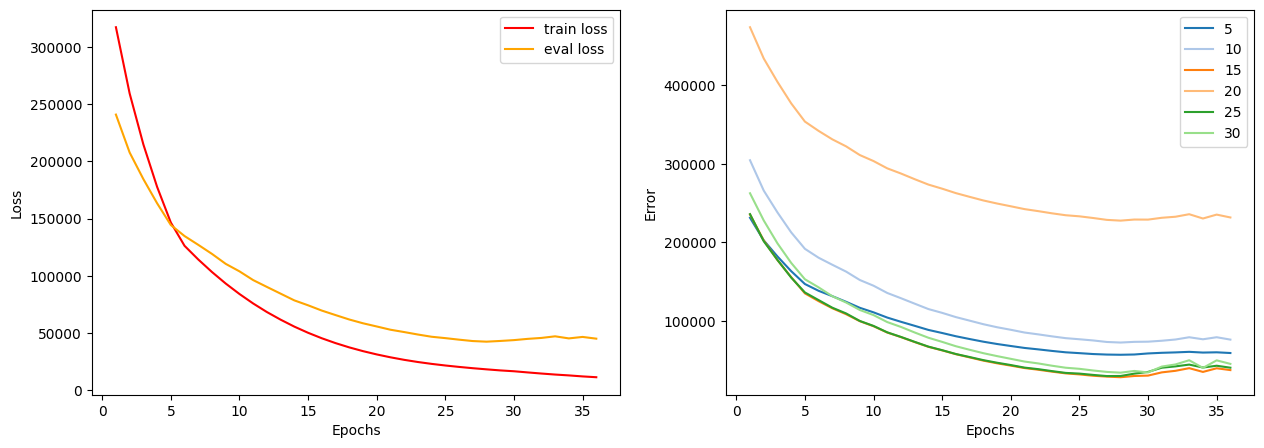

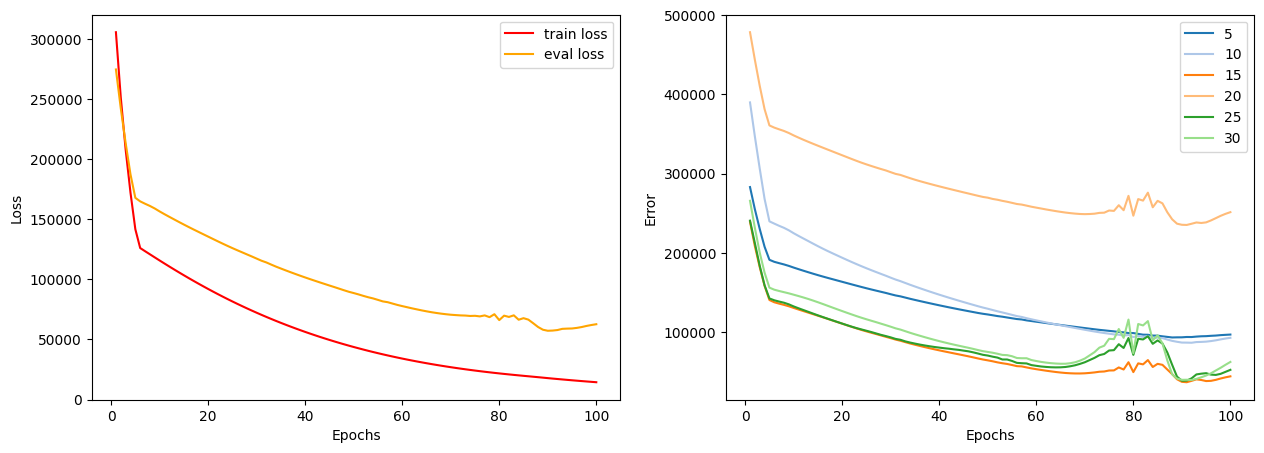

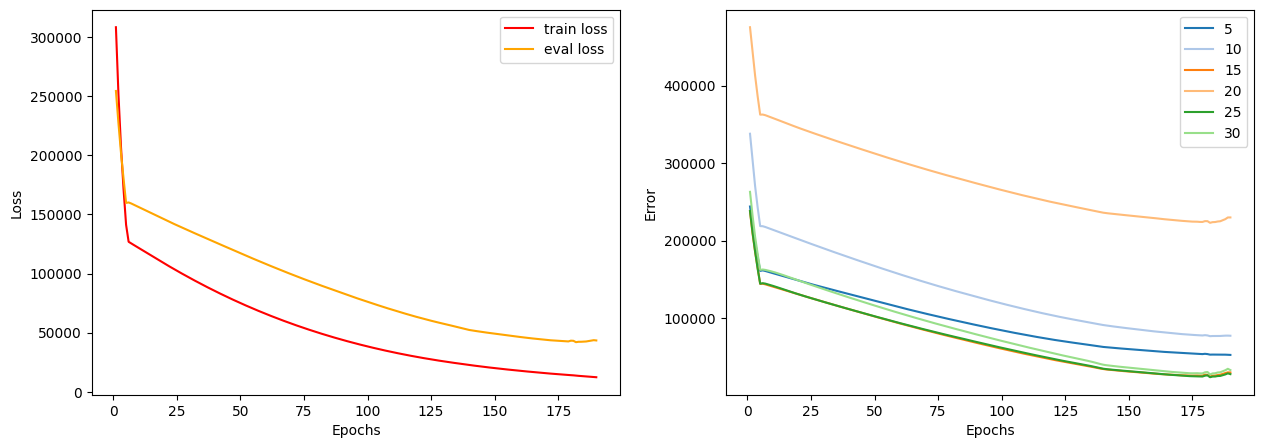

In [ ]:
learning_rates = [0.05, 0.01]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 600, 'early_stopping' : 8, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
  #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
  #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
  #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

100%|██████████| 9/9 [00:00<00:00, 10.42it/s]


epoch 0: train loss = 307955.63125, eval loss = 255052.65277777778


100%|██████████| 9/9 [00:01<00:00,  7.39it/s]


epoch 1: train loss = 252278.05223214286, eval loss = 223850.57465277778


100%|██████████| 9/9 [00:00<00:00, 10.08it/s]


epoch 2: train loss = 208267.46183035715, eval loss = 199896.25347222222


100%|██████████| 9/9 [00:00<00:00, 10.44it/s]


epoch 3: train loss = 171883.5435267857, eval loss = 176413.90972222222


100%|██████████| 9/9 [00:00<00:00, 10.29it/s]


epoch 4: train loss = 140943.30558035715, eval loss = 175015.51302083334


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


epoch 5: train loss = 125646.103125, eval loss = 168590.79861111112


100%|██████████| 9/9 [00:01<00:00,  8.31it/s]


epoch 6: train loss = 122914.55736607143, eval loss = 161658.33072916666


100%|██████████| 9/9 [00:01<00:00,  6.98it/s]


epoch 7: train loss = 120319.16316964285, eval loss = 156243.5390625


100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


epoch 8: train loss = 117695.00089285715, eval loss = 152242.11197916666


100%|██████████| 9/9 [00:00<00:00, 10.50it/s]


epoch 9: train loss = 115141.51439732143, eval loss = 149077.74392361112


100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


epoch 10: train loss = 112595.4935267857, eval loss = 146296.83680555556


100%|██████████| 9/9 [00:00<00:00, 10.59it/s]


epoch 11: train loss = 110064.534375, eval loss = 144393.21354166666


100%|██████████| 9/9 [00:00<00:00, 10.09it/s]


epoch 12: train loss = 107582.46149553571, eval loss = 142305.17881944444


100%|██████████| 9/9 [00:01<00:00,  7.37it/s]


epoch 13: train loss = 105134.25502232143, eval loss = 140765.10243055556


100%|██████████| 9/9 [00:00<00:00, 10.35it/s]


epoch 14: train loss = 102717.69095982143, eval loss = 138200.94444444444


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


epoch 15: train loss = 100334.44587053571, eval loss = 136421.10763888888


100%|██████████| 9/9 [00:00<00:00, 10.29it/s]


epoch 16: train loss = 97993.56149553572, eval loss = 134769.66319444444


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


epoch 17: train loss = 95705.99631696429, eval loss = 132864.27777777778


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


epoch 18: train loss = 93454.81908482143, eval loss = 131425.05555555556


100%|██████████| 9/9 [00:01<00:00,  7.44it/s]


epoch 19: train loss = 91255.0203125, eval loss = 129856.45659722222


100%|██████████| 9/9 [00:00<00:00,  9.45it/s]


epoch 20: train loss = 89096.08292410715, eval loss = 128990.23784722222


100%|██████████| 9/9 [00:00<00:00, 10.25it/s]


epoch 21: train loss = 86969.99319196428, eval loss = 126851.234375


100%|██████████| 9/9 [00:00<00:00, 10.59it/s]


epoch 22: train loss = 84900.86127232143, eval loss = 126283.02083333333


100%|██████████| 9/9 [00:00<00:00, 10.44it/s]


epoch 23: train loss = 82850.54073660714, eval loss = 123414.90364583333


100%|██████████| 9/9 [00:00<00:00, 10.89it/s]


epoch 24: train loss = 80858.08325892857, eval loss = 123420.02430555556


100%|██████████| 9/9 [00:00<00:00, 10.74it/s]


epoch 25: train loss = 78901.46272321428, eval loss = 120813.22048611111


100%|██████████| 9/9 [00:01<00:00,  7.38it/s]


epoch 26: train loss = 76982.08995535714, eval loss = 120842.63020833333


100%|██████████| 9/9 [00:00<00:00, 10.35it/s]


epoch 27: train loss = 75102.50870535715, eval loss = 117857.11979166667


100%|██████████| 9/9 [00:00<00:00, 10.51it/s]


epoch 28: train loss = 73277.33325892857, eval loss = 117998.875


100%|██████████| 9/9 [00:00<00:00, 10.41it/s]


epoch 29: train loss = 71471.59386160714, eval loss = 114728.68489583333


100%|██████████| 9/9 [00:00<00:00, 10.07it/s]


epoch 30: train loss = 69701.59213169642, eval loss = 114040.63194444444


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


epoch 31: train loss = 67976.953515625, eval loss = 111545.14583333333


100%|██████████| 9/9 [00:01<00:00,  7.47it/s]


epoch 32: train loss = 66297.79587053572, eval loss = 112070.74826388889


100%|██████████| 9/9 [00:01<00:00,  8.82it/s]


epoch 33: train loss = 64655.447879464286, eval loss = 109372.42708333333


100%|██████████| 9/9 [00:00<00:00, 10.39it/s]


epoch 34: train loss = 63045.11015625, eval loss = 108415.9765625


100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


epoch 35: train loss = 61468.850558035716, eval loss = 106770.71180555556


100%|██████████| 9/9 [00:00<00:00, 10.15it/s]


epoch 36: train loss = 59945.40892857143, eval loss = 104922.47482638889


100%|██████████| 9/9 [00:00<00:00, 10.26it/s]


epoch 37: train loss = 58456.448214285716, eval loss = 104347.77777777778


100%|██████████| 9/9 [00:01<00:00,  7.58it/s]


epoch 38: train loss = 56982.50926339286, eval loss = 103051.43315972222


100%|██████████| 9/9 [00:01<00:00,  7.44it/s]


epoch 39: train loss = 55546.76768973214, eval loss = 101339.38064236111


100%|██████████| 9/9 [00:00<00:00, 10.19it/s]


epoch 40: train loss = 54162.83861607143, eval loss = 100118.37977430556


100%|██████████| 9/9 [00:00<00:00, 10.37it/s]


epoch 41: train loss = 52800.705691964286, eval loss = 98462.10026041667


100%|██████████| 9/9 [00:00<00:00, 10.24it/s]


epoch 42: train loss = 51482.26707589286, eval loss = 97546.55685763889


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


epoch 43: train loss = 50188.40675223214, eval loss = 95911.58680555556


100%|██████████| 9/9 [00:01<00:00,  8.50it/s]


epoch 44: train loss = 48929.254185267855, eval loss = 94635.74652777778


100%|██████████| 9/9 [00:01<00:00,  6.98it/s]


epoch 45: train loss = 47700.825390625, eval loss = 92956.42621527778


100%|██████████| 9/9 [00:00<00:00,  9.96it/s]


epoch 46: train loss = 46505.79070870535, eval loss = 91593.93229166667


100%|██████████| 9/9 [00:00<00:00, 10.42it/s]


epoch 47: train loss = 45335.44386160714, eval loss = 90143.94010416667


100%|██████████| 9/9 [00:00<00:00, 10.24it/s]


epoch 48: train loss = 44199.707728794645, eval loss = 88633.06987847222


100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


epoch 49: train loss = 43092.626171875, eval loss = 87118.0078125


100%|██████████| 9/9 [00:01<00:00,  8.03it/s]


epoch 50: train loss = 42015.12993861607, eval loss = 85781.66927083333


100%|██████████| 9/9 [00:01<00:00,  6.78it/s]


epoch 51: train loss = 40964.87201450893, eval loss = 84462.91059027778


100%|██████████| 9/9 [00:00<00:00, 10.73it/s]


epoch 52: train loss = 39943.6611328125, eval loss = 83181.97178819444


100%|██████████| 9/9 [00:00<00:00,  9.95it/s]


epoch 53: train loss = 38952.56512276785, eval loss = 82043.82074652778


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


epoch 54: train loss = 37988.5513671875, eval loss = 80966.57465277778


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


epoch 55: train loss = 37052.34048549107, eval loss = 79846.72482638889


100%|██████████| 9/9 [00:00<00:00,  9.18it/s]


epoch 56: train loss = 36139.23844866071, eval loss = 78756.92447916667


100%|██████████| 9/9 [00:01<00:00,  7.00it/s]


epoch 57: train loss = 35254.299832589284, eval loss = 77821.19227430556


100%|██████████| 9/9 [00:00<00:00, 10.37it/s]


epoch 58: train loss = 34394.125, eval loss = 76902.3828125


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


epoch 59: train loss = 33561.87003348214, eval loss = 75995.65711805556


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


epoch 60: train loss = 32754.616043526785, eval loss = 75379.84982638889


100%|██████████| 9/9 [00:00<00:00, 10.50it/s]


epoch 61: train loss = 31977.9599609375, eval loss = 74325.17751736111


100%|██████████| 9/9 [00:00<00:00, 10.38it/s]


epoch 62: train loss = 31211.1296875, eval loss = 73492.91362847222


100%|██████████| 9/9 [00:01<00:00,  7.25it/s]


epoch 63: train loss = 30471.768233816965, eval loss = 72828.62456597222


100%|██████████| 9/9 [00:00<00:00, 10.81it/s]


epoch 64: train loss = 29754.750571986606, eval loss = 71914.53515625


100%|██████████| 9/9 [00:00<00:00, 10.39it/s]


epoch 65: train loss = 29060.592410714286, eval loss = 71321.67144097222


100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


epoch 66: train loss = 28390.23758370536, eval loss = 70522.67274305556


100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


epoch 67: train loss = 27740.355859375, eval loss = 69846.58289930556


100%|██████████| 9/9 [00:00<00:00, 10.38it/s]


epoch 68: train loss = 27112.556180245534, eval loss = 69053.07096354167


100%|██████████| 9/9 [00:01<00:00,  7.31it/s]


epoch 69: train loss = 26504.970842633928, eval loss = 68373.69921875


100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


epoch 70: train loss = 25917.115206473216, eval loss = 67884.34006076389


100%|██████████| 9/9 [00:00<00:00, 10.14it/s]


epoch 71: train loss = 25345.600125558034, eval loss = 67153.15993923611


100%|██████████| 9/9 [00:00<00:00, 10.29it/s]


epoch 72: train loss = 24794.776827566966, eval loss = 66743.94683159722


100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


epoch 73: train loss = 24262.230357142857, eval loss = 65793.19379340278


100%|██████████| 9/9 [00:00<00:00, 10.29it/s]


epoch 74: train loss = 23742.052957589287, eval loss = 65528.606770833336


100%|██████████| 9/9 [00:01<00:00,  7.28it/s]


epoch 75: train loss = 23242.508942522323, eval loss = 64623.895182291664


100%|██████████| 9/9 [00:00<00:00, 10.50it/s]


epoch 76: train loss = 22751.707589285714, eval loss = 64290.02886284722


100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


epoch 77: train loss = 22380.30538504464, eval loss = 62954.416883680555


100%|██████████| 9/9 [00:00<00:00, 10.26it/s]


epoch 78: train loss = 21940.11273716518, eval loss = 62764.864583333336


100%|██████████| 9/9 [00:00<00:00, 10.62it/s]


epoch 79: train loss = 21466.795633370537, eval loss = 62530.11762152778


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


epoch 80: train loss = 21018.69794921875, eval loss = 62311.05121527778


100%|██████████| 9/9 [00:01<00:00,  7.38it/s]


epoch 81: train loss = 20590.019614955356, eval loss = 62496.775390625


100%|██████████| 9/9 [00:01<00:00,  7.90it/s]


epoch 82: train loss = 20179.83544921875, eval loss = 61423.348741319445


100%|██████████| 9/9 [00:00<00:00, 10.47it/s]


epoch 83: train loss = 19808.394852120535, eval loss = 61712.635850694445


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


epoch 84: train loss = 19438.62232142857, eval loss = 62964.61089409722


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


epoch 85: train loss = 19023.581340680805, eval loss = 59626.654947916664


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


epoch 86: train loss = 18616.02672293527, eval loss = 59578.64431423611


100%|██████████| 9/9 [00:01<00:00,  8.30it/s]


epoch 87: train loss = 18250.190304129464, eval loss = 60172.31662326389


100%|██████████| 9/9 [00:01<00:00,  6.99it/s]


epoch 88: train loss = 17852.949888392857, eval loss = 58368.15668402778


100%|██████████| 9/9 [00:00<00:00, 10.43it/s]


epoch 89: train loss = 17483.084779575893, eval loss = 57655.44900173611


100%|██████████| 9/9 [00:00<00:00, 10.25it/s]


epoch 90: train loss = 17079.7782296317, eval loss = 60706.482421875


100%|██████████| 9/9 [00:00<00:00, 10.42it/s]


epoch 91: train loss = 16740.524302455357, eval loss = 57815.282552083336


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


epoch 92: train loss = 16282.445654296875, eval loss = 56218.7109375


100%|██████████| 9/9 [00:00<00:00, 10.54it/s]


epoch 93: train loss = 15910.62804827009, eval loss = 55958.649305555555


100%|██████████| 9/9 [00:01<00:00,  7.63it/s]


epoch 94: train loss = 15859.577825055803, eval loss = 55562.74587673611


100%|██████████| 9/9 [00:00<00:00, 10.64it/s]


epoch 95: train loss = 15473.537004743304, eval loss = 55047.73806423611


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


epoch 96: train loss = 14968.052957589285, eval loss = 57464.52191840278


100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


epoch 97: train loss = 14734.287482561384, eval loss = 54471.65668402778


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


epoch 98: train loss = 14343.618219866072, eval loss = 55105.71484375


100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


epoch 99: train loss = 13877.613246372768, eval loss = 53386.830078125


100%|██████████| 9/9 [00:01<00:00,  7.23it/s]


epoch 100: train loss = 13594.620152064732, eval loss = 54060.588975694445


100%|██████████| 9/9 [00:00<00:00, 10.29it/s]


epoch 101: train loss = 13296.724236188616, eval loss = 52876.996744791664


100%|██████████| 9/9 [00:00<00:00, 10.54it/s]


epoch 102: train loss = 13020.879781668527, eval loss = 53703.364366319445


100%|██████████| 9/9 [00:00<00:00, 10.45it/s]


epoch 103: train loss = 12779.320710100446, eval loss = 52372.595811631945


100%|██████████| 9/9 [00:00<00:00, 10.24it/s]


epoch 104: train loss = 12422.81434500558, eval loss = 53348.188802083336


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


epoch 105: train loss = 12234.787827845983, eval loss = 51914.882161458336


100%|██████████| 9/9 [00:01<00:00,  7.20it/s]


epoch 106: train loss = 11811.522094726562, eval loss = 51340.017686631945


100%|██████████| 9/9 [00:00<00:00,  9.11it/s]


epoch 107: train loss = 11463.130360630581, eval loss = 51622.356770833336


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


epoch 108: train loss = 11193.494297572544, eval loss = 50969.58148871528


100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


epoch 109: train loss = 10917.39011579241, eval loss = 51211.21234809028


100%|██████████| 9/9 [00:00<00:00, 10.60it/s]


epoch 110: train loss = 10654.400959123885, eval loss = 50554.076063368055


100%|██████████| 9/9 [00:00<00:00, 10.57it/s]


epoch 111: train loss = 10400.657631138392, eval loss = 50665.857313368055


100%|██████████| 9/9 [00:01<00:00,  8.44it/s]


epoch 112: train loss = 10156.414726911273, eval loss = 50145.131727430555


100%|██████████| 9/9 [00:01<00:00,  6.66it/s]


epoch 113: train loss = 9918.324818638393, eval loss = 50202.13845486111


100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


epoch 114: train loss = 9691.73707624163, eval loss = 49799.412977430555


100%|██████████| 9/9 [00:00<00:00,  9.98it/s]


epoch 115: train loss = 9482.99322858538, eval loss = 50077.609266493055


100%|██████████| 9/9 [00:00<00:00,  9.99it/s]


epoch 116: train loss = 9834.598866489956, eval loss = 49942.68012152778


100%|██████████| 9/9 [00:00<00:00, 10.08it/s]


epoch 117: train loss = 9353.487559291294, eval loss = 50332.57280815972


100%|██████████| 9/9 [00:00<00:00,  9.93it/s]


epoch 118: train loss = 8947.461420549665, eval loss = 50062.052083333336


100%|██████████| 9/9 [00:01<00:00,  7.36it/s]


epoch 119: train loss = 8672.569588797433, eval loss = 49963.07931857639


100%|██████████| 9/9 [00:00<00:00, 10.19it/s]


epoch 120: train loss = 8454.187236676897, eval loss = 48721.089952256945


100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


epoch 121: train loss = 8251.585684640067, eval loss = 50195.689561631945


100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


epoch 122: train loss = 8059.685778808594, eval loss = 47067.371419270836


100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


epoch 123: train loss = 7869.282317243304, eval loss = 50889.96310763889


100%|██████████| 9/9 [00:00<00:00, 10.54it/s]


epoch 124: train loss = 7754.341169084822, eval loss = 46608.278645833336


100%|██████████| 9/9 [00:01<00:00,  6.77it/s]


epoch 125: train loss = 7542.973814174107, eval loss = 48667.693250868055


100%|██████████| 9/9 [00:00<00:00, 10.52it/s]


epoch 126: train loss = 7336.326569475446, eval loss = 46748.233072916664


100%|██████████| 9/9 [00:00<00:00,  9.99it/s]


epoch 127: train loss = 7165.131415666852, eval loss = 48125.328233506945


100%|██████████| 9/9 [00:00<00:00, 10.43it/s]


epoch 128: train loss = 6999.120272391183, eval loss = 46651.761610243055


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


epoch 129: train loss = 6827.075212751116, eval loss = 47845.012803819445


100%|██████████| 9/9 [00:00<00:00, 10.76it/s]


epoch 130: train loss = 6678.407697405134, eval loss = 46824.841796875


100%|██████████| 9/9 [00:01<00:00,  7.49it/s]


epoch 131: train loss = 6517.217156982422, eval loss = 47416.16286892361


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


epoch 132: train loss = 6367.897828892299, eval loss = 46925.132703993055


100%|██████████| 9/9 [00:00<00:00, 10.25it/s]


epoch 133: train loss = 6214.6528991699215, eval loss = 47383.030164930555


100%|██████████| 9/9 [00:00<00:00, 10.15it/s]


epoch 134: train loss = 6056.232082693918, eval loss = 46733.85004340278


100%|██████████| 9/9 [00:00<00:00, 10.42it/s]


epoch 135: train loss = 5901.462969970703, eval loss = 47518.160047743055


100%|██████████| 9/9 [00:00<00:00, 10.53it/s]


epoch 136: train loss = 5763.414877755301, eval loss = 45904.98122829861


100%|██████████| 9/9 [00:01<00:00,  7.46it/s]


epoch 137: train loss = 5635.387279401507, eval loss = 47583.06369357639


100%|██████████| 9/9 [00:01<00:00,  7.61it/s]


epoch 138: train loss = 5475.64053867885, eval loss = 44964.77593315972


100%|██████████| 9/9 [00:00<00:00, 10.57it/s]


epoch 139: train loss = 5339.304129464285, eval loss = 48303.8779296875


100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


epoch 140: train loss = 5204.301838902064, eval loss = 44768.29047309028


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


epoch 141: train loss = 5077.678750174387, eval loss = 47030.67133246528


100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


epoch 142: train loss = 4937.781213378907, eval loss = 45055.04193793403


100%|██████████| 9/9 [00:01<00:00,  8.61it/s]


epoch 143: train loss = 4826.873346819197, eval loss = 46112.49782986111


100%|██████████| 9/9 [00:01<00:00,  6.79it/s]


epoch 144: train loss = 4706.692521449498, eval loss = 45063.50390625


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


epoch 145: train loss = 4589.638374546596, eval loss = 45613.81716579861


100%|██████████| 9/9 [00:00<00:00, 10.43it/s]


epoch 146: train loss = 4460.812925502232, eval loss = 45040.57611762153


100%|██████████| 9/9 [00:00<00:00, 10.07it/s]


epoch 147: train loss = 4363.382240513393, eval loss = 45461.103190104164


100%|██████████| 9/9 [00:00<00:00, 10.57it/s]


epoch 148: train loss = 4242.279056222098, eval loss = 44906.63156467014

Early stoping after 148 epochs. eval loss did not imporve for more than 8 epochs

Finished Training:
Best metrics are:
Best loss = 274690.1875
Best train loss = 5204.301838902064
Best eval loss = 44768.29047309028
Best 5sec eval = 42458.83984375
Best 10sec eval = 274690.1875
Best 15sec eval = 11326.93359375
Best 20sec eval = 210503.265625
Best 25sec eval = 10099.1826171875
Best 30sec eval = 11833.3935546875


100%|██████████| 9/9 [00:00<00:00,  9.93it/s]


epoch 0: train loss = 310824.2607142857, eval loss = 245700.06423611112


100%|██████████| 9/9 [00:01<00:00,  7.43it/s]


epoch 1: train loss = 251288.16830357144, eval loss = 215417.89930555556


100%|██████████| 9/9 [00:00<00:00, 10.48it/s]


epoch 2: train loss = 206754.84397321427, eval loss = 190242.49131944444


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


epoch 3: train loss = 170662.10691964286, eval loss = 167297.89670138888


100%|██████████| 9/9 [00:00<00:00, 10.59it/s]


epoch 4: train loss = 139886.7136160714, eval loss = 145880.48350694444


100%|██████████| 9/9 [00:00<00:00, 10.29it/s]


epoch 5: train loss = 125559.97991071429, eval loss = 144209.01215277778


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


epoch 6: train loss = 124213.62109375, eval loss = 142881.34895833334


100%|██████████| 9/9 [00:01<00:00,  7.27it/s]


epoch 7: train loss = 122906.24609375, eval loss = 141868.96527777778


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


epoch 8: train loss = 121592.82924107143, eval loss = 140708.00520833334


100%|██████████| 9/9 [00:00<00:00, 10.55it/s]


epoch 9: train loss = 120273.19821428572, eval loss = 139493.86197916666


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


epoch 10: train loss = 118948.03013392857, eval loss = 138294.13628472222


100%|██████████| 9/9 [00:00<00:00, 10.35it/s]


epoch 11: train loss = 117620.97689732142, eval loss = 137155.75954861112


100%|██████████| 9/9 [00:00<00:00, 10.35it/s]


epoch 12: train loss = 116294.58805803572, eval loss = 136039.90364583334


100%|██████████| 9/9 [00:01<00:00,  7.19it/s]


epoch 13: train loss = 114970.91328125, eval loss = 134944.64930555556


100%|██████████| 9/9 [00:01<00:00,  8.34it/s]


epoch 14: train loss = 113651.44709821428, eval loss = 133899.8359375


100%|██████████| 9/9 [00:00<00:00, 10.04it/s]


epoch 15: train loss = 112337.28738839286, eval loss = 132900.99305555556


100%|██████████| 9/9 [00:00<00:00, 10.43it/s]


epoch 16: train loss = 111028.8658482143, eval loss = 131895.13715277778


100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


epoch 17: train loss = 109727.44564732142, eval loss = 130838.48871527778


100%|██████████| 9/9 [00:00<00:00, 10.29it/s]


epoch 18: train loss = 108433.8424107143, eval loss = 129722.47048611111


100%|██████████| 9/9 [00:01<00:00,  7.77it/s]


epoch 19: train loss = 107148.90602678571, eval loss = 128587.2421875


100%|██████████| 9/9 [00:01<00:00,  7.59it/s]


epoch 20: train loss = 105872.33270089286, eval loss = 127500.3203125


100%|██████████| 9/9 [00:00<00:00, 10.39it/s]


epoch 21: train loss = 104604.86897321428, eval loss = 126448.84461805556


100%|██████████| 9/9 [00:00<00:00, 10.48it/s]


epoch 22: train loss = 103347.13247767858, eval loss = 125368.11892361111


100%|██████████| 9/9 [00:00<00:00, 10.24it/s]


epoch 23: train loss = 102099.50357142858, eval loss = 124291.13628472222


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


epoch 24: train loss = 100862.10725446428, eval loss = 123234.82118055556


100%|██████████| 9/9 [00:01<00:00,  8.93it/s]


epoch 25: train loss = 99635.32455357142, eval loss = 122258.18836805556


100%|██████████| 9/9 [00:01<00:00,  6.83it/s]


epoch 26: train loss = 98417.81785714286, eval loss = 121380.01302083333


100%|██████████| 9/9 [00:00<00:00, 10.36it/s]


epoch 27: train loss = 97211.68392857142, eval loss = 120553.82118055556


100%|██████████| 9/9 [00:00<00:00, 10.60it/s]


epoch 28: train loss = 96017.78638392857, eval loss = 119411.18706597222


100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


epoch 29: train loss = 94831.62991071428, eval loss = 118292.44574652778


100%|██████████| 9/9 [00:00<00:00, 10.07it/s]


epoch 30: train loss = 93656.28348214286, eval loss = 117331.35460069444


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


epoch 31: train loss = 92491.24497767857, eval loss = 116405.50130208333


100%|██████████| 9/9 [00:01<00:00,  7.43it/s]


epoch 32: train loss = 91337.86015625, eval loss = 115529.51605902778


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


epoch 33: train loss = 90195.06662946429, eval loss = 114663.19444444444


100%|██████████| 9/9 [00:00<00:00, 10.42it/s]


epoch 34: train loss = 89062.87310267857, eval loss = 113777.69618055556


100%|██████████| 9/9 [00:00<00:00, 10.42it/s]


epoch 35: train loss = 87941.73504464286, eval loss = 112834.22265625


100%|██████████| 9/9 [00:00<00:00, 10.41it/s]


epoch 36: train loss = 86832.490625, eval loss = 112137.20095486111


100%|██████████| 9/9 [00:00<00:00, 10.55it/s]


epoch 37: train loss = 85732.43856026785, eval loss = 111569.20876736111


100%|██████████| 9/9 [00:01<00:00,  7.11it/s]


epoch 38: train loss = 84643.2310825893, eval loss = 111317.01605902778


100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


epoch 39: train loss = 83566.85167410714, eval loss = 111382.85763888889


100%|██████████| 9/9 [00:00<00:00, 10.29it/s]


epoch 40: train loss = 82498.68119419643, eval loss = 110368.05078125


100%|██████████| 9/9 [00:00<00:00, 10.38it/s]


epoch 41: train loss = 81441.67946428571, eval loss = 109309.32986111111


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


epoch 42: train loss = 80395.71467633928, eval loss = 108288.23958333333


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


epoch 43: train loss = 79360.46272321428, eval loss = 107312.00390625


100%|██████████| 9/9 [00:01<00:00,  7.30it/s]


epoch 44: train loss = 78335.85306919643, eval loss = 106455.85894097222


100%|██████████| 9/9 [00:00<00:00, 10.63it/s]


epoch 45: train loss = 77322.23917410715, eval loss = 105603.64713541667


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


epoch 46: train loss = 76318.70022321428, eval loss = 104921.12065972222


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


epoch 47: train loss = 75325.10502232143, eval loss = 104115.78993055556


100%|██████████| 9/9 [00:00<00:00, 10.19it/s]


epoch 48: train loss = 74343.00792410714, eval loss = 103610.32161458333


100%|██████████| 9/9 [00:00<00:00, 10.12it/s]


epoch 49: train loss = 73373.948046875, eval loss = 102347.90755208333


100%|██████████| 9/9 [00:01<00:00,  7.07it/s]


epoch 50: train loss = 72411.30290178572, eval loss = 101999.09201388889


100%|██████████| 9/9 [00:00<00:00,  9.17it/s]


epoch 51: train loss = 71465.24313616072, eval loss = 100790.35243055556


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


epoch 52: train loss = 70521.02020089286, eval loss = 101788.84982638889


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


epoch 53: train loss = 69603.31077008929, eval loss = 98887.17317708333


100%|██████████| 9/9 [00:00<00:00, 10.45it/s]


epoch 54: train loss = 68676.07762276786, eval loss = 96507.13454861111


100%|██████████| 9/9 [00:00<00:00, 10.47it/s]


epoch 55: train loss = 67765.13303571429, eval loss = 96414.45052083333


100%|██████████| 9/9 [00:01<00:00,  7.07it/s]


epoch 56: train loss = 66869.16908482143, eval loss = 95139.28211805556


100%|██████████| 9/9 [00:01<00:00,  7.52it/s]


epoch 57: train loss = 65979.92377232143, eval loss = 94258.06423611111


100%|██████████| 9/9 [00:00<00:00, 10.37it/s]


epoch 58: train loss = 65099.511272321426, eval loss = 93271.71701388889


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


epoch 59: train loss = 64230.905636160714, eval loss = 92572.80208333333


100%|██████████| 9/9 [00:00<00:00, 10.18it/s]


epoch 60: train loss = 63372.41590401786, eval loss = 91705.11284722222


100%|██████████| 9/9 [00:00<00:00, 10.55it/s]


epoch 61: train loss = 62522.40485491072, eval loss = 90590.28472222222


100%|██████████| 9/9 [00:01<00:00,  7.47it/s]


epoch 62: train loss = 61680.24056919643, eval loss = 89421.53993055556


100%|██████████| 9/9 [00:01<00:00,  8.30it/s]


epoch 63: train loss = 60849.00083705357, eval loss = 88188.18359375


100%|██████████| 9/9 [00:00<00:00, 10.36it/s]


epoch 64: train loss = 60029.7125, eval loss = 87382.54340277778


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


epoch 65: train loss = 59220.856808035714, eval loss = 86418.22829861111


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


epoch 66: train loss = 58422.360323660716, eval loss = 85366.10416666667


100%|██████████| 9/9 [00:00<00:00, 10.39it/s]


epoch 67: train loss = 57629.412723214286, eval loss = 85313.70920138889


100%|██████████| 9/9 [00:01<00:00,  8.96it/s]


epoch 68: train loss = 56852.51668526786, eval loss = 83343.37369791667


100%|██████████| 9/9 [00:01<00:00,  6.83it/s]


epoch 69: train loss = 56075.39079241071, eval loss = 82530.62109375


100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


epoch 70: train loss = 55323.99347098215, eval loss = 81869.67404513889


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


epoch 71: train loss = 54561.533649553574, eval loss = 80989.58897569444


100%|██████████| 9/9 [00:00<00:00, 10.39it/s]


epoch 72: train loss = 53814.42377232143, eval loss = 80237.234375


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


epoch 73: train loss = 53074.82176339286, eval loss = 79534.31814236111


100%|██████████| 9/9 [00:00<00:00, 10.68it/s]


epoch 74: train loss = 52346.312890625, eval loss = 78946.60807291667


100%|██████████| 9/9 [00:01<00:00,  7.45it/s]


epoch 75: train loss = 51627.16969866071, eval loss = 78184.76432291667


100%|██████████| 9/9 [00:00<00:00, 10.85it/s]


epoch 76: train loss = 50914.60703125, eval loss = 77704.97612847222


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


epoch 77: train loss = 50212.02692522322, eval loss = 77172.19444444444


100%|██████████| 9/9 [00:00<00:00, 10.29it/s]


epoch 78: train loss = 49518.65731026786, eval loss = 76750.89409722222


100%|██████████| 9/9 [00:00<00:00, 10.59it/s]


epoch 79: train loss = 48834.51107700893, eval loss = 76202.86935763889


100%|██████████| 9/9 [00:00<00:00, 10.47it/s]


epoch 80: train loss = 48159.20147879465, eval loss = 75661.42881944444


100%|██████████| 9/9 [00:01<00:00,  7.23it/s]


epoch 81: train loss = 47493.43978794643, eval loss = 75004.27213541667


100%|██████████| 9/9 [00:01<00:00,  8.91it/s]


epoch 82: train loss = 46836.449190848216, eval loss = 74367.77300347222


100%|██████████| 9/9 [00:00<00:00, 10.17it/s]


epoch 83: train loss = 46188.45669642857, eval loss = 73710.96918402778


100%|██████████| 9/9 [00:00<00:00, 10.43it/s]


epoch 84: train loss = 45548.78376116072, eval loss = 73085.25651041667


100%|██████████| 9/9 [00:00<00:00, 10.62it/s]


epoch 85: train loss = 44917.85080915179, eval loss = 72415.11979166667


100%|██████████| 9/9 [00:00<00:00, 10.48it/s]


epoch 86: train loss = 44295.07505580357, eval loss = 71802.81271701389


100%|██████████| 9/9 [00:01<00:00,  6.93it/s]


epoch 87: train loss = 43680.966183035714, eval loss = 71118.89192708333


100%|██████████| 9/9 [00:01<00:00,  8.59it/s]


epoch 88: train loss = 43074.91969866071, eval loss = 70499.22634548611


100%|██████████| 9/9 [00:00<00:00, 10.07it/s]


epoch 89: train loss = 42477.41088169643, eval loss = 69807.51063368056


100%|██████████| 9/9 [00:00<00:00, 10.18it/s]


epoch 90: train loss = 41888.46657366071, eval loss = 69218.57899305556


100%|██████████| 9/9 [00:00<00:00, 10.47it/s]


epoch 91: train loss = 41306.855915178574, eval loss = 68649.85221354167


100%|██████████| 9/9 [00:00<00:00, 10.27it/s]


epoch 92: train loss = 40732.22064732143, eval loss = 68096.12673611111


100%|██████████| 9/9 [00:01<00:00,  7.27it/s]


epoch 93: train loss = 40167.37360491072, eval loss = 67491.46875


100%|██████████| 9/9 [00:01<00:00,  8.16it/s]


epoch 94: train loss = 39610.178348214286, eval loss = 66927.04166666667


100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


epoch 95: train loss = 39060.581026785716, eval loss = 66339.99978298611


100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


epoch 96: train loss = 38518.77061941964, eval loss = 65806.36067708333


100%|██████████| 9/9 [00:00<00:00, 10.10it/s]


epoch 97: train loss = 37984.61579241072, eval loss = 65261.022786458336


100%|██████████| 9/9 [00:00<00:00,  9.85it/s]


epoch 98: train loss = 37458.17421875, eval loss = 64762.799479166664


100%|██████████| 9/9 [00:01<00:00,  6.96it/s]


epoch 99: train loss = 36939.508984375, eval loss = 64242.6953125


100%|██████████| 9/9 [00:01<00:00,  8.69it/s]


epoch 100: train loss = 36428.12371651785, eval loss = 63774.634114583336


100%|██████████| 9/9 [00:00<00:00, 10.08it/s]


epoch 101: train loss = 35924.81233258929, eval loss = 63264.61284722222


100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


epoch 102: train loss = 35428.24994419643, eval loss = 62799.53949652778


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


epoch 103: train loss = 34940.2091796875, eval loss = 62347.866536458336


100%|██████████| 9/9 [00:00<00:00, 10.48it/s]


epoch 104: train loss = 34457.89893973214, eval loss = 61839.559895833336


100%|██████████| 9/9 [00:01<00:00,  7.14it/s]


epoch 105: train loss = 33986.091796875, eval loss = 61691.334635416664


100%|██████████| 9/9 [00:00<00:00,  9.95it/s]


epoch 106: train loss = 33517.470256696426, eval loss = 61136.42730034722


100%|██████████| 9/9 [00:00<00:00, 10.13it/s]


epoch 107: train loss = 33068.570340401784, eval loss = 61881.819227430555


100%|██████████| 9/9 [00:00<00:00, 10.13it/s]


epoch 108: train loss = 32610.898270089285, eval loss = 60085.181640625


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


epoch 109: train loss = 32168.934640066964, eval loss = 59949.395833333336


100%|██████████| 9/9 [00:00<00:00, 10.39it/s]


epoch 110: train loss = 31724.608816964286, eval loss = 59080.58224826389


100%|██████████| 9/9 [00:01<00:00,  7.18it/s]


epoch 111: train loss = 31294.238657924107, eval loss = 58479.41232638889


100%|██████████| 9/9 [00:01<00:00,  8.47it/s]


epoch 112: train loss = 30867.160756138393, eval loss = 58030.78537326389


100%|██████████| 9/9 [00:00<00:00, 10.35it/s]


epoch 113: train loss = 30450.591643415177, eval loss = 57572.341796875


100%|██████████| 9/9 [00:00<00:00, 10.37it/s]


epoch 114: train loss = 30039.09228515625, eval loss = 57183.586805555555


100%|██████████| 9/9 [00:00<00:00, 10.25it/s]


epoch 115: train loss = 29636.42769252232, eval loss = 56798.21310763889


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


epoch 116: train loss = 29238.65043247768, eval loss = 56484.741536458336


100%|██████████| 9/9 [00:01<00:00,  7.21it/s]


epoch 117: train loss = 28851.559193638393, eval loss = 56173.49262152778


100%|██████████| 9/9 [00:01<00:00,  8.57it/s]


epoch 118: train loss = 28466.038602120534, eval loss = 56200.109375


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


epoch 119: train loss = 28096.505970982143, eval loss = 55862.81032986111


100%|██████████| 9/9 [00:00<00:00,  9.81it/s]


epoch 120: train loss = 27722.777999441965, eval loss = 55174.84375


100%|██████████| 9/9 [00:00<00:00, 10.06it/s]


epoch 121: train loss = 27357.072572544643, eval loss = 54525.830078125


100%|██████████| 9/9 [00:00<00:00, 10.26it/s]


epoch 122: train loss = 26996.372628348214, eval loss = 54495.076171875


100%|██████████| 9/9 [00:01<00:00,  7.23it/s]


epoch 123: train loss = 26647.825041852677, eval loss = 53817.50542534722


100%|██████████| 9/9 [00:00<00:00,  9.55it/s]


epoch 124: train loss = 26300.158998325893, eval loss = 53849.674913194445


100%|██████████| 9/9 [00:00<00:00, 10.56it/s]


epoch 125: train loss = 25966.03935546875, eval loss = 53025.453125


100%|██████████| 9/9 [00:00<00:00, 10.15it/s]


epoch 126: train loss = 25630.694935825893, eval loss = 53177.138671875


100%|██████████| 9/9 [00:00<00:00, 10.48it/s]


epoch 127: train loss = 25302.684193638393, eval loss = 52349.67144097222


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


epoch 128: train loss = 24985.339815848216, eval loss = 52781.02712673611


100%|██████████| 9/9 [00:01<00:00,  7.23it/s]


epoch 129: train loss = 24668.266629464284, eval loss = 51700.73394097222


100%|██████████| 9/9 [00:00<00:00, 10.13it/s]


epoch 130: train loss = 24361.618777901786, eval loss = 52455.622395833336


100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


epoch 131: train loss = 24055.867689732142, eval loss = 50961.56662326389


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


epoch 132: train loss = 23774.159974888393, eval loss = 51874.011067708336


100%|██████████| 9/9 [00:00<00:00, 10.18it/s]


epoch 133: train loss = 23500.103627232143, eval loss = 51509.75998263889


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


epoch 134: train loss = 23191.6603515625, eval loss = 52037.78559027778


100%|██████████| 9/9 [00:01<00:00,  7.28it/s]


epoch 135: train loss = 22904.69308035714, eval loss = 49625.176866319445


100%|██████████| 9/9 [00:01<00:00,  8.26it/s]


epoch 136: train loss = 22623.384193638394, eval loss = 50517.38519965278


100%|██████████| 9/9 [00:00<00:00, 10.08it/s]


epoch 137: train loss = 22356.302664620536, eval loss = 52280.209635416664


100%|██████████| 9/9 [00:00<00:00, 10.38it/s]


epoch 138: train loss = 22089.524288504464, eval loss = 48500.692708333336


100%|██████████| 9/9 [00:00<00:00, 10.55it/s]


epoch 139: train loss = 21832.557003348214, eval loss = 50367.71245659722


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


epoch 140: train loss = 21564.63828125, eval loss = 47592.511067708336


100%|██████████| 9/9 [00:01<00:00,  7.83it/s]


epoch 141: train loss = 21303.35131138393, eval loss = 48117.66384548611


100%|██████████| 9/9 [00:01<00:00,  7.10it/s]


epoch 142: train loss = 21044.198883928573, eval loss = 48127.4453125


100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


epoch 143: train loss = 20786.590066964287, eval loss = 48188.65646701389


100%|██████████| 9/9 [00:00<00:00, 10.12it/s]


epoch 144: train loss = 20530.766378348213, eval loss = 48017.606336805555


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


epoch 145: train loss = 20280.174944196428, eval loss = 47916.54730902778


100%|██████████| 9/9 [00:00<00:00, 10.13it/s]


epoch 146: train loss = 20034.765032087053, eval loss = 47317.397135416664


100%|██████████| 9/9 [00:01<00:00,  8.45it/s]


epoch 147: train loss = 19794.942061941965, eval loss = 48655.29470486111


100%|██████████| 9/9 [00:01<00:00,  7.20it/s]


epoch 148: train loss = 19577.903250558036, eval loss = 45521.81271701389


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


epoch 149: train loss = 19337.725551060266, eval loss = 48101.873914930555


100%|██████████| 9/9 [00:00<00:00, 10.27it/s]


epoch 150: train loss = 19129.935037667412, eval loss = 47226.45746527778


100%|██████████| 9/9 [00:00<00:00, 10.29it/s]


epoch 151: train loss = 18893.633621651785, eval loss = 48080.656901041664


100%|██████████| 9/9 [00:00<00:00, 10.48it/s]


epoch 152: train loss = 18670.708133370536, eval loss = 44936.67990451389


100%|██████████| 9/9 [00:00<00:00,  9.45it/s]


epoch 153: train loss = 18404.696944754465, eval loss = 45612.60112847222


100%|██████████| 9/9 [00:01<00:00,  7.06it/s]


epoch 154: train loss = 18168.58349609375, eval loss = 46963.87348090278


100%|██████████| 9/9 [00:00<00:00,  9.75it/s]


epoch 155: train loss = 17959.48404715402, eval loss = 43329.83745659722


100%|██████████| 9/9 [00:00<00:00, 10.36it/s]


epoch 156: train loss = 17679.949065290177, eval loss = 45516.248046875


100%|██████████| 9/9 [00:00<00:00, 10.03it/s]


epoch 157: train loss = 17383.23872767857, eval loss = 44777.741319444445


100%|██████████| 9/9 [00:00<00:00, 10.06it/s]


epoch 158: train loss = 17143.793289620535, eval loss = 44822.205946180555


100%|██████████| 9/9 [00:00<00:00,  9.34it/s]


epoch 159: train loss = 16971.51087472098, eval loss = 44036.419053819445


100%|██████████| 9/9 [00:01<00:00,  7.36it/s]


epoch 160: train loss = 16712.82210518973, eval loss = 44274.31011284722


100%|██████████| 9/9 [00:00<00:00, 10.35it/s]


epoch 161: train loss = 16565.066755022322, eval loss = 43787.015625


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


epoch 162: train loss = 16323.872481863838, eval loss = 44722.800130208336


100%|██████████| 9/9 [00:00<00:00, 10.08it/s]


epoch 163: train loss = 16066.771156529017, eval loss = 43274.29665798611


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


epoch 164: train loss = 15892.449016462053, eval loss = 42955.93359375


100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


epoch 165: train loss = 15758.01455078125, eval loss = 43199.93511284722


100%|██████████| 9/9 [00:01<00:00,  7.25it/s]


epoch 166: train loss = 15397.533782087054, eval loss = 42696.66720920139


100%|██████████| 9/9 [00:00<00:00, 10.45it/s]


epoch 167: train loss = 15223.405043247767, eval loss = 42727.667317708336


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


epoch 168: train loss = 15034.139620535714, eval loss = 42073.980360243055


100%|██████████| 9/9 [00:00<00:00, 10.24it/s]


epoch 169: train loss = 14776.838201032366, eval loss = 41767.654622395836


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


epoch 170: train loss = 14569.962074497767, eval loss = 41474.42914496528


100%|██████████| 9/9 [00:00<00:00, 10.18it/s]


epoch 171: train loss = 14370.043701171875, eval loss = 40492.378255208336


100%|██████████| 9/9 [00:01<00:00,  7.38it/s]


epoch 172: train loss = 14167.01651436942, eval loss = 41182.528211805555


100%|██████████| 9/9 [00:01<00:00,  7.63it/s]


epoch 173: train loss = 13970.385518973215, eval loss = 39492.11566840278


100%|██████████| 9/9 [00:00<00:00, 10.07it/s]


epoch 174: train loss = 13775.720943777902, eval loss = 39540.7490234375


100%|██████████| 9/9 [00:00<00:00, 10.51it/s]


epoch 175: train loss = 13578.00868094308, eval loss = 39414.562174479164


100%|██████████| 9/9 [00:00<00:00, 10.47it/s]


epoch 176: train loss = 13385.15295061384, eval loss = 39071.593641493055


100%|██████████| 9/9 [00:00<00:00, 10.48it/s]


epoch 177: train loss = 13200.0185093471, eval loss = 38794.468098958336


100%|██████████| 9/9 [00:00<00:00, 10.36it/s]


epoch 178: train loss = 13008.99918736049, eval loss = 38532.574327256945


100%|██████████| 9/9 [00:01<00:00,  7.41it/s]


epoch 179: train loss = 12830.794569614955, eval loss = 38252.47211371528


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


epoch 180: train loss = 12644.157610212054, eval loss = 38134.878255208336


100%|██████████| 9/9 [00:00<00:00, 10.56it/s]


epoch 181: train loss = 12476.190405273437, eval loss = 37779.158203125


100%|██████████| 9/9 [00:00<00:00, 10.53it/s]


epoch 182: train loss = 12291.794883510045, eval loss = 37869.831922743055


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


epoch 183: train loss = 12135.430943080357, eval loss = 37568.79155815972


100%|██████████| 9/9 [00:00<00:00, 10.57it/s]


epoch 184: train loss = 11943.311840820312, eval loss = 37478.276692708336


100%|██████████| 9/9 [00:01<00:00,  7.52it/s]


epoch 185: train loss = 11789.606828962054, eval loss = 37169.0400390625


100%|██████████| 9/9 [00:01<00:00,  8.60it/s]


epoch 186: train loss = 11596.247044154576, eval loss = 37024.188368055555


100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


epoch 187: train loss = 11436.9070539202, eval loss = 36793.82758246528


100%|██████████| 9/9 [00:00<00:00, 10.29it/s]


epoch 188: train loss = 11263.758326939174, eval loss = 36618.5927734375


100%|██████████| 9/9 [00:00<00:00, 10.38it/s]


epoch 189: train loss = 11108.359497070312, eval loss = 36442.418294270836


100%|██████████| 9/9 [00:00<00:00, 10.27it/s]


epoch 190: train loss = 10950.160414341517, eval loss = 36297.39008246528


100%|██████████| 9/9 [00:00<00:00,  9.35it/s]


epoch 191: train loss = 10793.5228515625, eval loss = 36199.1875


100%|██████████| 9/9 [00:01<00:00,  7.16it/s]


epoch 192: train loss = 10637.466280691964, eval loss = 36043.02495659722


100%|██████████| 9/9 [00:00<00:00, 10.26it/s]


epoch 193: train loss = 10483.724579729353, eval loss = 35863.280164930555


100%|██████████| 9/9 [00:00<00:00, 10.12it/s]


epoch 194: train loss = 10333.625875418527, eval loss = 35876.25857204861


100%|██████████| 9/9 [00:00<00:00, 10.38it/s]


epoch 195: train loss = 10186.58329119001, eval loss = 35668.462999131945


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


epoch 196: train loss = 10040.407150704521, eval loss = 35579.08539496528


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


epoch 197: train loss = 9895.453642926897, eval loss = 35931.48415798611


100%|██████████| 9/9 [00:01<00:00,  7.25it/s]


epoch 198: train loss = 9761.629802594865, eval loss = 35461.11187065972


100%|██████████| 9/9 [00:01<00:00,  8.08it/s]


epoch 199: train loss = 9622.921855817522, eval loss = 35629.710286458336


100%|██████████| 9/9 [00:00<00:00, 10.13it/s]


epoch 200: train loss = 9476.63784615653, eval loss = 35369.026475694445


100%|██████████| 9/9 [00:00<00:00, 10.10it/s]


epoch 201: train loss = 9338.194014195033, eval loss = 35371.591471354164


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


epoch 202: train loss = 9195.09912109375, eval loss = 35246.50249565972


100%|██████████| 9/9 [00:00<00:00,  9.95it/s]


epoch 203: train loss = 9060.858219691685, eval loss = 35187.88812934028


100%|██████████| 9/9 [00:01<00:00,  8.27it/s]


epoch 204: train loss = 8923.811454990931, eval loss = 35266.802083333336


100%|██████████| 9/9 [00:01<00:00,  6.88it/s]


epoch 205: train loss = 8801.99399370466, eval loss = 34848.01681857639


100%|██████████| 9/9 [00:00<00:00, 10.26it/s]


epoch 206: train loss = 8662.613020542689, eval loss = 34729.792860243055


100%|██████████| 9/9 [00:00<00:00, 10.19it/s]


epoch 207: train loss = 8540.864280918666, eval loss = 34431.631510416664


100%|██████████| 9/9 [00:00<00:00, 10.24it/s]


epoch 208: train loss = 8409.760140555245, eval loss = 34262.1240234375


100%|██████████| 9/9 [00:00<00:00, 10.38it/s]


epoch 209: train loss = 8288.88754359654, eval loss = 33953.828233506945


100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


epoch 210: train loss = 8168.715114484515, eval loss = 33862.61154513889


100%|██████████| 9/9 [00:01<00:00,  7.75it/s]


epoch 211: train loss = 8051.486979893276, eval loss = 33668.02658420139


100%|██████████| 9/9 [00:00<00:00, 10.36it/s]


epoch 212: train loss = 7933.473614065988, eval loss = 33927.7939453125


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


epoch 213: train loss = 7826.371257672991, eval loss = 33874.408854166664


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


epoch 214: train loss = 7735.543832833427, eval loss = 33292.52398003472


100%|██████████| 9/9 [00:00<00:00, 10.70it/s]


epoch 215: train loss = 7604.3496473039895, eval loss = 32880.98904079861


100%|██████████| 9/9 [00:00<00:00, 10.47it/s]


epoch 216: train loss = 7496.526346697126, eval loss = 32947.611219618055


100%|██████████| 9/9 [00:01<00:00,  8.46it/s]


epoch 217: train loss = 7378.631071254185, eval loss = 32720.9619140625


100%|██████████| 9/9 [00:01<00:00,  6.91it/s]


epoch 218: train loss = 7261.295602416993, eval loss = 32842.747938368055


100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


epoch 219: train loss = 7161.682816423689, eval loss = 32647.187174479168


100%|██████████| 9/9 [00:00<00:00, 10.38it/s]


epoch 220: train loss = 7071.576984078543, eval loss = 32705.95724826389


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


epoch 221: train loss = 6968.495153372628, eval loss = 32551.426215277777


100%|██████████| 9/9 [00:00<00:00, 10.56it/s]


epoch 222: train loss = 6869.29271850586, eval loss = 32454.471137152777


100%|██████████| 9/9 [00:00<00:00, 10.73it/s]


epoch 223: train loss = 6766.238313947405, eval loss = 32530.671006944445


100%|██████████| 9/9 [00:01<00:00,  7.26it/s]


epoch 224: train loss = 6641.778538295201, eval loss = 32147.80056423611


100%|██████████| 9/9 [00:01<00:00,  8.14it/s]


epoch 225: train loss = 6535.843540736607, eval loss = 32420.014105902777


100%|██████████| 9/9 [00:00<00:00, 10.14it/s]


epoch 226: train loss = 6458.834598650251, eval loss = 32370.68532986111


100%|██████████| 9/9 [00:00<00:00, 10.43it/s]


epoch 227: train loss = 6372.955967494419, eval loss = 32687.51584201389


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


epoch 228: train loss = 6279.600799560547, eval loss = 32417.818250868055


100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


epoch 229: train loss = 6170.13323538644, eval loss = 32788.15874565972


100%|██████████| 9/9 [00:01<00:00,  8.95it/s]


epoch 230: train loss = 6063.145433698382, eval loss = 32352.311631944445


100%|██████████| 9/9 [00:01<00:00,  7.25it/s]


epoch 231: train loss = 5966.222281755719, eval loss = 32466.89474826389


100%|██████████| 9/9 [00:00<00:00, 10.46it/s]


epoch 232: train loss = 5890.05716203962, eval loss = 32299.79904513889


100%|██████████| 9/9 [00:00<00:00, 10.43it/s]


epoch 233: train loss = 5800.153942435129, eval loss = 32413.913953993055


100%|██████████| 9/9 [00:00<00:00, 10.38it/s]


epoch 234: train loss = 5722.028842599051, eval loss = 31890.935655381945


100%|██████████| 9/9 [00:00<00:00, 10.09it/s]


epoch 235: train loss = 5639.22136579241, eval loss = 32409.883680555555


100%|██████████| 9/9 [00:00<00:00, 10.61it/s]


epoch 236: train loss = 5558.986433628627, eval loss = 32186.47873263889


100%|██████████| 9/9 [00:01<00:00,  7.19it/s]


epoch 237: train loss = 5461.454806082589, eval loss = 31878.14453125


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


epoch 238: train loss = 5358.663092476981, eval loss = 32340.328667534723


100%|██████████| 9/9 [00:00<00:00, 10.27it/s]


epoch 239: train loss = 5266.8664311000275, eval loss = 31534.421875


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


epoch 240: train loss = 5175.237917654855, eval loss = 32199.4833984375


100%|██████████| 9/9 [00:00<00:00, 10.48it/s]


epoch 241: train loss = 5097.8336146763395, eval loss = 32260.807074652777


100%|██████████| 9/9 [00:00<00:00, 10.36it/s]


epoch 242: train loss = 5011.208818272182, eval loss = 31148.486870659723


100%|██████████| 9/9 [00:01<00:00,  7.30it/s]


epoch 243: train loss = 4936.7572640555245, eval loss = 32618.7646484375


100%|██████████| 9/9 [00:00<00:00,  9.76it/s]


epoch 244: train loss = 4891.290007237026, eval loss = 32403.89724392361


100%|██████████| 9/9 [00:00<00:00, 10.14it/s]


epoch 245: train loss = 4794.562661089216, eval loss = 30828.752332899305


100%|██████████| 9/9 [00:00<00:00, 10.17it/s]


epoch 246: train loss = 4702.069488961356, eval loss = 32966.59982638889


100%|██████████| 9/9 [00:00<00:00, 10.18it/s]


epoch 247: train loss = 4631.410892595563, eval loss = 30761.678114149305


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


epoch 248: train loss = 4544.446881103516, eval loss = 32701.77560763889


100%|██████████| 9/9 [00:01<00:00,  7.14it/s]


epoch 249: train loss = 4478.886663164411, eval loss = 31323.447374131945


100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


epoch 250: train loss = 4397.3486578805105, eval loss = 31751.634331597223


100%|██████████| 9/9 [00:00<00:00, 10.14it/s]


epoch 251: train loss = 4331.626416451591, eval loss = 32028.516276041668


100%|██████████| 9/9 [00:00<00:00, 10.00it/s]


epoch 252: train loss = 4261.444538225446, eval loss = 30552.64919704861


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


epoch 253: train loss = 4189.138096836635, eval loss = 32881.80392795139


100%|██████████| 9/9 [00:00<00:00,  9.96it/s]


epoch 254: train loss = 4140.419205147879, eval loss = 30426.271050347223


100%|██████████| 9/9 [00:01<00:00,  7.17it/s]


epoch 255: train loss = 4047.252655683245, eval loss = 32298.314887152777


100%|██████████| 9/9 [00:00<00:00, 10.18it/s]


epoch 256: train loss = 4001.9680812290735, eval loss = 31039.477864583332


100%|██████████| 9/9 [00:00<00:00, 10.43it/s]


epoch 257: train loss = 3911.441126142229, eval loss = 31152.652669270832


100%|██████████| 9/9 [00:00<00:00, 10.10it/s]


epoch 258: train loss = 3851.8821875435965, eval loss = 32125.039496527777


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


epoch 259: train loss = 3800.947337777274, eval loss = 30322.00900607639


100%|██████████| 9/9 [00:00<00:00, 10.26it/s]


epoch 260: train loss = 3734.3674604143416, eval loss = 33167.50434027778


100%|██████████| 9/9 [00:01<00:00,  7.19it/s]


epoch 261: train loss = 3686.738621085031, eval loss = 30959.34347873264


100%|██████████| 9/9 [00:00<00:00, 10.03it/s]


epoch 262: train loss = 3600.062962123326, eval loss = 31354.072699652777


100%|██████████| 9/9 [00:00<00:00,  9.98it/s]


epoch 263: train loss = 3549.2974626813616, eval loss = 31192.648763020832


100%|██████████| 9/9 [00:00<00:00, 10.24it/s]


epoch 264: train loss = 3494.9173394339427, eval loss = 31439.423936631945


100%|██████████| 9/9 [00:00<00:00,  9.84it/s]


epoch 265: train loss = 3437.620415387835, eval loss = 29841.454264322918


100%|██████████| 9/9 [00:00<00:00,  9.87it/s]


epoch 266: train loss = 3369.067332240513, eval loss = 33254.3154296875


100%|██████████| 9/9 [00:01<00:00,  7.31it/s]


epoch 267: train loss = 3325.1752380371095, eval loss = 30403.22775607639


100%|██████████| 9/9 [00:00<00:00, 10.17it/s]


epoch 268: train loss = 3256.6060365949356, eval loss = 31317.641981336805


100%|██████████| 9/9 [00:00<00:00,  9.99it/s]


epoch 269: train loss = 3215.229174368722, eval loss = 29489.460828993055


100%|██████████| 9/9 [00:00<00:00, 10.10it/s]


epoch 270: train loss = 3162.499026925223, eval loss = 32875.06293402778


100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


epoch 271: train loss = 3119.9223443167552, eval loss = 30224.066297743055


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


epoch 272: train loss = 3046.8985536847795, eval loss = 30097.868760850695


100%|██████████| 9/9 [00:01<00:00,  7.12it/s]


epoch 273: train loss = 2997.7350779942103, eval loss = 30338.911024305555


100%|██████████| 9/9 [00:00<00:00,  9.96it/s]


epoch 274: train loss = 2960.913738359724, eval loss = 30870.001030815973


100%|██████████| 9/9 [00:00<00:00, 10.03it/s]


epoch 275: train loss = 2904.2278209141323, eval loss = 30769.05544704861


100%|██████████| 9/9 [00:00<00:00, 10.13it/s]


epoch 276: train loss = 2853.8003603254047, eval loss = 30525.119466145832


100%|██████████| 9/9 [00:00<00:00, 10.44it/s]


epoch 277: train loss = 2815.2587262834822, eval loss = 30282.642903645832

Early stoping after 277 epochs. eval loss did not imporve for more than 8 epochs

Finished Training:
Best metrics are:
Best loss = 58069.796875
Best train loss = 3215.229174368722
Best eval loss = 29489.460828993055
Best 5sec eval = 41894.828125
Best 10sec eval = 58069.796875
Best 15sec eval = 10376.7822265625
Best 20sec eval = 209293.546875
Best 25sec eval = 12700.9580078125
Best 30sec eval = 11045.267578125


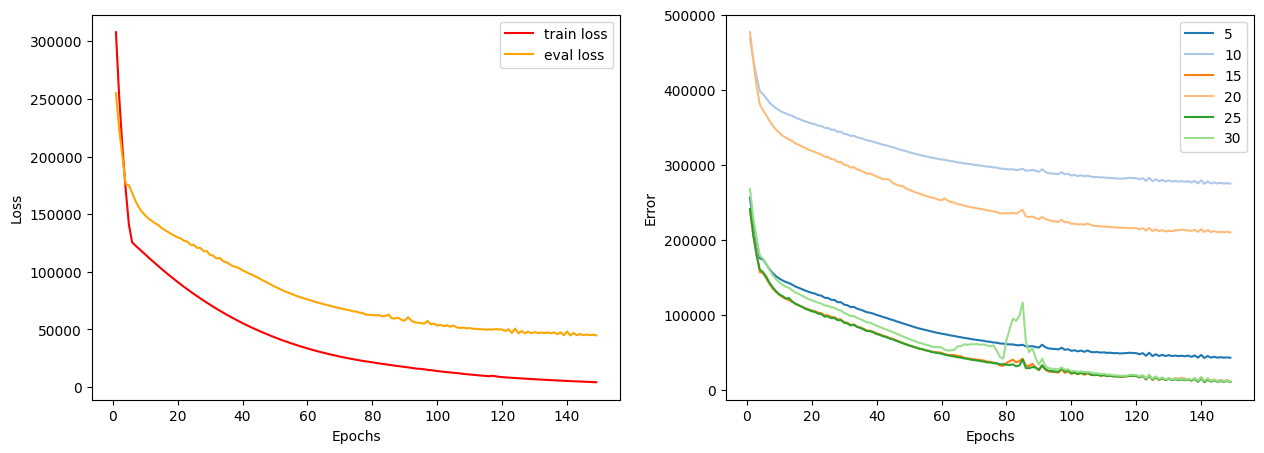

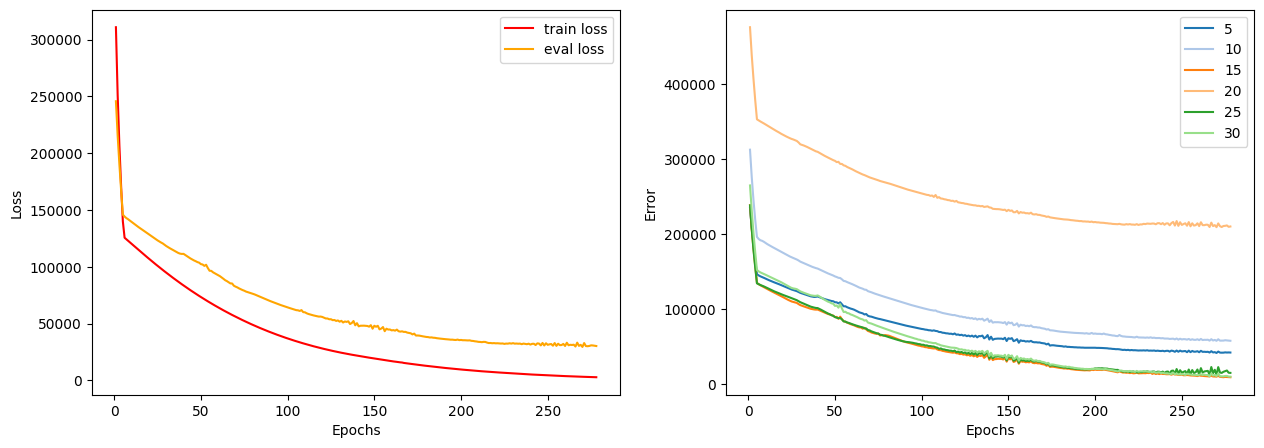

In [ ]:
learning_rates = [0.01, 0.005]
# learning_rates = [0.01]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  date_time_ = str(date_time).replace("/","_")
  mamba_config = {'d_model' : 8, 'n_layer': 2, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 600, 'early_stopping' : 8, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config) + date_time_
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  # exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
  #                                    training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
  #                                    training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
  #                                    training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     lr, training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]
  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
exp_record

,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results
0,"04/01/2024, 11:38:50",42458,274690,210503,0.010,16,2,16,./Models/mamba_model_bird_dm8nl2ds16dc4rs42bs1...,"[VIS_bird_20231114-735_20231114-082323.json, V...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 16, 'optimizer_type': <class 't...","[307955.63125, 252278.05223214286, 208267.4618...","[255052.65277777778, 223850.57465277778, 19989...","{5: [tensor(256503.7031), tensor(224283.8281),...","{5: tensor(42458.8398), 10: tensor(274690.1875..."
1,"04/01/2024, 12:17:18",41894,58069,209293,0.005,16,2,16,./Models/mamba_model_bird_dm8nl2ds16dc4rs42bs1...,"[VIS_bird_20231114-735_20231114-082323.json, V...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 16, 'optimizer_type': <class 't...","[310824.2607142857, 251288.16830357144, 206754...","[245700.06423611112, 215417.89930555556, 19024...","{5: [tensor(235175.3906), tensor(208186.6250),...","{5: tensor(41894.8281), 10: tensor(58069.7969)..."
2,"04/01/2024, 13:53:00",56580,72170,227648,0.050,16,1,16,./Models/mamba_model_bird_dm8nl1ds16dc4rs42bs1...,"[VIS_bird_20231114-735_20231114-082323.json, V...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 16, 'optimizer_type': <class 't...","[317342.2566964286, 259430.45267857143, 214876...","[240963.17534722222, 207805.48350694444, 18455...","{5: [tensor(231297.1406), tensor(202466.8281),...","{5: tensor(56580.5781), 10: tensor(72170.5625)..."
3,"04/01/2024, 13:57:47",93453,86237,236541,0.010,16,1,16,./Models/mamba_model_bird_dm8nl1ds16dc4rs42bs1...,"[VIS_bird_20231114-735_20231114-082323.json, V...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 16, 'optimizer_type': <class 't...","[305804.475, 251528.26875, 208261.45200892858,...","[274804.40625, 242474.06597222222, 213626.8836...","{5: [tensor(282884.1250), tensor(254854.7500),...","{5: tensor(93453.0703), 10: tensor(86237.5625)..."
4,"04/01/2024, 14:10:54",52965,76785,223011,0.005,16,1,16,./Models/mamba_model_bird_dm8nl1ds16dc4rs42bs1...,"[VIS_bird_20231114-735_20231114-082323.json, V...","{'d_model': 8, 'n_layer': 1, 'd_state': 16, 'e...","{'batch_size': 16, 'optimizer_type': <class 't...","[308195.52885044646, 251237.6262276786, 206950...","[254301.94965277778, 227010.67534722222, 20185...","{5: [tensor(244019.7969), tensor(220281.2344),...","{5: tensor(52965.4219), 10: tensor(76785.1797)..."


In [ ]:
# date_time_ = str(date_time).replace("/","_")
results_path = './Mamba Training Results/mamba_training_results_p_' + samples_config['subfolder']  + date_time_

with open(results_path , 'wb') as f:
  pickle.dump(exp_record, f)

In [ ]:
# learning_rates = [0.1, 0.05, 0.01]
learning_rates = [0.05]
batch_sizes = [8, 16, 32]
layers = [1, 2]

# mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
# model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': 0.1}, \
#                           'criterion' : nn.MSELoss(), 'n_epochs' : 1, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
#                    'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
#                    'verbose' : True, 'device' : device, 'continued' : True, 'run' : 2}
# training_config['model_path'] = model_path + conf2str(mamba_config, training_config)

for lr in learning_rates:
  now = datetime.now()
  date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
  mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  model_path = './Models/mamba_model_' + samples_config['subfolder'] + '_'
  training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_name': 'Adam', 'optimizer_parameter': {'lr': lr}, \
                          'criterion' : nn.MSELoss(), 'n_epochs' : 400, 'early_stopping' : 5, 'evaluation_time': 3, 'delta': 0.04, \
                   'sample_durations': [5, 10, 30, 60], 'eval_sample_durations': [5, 10, 15, 20, 25, 30],\
                   'verbose' : True, 'device' : device, 'continued' : False, 'run' : 1}
  training_config['model_path'] = model_path + conf2str(mamba_config, training_config)
# for bs in batch_sizes:
  #   for l in layers:
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  all_train_batches = prepare_mixed_dataloader(all_train_data, training_config['batch_size'])
  all_val_batches = prepare_mixed_dataloader(all_val_data, training_config['batch_size'])

  training_mamba = Training(mamba_model, training_config)
  training_mamba.train(all_train_batches, all_val_batches) #end of training loads the best model

  exp_record.loc[len(exp_record)] = [date_time, int(training_mamba.best_results[5]), int(training_mamba.best_results[10]), int(training_mamba.best_results[20]),\
                                     training_config['optimizer_parameter']['lr'], training_config['batch_size'], mamba_config['n_layer'], mamba_config['d_state'],\
                                     training_config['model_path'], test_filenames, mamba_config.copy(), training_config.copy(),\
                                     training_mamba.train_loss_history, training_mamba.eval_loss_history, training_mamba.eval_history, training_mamba.best_results]

  plot_training_summary(training_mamba)
  # exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
  #                 test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]

In [ ]:
# record_columns = ['datetime', 'Sample Duration', 'Test Files', 'Split Config', 'Features Config', 'Model', 'Model Config', 'Training Config', 'Evaluation Report', 'UAV precision', 'UAV recall', 'UAV f1', 'Total f1']
# exp_record = pd.DataFrame(columns = record_columns)

# torch.manual_seed(42)
# np.random.seed(42)

# split_config = {
#     'sample_duration' : 15,
#     'overlap_factor' : 0.25,
#     'subfolders_ind' : [0, 1, 2, 3],
#     'min_samples' : 10,
#     'random_state' : 24,
#     'test_split_files' : 0.2, # 2 for n files
#     'kfold' : 5
#   }

# features_config = {
#     'date' : 20_1_2024,
#     'extremum' : True,
#     'std' : True,
#     'span' : True,
#     'med' : True,
#     'bbox' : True,
#     'corr_sig' : True,
#     'full_ratio' : True,
#     'curve' : True,
#     'pt_ratio' : True,
#     'vel_acc_profile' : True
#   }


# # mlp_config = {'num_classes' : len(split_config['subfolders_ind']),'layers': [128,64,32,16], 'dropout': 0, 'model_random_state' : 42}
# mlp_config = {'num_classes' : len(split_config['subfolders_ind']),'layers': [256, 128, 64, 32, 16], 'dropout': 0, 'model_random_state' : 42}
# training_config = {'batch_size': 16, 'optimizer_type': Adam, 'optimizer_parameter': {'lr': 0.0001}, 'class_weights' : torch.tensor([0.1, 0.5, 0.25, 0.15]), \
#                           'criterion' : nn.CrossEntropyLoss, 'n_epochs' : 250, 'early_stopping' : 80, 'verbose' : False, 'device' : device}

# # split_random_states = [32]
# # sample_durations = [20]
# model_random_states = [42]
# split_random_states = [42]
# sample_durations = [5, 10, 15, 20, 25]
# # sample_durations = [10]
# # layerss = [[256, 128, 64, 32, 16]]
# layerss = [[256, 256, 128, 32]]
# # layerss = [[80, 80]]
# # dropouts = [0, 0.25, 0.5]
# dropouts = [0.25]
# lrs = [0.00005, 0.0001, 0.0003, 0.001, 0.005]
# batch_sizes = [16, 32, 64]
# # lrs = [0.005]
# # batch_sizes = [32]
# class_weightss = [torch.tensor(float('nan')), torch.tensor([0.15, 0.5, 0.25, 0.1])]
# # class_weightss = [torch.tensor([0.15, 0.5, 0.25, 0.1])]

# model_name = 'MLP'
# model_config = mlp_config
# now = datetime.now()
# date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
# for mrs in model_random_states:
#   model_config['model_random_state'] = mrs
#   for rs in split_random_states:
#     split_config['random_state'] = rs
#     for dur in sample_durations:
#       split_config['sample_duration'] = dur
#       for layers in layerss:
#         model_config['layers'] = layers
#         for do in dropouts:
#           model_config['dropout'] = do
#           for lr in lrs:
#             training_config['optimizer_parameter']['lr'] = lr
#             for batch_size in batch_sizes:
#               training_config['batch_size'] = batch_size
#               for cw in class_weightss:
#                 training_config['class_weights'] = cw
#                 # print(split_config)
#                 # print(model_config)
#                 #Don't change split_config beyond this point
#                 df, df0, features = get_datasets(split_config, features_config)
#                 # df.fillna(0, inplace=True)
#                 # df0.fillna(0, inplace=True)
#                 feature_columns = np.empty(0)
#                 for key in features_config.keys():
#                   if features_config[key] == True:
#                     feature_columns = np.hstack([feature_columns, features_dict[key]])

#                 df, df0 = scale_dataset(df, df0, features)
#                 train_df, test_df = split_by_files(df, df0, split_config)
#                 test_df = test_df[test_df['label'].isin(split_config['subfolders_ind'])] # removing the folders we don't want to analyze (in split_config)
#                 test = torch.tensor(test_df.iloc[:, feature_columns].values, dtype = torch.float32)
#                 test_labels = torch.tensor(test_df['label'].values)
#                 test_data = list(zip(test, test_labels))
#                 dl_test = DataLoader(test_data, batch_size = training_config['batch_size'])


#                 train_df, val_df = split_by_files(train_df, df0, split_config)
#                 train_df = train_df[train_df['label'].isin(split_config['subfolders_ind'])] # removing the folders we don't want to analyze (in split_config)
#                 train_df = train_df.sample(frac = 1, random_state = model_config['model_random_state']) #shuffled df
#                 train = torch.tensor(train_df.iloc[:, feature_columns].values, dtype = torch.float32)
#                 val_df = val_df[val_df['label'].isin(split_config['subfolders_ind'])] # removing the folders we don't want to analyze (in split_config)
#                 val = torch.tensor(val_df.iloc[:, feature_columns].values, dtype = torch.float32)
#                 train_labels = torch.tensor(train_df['label'].values)
#                 val_labels = torch.tensor(val_df['label'].values)

#                 train_data = list(zip(train, train_labels))
#                 dl_train = DataLoader(train_data, batch_size = training_config['batch_size'])
#                 val_data = list(zip(val, val_labels))
#                 dl_val = DataLoader(val_data, batch_size = training_config['batch_size'])

#                 torch.manual_seed(42)
#                 np.random.seed(42)
#                 mlp_config['num_features'] = len(feature_columns)
#                 model_MLP = MLP(mlp_config)
#                 model_MLP.apply(initialize_weights)
#                 # calculate class weights for training
#                 if torch.any(torch.isnan(training_config['class_weights'])):
#                   u_labels, counts = torch.unique(train_labels, return_counts=True)
#                   class_weights = 1/counts
#                   training_config['class_weights'] = class_weights

#                 # Training
#                 training_mlp = Training(model_MLP, training_config)
#                 training_mlp.train() #end of training loads the best model
#                 # plot_training_summary(training_mlp)
#                 print('finished training')

#                 training_mlp.evaluate_epoch(dl_val)
#                 # aggregate metrics
#                 uav_precision_m = training_mlp.report['uav']['precision']
#                 uav_recall_m = training_mlp.report['uav']['recall']
#                 uav_f1_m = training_mlp.report['uav']['f1-score']
#                 weighted_f1_m = training_mlp.report['weighted avg']['f1-score']
#                 # finally with test data
#                 training_mlp.evaluate_epoch(dl_test)
#                 test_report = training_mlp.report

#                 # wrong_ind = np.where(predictions != test_labels)
#                 # print('wrong on:')
#                 # print(test_df['file'].iloc[wrong_ind])
#                 test_files = np.unique(test_df['file'])
#                 exp_record.loc[len(exp_record)] = [date_time, dur, test_files, split_config.copy(), features_config, model_name, model_config.copy(), copy.deepcopy(training_config),
#                                   test_report, uav_precision_m, uav_recall_m, uav_f1_m, weighted_f1_m]
#                 # exp_record.to_csv(exp_record_path, index = False)

# New Section

In [ ]:
# date_time_ = str(date_time).replace("/","_")
# results_path = './Features Extraction Results/features_extraction_results_' + date_time_

# with open(results_path , 'wb') as f:
#   pickle.dump(exp_record, f)